### 📚 Importation des bibliothèques nécessaires

In [2]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import shap
import pandas as pd
import numpy as np
from IPython.display import HTML, display
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.multioutput import ClassifierChain
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import KNNImputer
from sklearn.calibration import CalibratedClassifierCV
import optuna
from imblearn.metrics import geometric_mean_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.feature_selection import SelectFromModel
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.inspection import permutation_importance


### 📂 Lecture du fichier Excel

In [3]:
# Lire le fichier Excel
df = pd.read_excel("agriculture.xlsx")

### ℹ️ Affichage des informations sur les colonnes

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 65 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   N°                                     80 non-null     int64  
 1   Date de la visite                      80 non-null     object 
 2   Nom                                    0 non-null      float64
 3   Prénom                                 0 non-null      float64
 4   N° du téléphone                        0 non-null      float64
 5   Date de naissance                      80 non-null     object 
 6   Age                                    80 non-null     object 
 7   Situation maritale                     80 non-null     object 
 8   Nb enfants                             80 non-null     object 
 9   Nb pers à charge                       80 non-null     object 
 10  Profession du mari                     80 non-null     object 
 11  Domicile

### Notes: 
Nombre total d'entrées (lignes) : 81

Nombre total de colonnes : 65

Types de données :

float64 : 9 colonnes (variables numériques continue).

object : 56 colonnes (variables catégorielles ou textuelles).

# ## Prétraitement

### 🗑️ Suppression des colonnes entièrement vides

In [5]:
# Identifier les colonnes entièrement vides
colonnes_vides = df.columns[df.isna().all()].tolist()
print("Colonnes entièrement vides :", colonnes_vides)

Colonnes entièrement vides : ['Nom', 'Prénom', 'N° du téléphone']


In [6]:
# Supprimer les colonnes entièrement vides
df = df.drop(columns=colonnes_vides)
# Afficher le DataFrame après suppression
print(df) 

    N° Date de la visite    Date de naissance           Age  \
0    1        2024-09-21           1965-01-01            60   
1    2        2024-09-21         non spécifié  non spécifié   
2    3        2024-09-21           1965-01-01            60   
3    4        2024-09-21           1977-01-01            48   
4    5        2024-09-21           1982-01-06            43   
..  ..               ...                  ...           ...   
75  76        2024-10-08           1979-01-16            46   
76  77        2024-10-08           1976-02-20            49   
77  78        2024-10-08           1997-04-17            27   
78  79        2024-10-08           1960-01-01            65   
79  80        2024-10-08  1972-01-14 00:00:00            53   

   Situation maritale Nb enfants Nb pers à charge  Profession du mari  \
0         célibataire          0                1        non spécifié   
1              mariée          1                1         agriculteur   
2              mariée   

### 🔄 Conversion des colonnes Numériques de type Object vers Float/Int

In [7]:
# Conversion des colonnes numériques (remplacement des valeurs textuelles par NaN)
colonnes_a_convertir = ["Age", "Nb enfants", "Nb pers à charge", "H travail / jour","Age ménopause","Ancienneté agricole","J travail / Sem" ]
df[colonnes_a_convertir] = df[colonnes_a_convertir].replace(["non spécifié"], None)

# Convertir en int (ou float si des valeurs NaN existent)
for col in colonnes_a_convertir:
    df[col] = pd.to_numeric(df[col], errors="coerce")  # Convertit en int/float

### 📅 Conversion des dates

In [8]:
# Convertir les dates
df["Date de la visite"] = pd.to_datetime(df["Date de la visite"], errors="coerce")
df["Date de naissance"] = pd.to_datetime(df["Date de naissance"], errors="coerce")

### 🔍 Vérification des types de données

In [9]:
print(df.dtypes)

N°                               int64
Date de la visite       datetime64[ns]
Date de naissance       datetime64[ns]
Age                            float64
Situation maritale              object
                             ...      
Examen neurologique             object
Examen abdominal                object
Examen visuel                   object
Spirométrie                     object
Interprétation Spiro            object
Length: 62, dtype: object


### 📊 Visualisation des valeurs manquantes

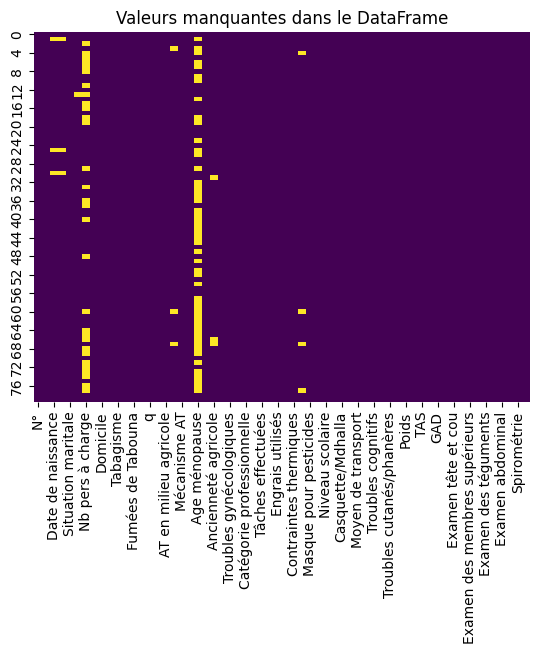

In [10]:
sns.heatmap(df.isna(), cbar=False, cmap='viridis')
plt.title("Valeurs manquantes dans le DataFrame")
plt.show() 

Jaune: indique la présence de valeurs manquantes(NaN)

Violet:  indique des données présentes

### 🧮 Calcul des valeurs manquantes

In [11]:
missing_values = df.isna().sum()
print(missing_values)

N°                      0
Date de la visite       0
Date de naissance       3
Age                     3
Situation maritale      0
                       ..
Examen neurologique     0
Examen abdominal        0
Examen visuel           0
Spirométrie             0
Interprétation Spiro    0
Length: 62, dtype: int64


In [12]:
missing_percent = (df.isna().sum() / len(df)) * 100
print(missing_percent)

N°                      0.00
Date de la visite       0.00
Date de naissance       3.75
Age                     3.75
Situation maritale      0.00
                        ... 
Examen neurologique     0.00
Examen abdominal        0.00
Examen visuel           0.00
Spirométrie             0.00
Interprétation Spiro    0.00
Length: 62, dtype: float64


### 🔢 Sélection des colonnes numériques et affichage des valeurs manquantes +  Imputation

In [13]:
# Sélectionner les colonnes numériques
colonnes_numeriques = df.select_dtypes(include=['int64', 'float64']).columns

# Afficher les valeurs manquantes pour ces colonnes
missing_values_numeriques = df[colonnes_numeriques].isna().sum()

# Afficher uniquement celles qui ont des valeurs manquantes
missing_values_numeriques = missing_values_numeriques[missing_values_numeriques > 0]
print(missing_values_numeriques)

Age                     3
Nb enfants              1
Nb pers à charge       30
H travail / jour        3
Age ménopause          51
Ancienneté agricole     3
J travail / Sem         4
dtype: int64


📌remarques:  Stratégies de Remplissage des Valeurs Manquantes

Âge (Age): L'âge suit une distribution asymétrique, donc la médiane est plus robuste.

Nombre d'enfants (Nb enfants): Puisque c'est un entier et souvent catégorisé, la mode est souvent plus logique.

Nb pers à charge: 30 valeurs manquantes = beaucoup ! La mode (valeur la plus fréquente) est souvent une bonne approche.

H travail / jour: Les horaires de travail peuvent varier, et la médiane est plus robuste aux valeurs extrêmes.

Âge ménopause: Généralement, l’âge de la ménopause suit une distribution normale, donc la moyenne peut convenir.

Ancienneté agricole: mode

J travail / Sem:Le nombre de jours travaillés est souvent limité à 5-7, donc la mode est logique.


In [14]:
from datetime import datetime

# Définir l'année de référence
annee_reference = 2025

# Calculer l'âge
df["Age_calcule"] = annee_reference - df["Date de naissance"].dt.year

# Imputer les valeurs manquantes dans "Age"
df["Age"] = df["Age"].fillna(df["Age_calcule"])

# Supprimer la colonne temporaire
df = df.drop(columns=["Age_calcule"])

# Vérification
print(df[["Date de naissance", "Age"]].head())
print(df["Age"].describe())
print(df["Age"].isna().sum())

  Date de naissance   Age
0        1965-01-01  60.0
1               NaT   NaN
2        1965-01-01  60.0
3        1977-01-01  48.0
4        1982-01-06  43.0
count    77.000000
mean     46.779221
std      12.573597
min      21.000000
25%      38.000000
50%      47.000000
75%      55.000000
max      77.000000
Name: Age, dtype: float64
3


In [15]:
# Pour les âges toujours manquants (date de naissance aussi manquante)
median_age = df["Age"].median()
df["Age"] = df["Age"].fillna(median_age)

In [16]:
df["Nb enfants"] = df["Nb enfants"].fillna(df["Nb enfants"].mode()[0])
df["Nb pers à charge"] = df["Nb pers à charge"].fillna(df["Nb pers à charge"].mode()[0])
df["H travail / jour"] = df["H travail / jour"].fillna(df["H travail / jour"].median())
df["Age ménopause"] = df["Age ménopause"].fillna(df["Age ménopause"].mean())  # Vérifier la distribution avant
df["Ancienneté agricole"] = df["Ancienneté agricole"].fillna(df["Ancienneté agricole"].mode()[0])
df["J travail / Sem"] = df["J travail / Sem"].fillna(df["J travail / Sem"].mode()[0])

### 🏷️ Sélection des colonnes catégorielles et affichage des valeurs manquantes

In [17]:
# Sélectionner les colonnes catégorielles
colonnes_categorielles = df.select_dtypes(include=['object']).columns

# Compter les valeurs manquantes uniquement dans les colonnes catégorielles
missing_values_categoriel = df[colonnes_categorielles].isna().sum()

# Afficher uniquement les colonnes avec des valeurs manquantes
missing_values_categoriel[missing_values_categoriel > 0]


Series([], dtype: int64)

### 🔄 Remplacer les valeurs "0" par "non spécifié" ds les valeurs catégorielle

In [18]:
# Identifier les colonnes catégorielles
cat_columns = df.select_dtypes(include=['object']).columns

# Remplacer les valeurs '0' et 0 par 'non spécifié' dans les colonnes catégorielles
df[cat_columns] = df[cat_columns].replace(['0', 0], 'non spécifié')

# Vérifier que la transformation a bien été appliquée
for col in cat_columns:
    print(f"Valeurs uniques dans la colonne '{col}':\n", df[col].value_counts()) 

Valeurs uniques dans la colonne 'Situation maritale':
 Situation maritale
mariée          62
célibataire     11
veuve            4
divorcée         2
non spécifié     1
Name: count, dtype: int64
Valeurs uniques dans la colonne 'Profession du mari':
 Profession du mari
non spécifié                  23
ouvrier journalier            13
agriculteur                   10
marin                          4
a l'étranger                   3
ouvrier                        3
ouvrier agricole               2
maçon                          2
maintenance hotel              1
menuisier                      1
professeur                     1
pompiste                       1
instituteur + agriculteur      1
chauffeur de taxi              1
policier retraité              1
directeur                      1
chômeur                        1
pêcheur                        1
tissage                        1
professeur dans un collège     1
policier                       1
rien                           1
chauf

# ## 📊 Visualisation des données

### ✔️ Profil des travailleuses :

In [43]:
# Statistiques sur les colonnes catégorielles
profil_categories = ["Situation maritale", "Profession du mari", "Niveau socio-économique","Domicile","Age","Nb enfants","Nb pers à charge"
                     ,"Niveau scolaire","Poids","Taille","Age ménopause","Ménopause"]
for col in profil_categories:
    print(f"Statistiques pour {col}:")
    print(df[col].value_counts(dropna=False))  # Inclut NaN
    print("\n")

Statistiques pour Situation maritale:
Situation maritale
mariée          62
célibataire     11
veuve            4
divorcée         2
non spécifié     1
Name: count, dtype: int64


Statistiques pour Profession du mari:
Profession du mari
non spécifié                  23
ouvrier journalier            13
agriculteur                   10
marin                          4
a l'étranger                   3
ouvrier                        3
ouvrier agricole               2
maçon                          2
maintenance hotel              1
menuisier                      1
professeur                     1
pompiste                       1
instituteur + agriculteur      1
chauffeur de taxi              1
policier retraité              1
directeur                      1
chômeur                        1
pêcheur                        1
tissage                        1
professeur dans un collège     1
policier                       1
rien                           1
chauffeur de louage            1
doua

In [44]:
# Configuration du style de visualisation
plt.style.use('ggplot')
sns.set_palette("husl")

# %% [markdown]
# ### 🛠️ Fonction d'analyse du dataset
def analyze_dataset(df):
    # 1. Analyse des variables catégoriques
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Distribution des Variables Catégoriques', fontsize=16)
    
    # Niveau scolaire vs Niveau socio-économique
    sns.countplot(data=df, x='Niveau scolaire', hue='Niveau socio-économique', ax=axes[0,0])
    axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)
    
    # Situation maritale
    sns.countplot(data=df, x='Situation maritale', ax=axes[0,1])
    axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45)
    
    # Profession du mari selon niveau socio-économique
    sns.countplot(data=df, x='Profession du mari', hue='Niveau socio-économique', ax=axes[1,0])
    axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45)
    
    # Ménopause selon l'âge
    sns.boxplot(data=df, x='Ménopause', y='Age', ax=axes[1,1])
    
    plt.tight_layout()
    plt.show()

    # 2. Analyse des corrélations importantes
    plt.figure(figsize=(12, 8))
    
    # Matrice de corrélation pour les variables numériques
    numeric_cols = ['Age', 'Nb enfants', 'Nb pers à charge', 'Poids', 'Taille', 'Age ménopause']
    corr_matrix = df[numeric_cols].corr()
    
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Matrice de Corrélation des Variables Numériques')
    plt.tight_layout()
    plt.show()

    # 3. Relations spécifiques importantes
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Relations entre Variables Importantes', fontsize=16)
    
    # Niveau scolaire vs Nombre d'enfants
    sns.boxplot(data=df, x='Niveau scolaire', y='Nb enfants', ax=axes[0,0])
    axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)
    
    # Age vs Nombre d'enfants selon niveau socio-économique
    sns.scatterplot(data=df, x='Age', y='Nb enfants', hue='Niveau socio-économique', ax=axes[0,1])
    
    # Nombre de personnes à charge selon niveau socio-économique
    sns.boxplot(data=df, x='Niveau socio-économique', y='Nb pers à charge', ax=axes[1,0])
    
    # Poids vs Taille avec régression
    sns.regplot(data=df, x='Taille', y='Poids', ax=axes[1,1])
    
    plt.tight_layout()
    plt.show()

    # 4. Statistiques descriptives
    print("\nStatistiques descriptives des variables numériques:")
    print(df[numeric_cols].describe())
    
    # 5. Analyse des valeurs manquantes
    print("\nValeurs manquantes par colonne:")
    print(df.isnull().sum())

###  Exécution de la fonction d'analyse

C:\Users\MSI\AppData\Local\Temp\ipykernel_24444\1643605729.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)
C:\Users\MSI\AppData\Local\Temp\ipykernel_24444\1643605729.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45)
C:\Users\MSI\AppData\Local\Temp\ipykernel_24444\1643605729.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45)


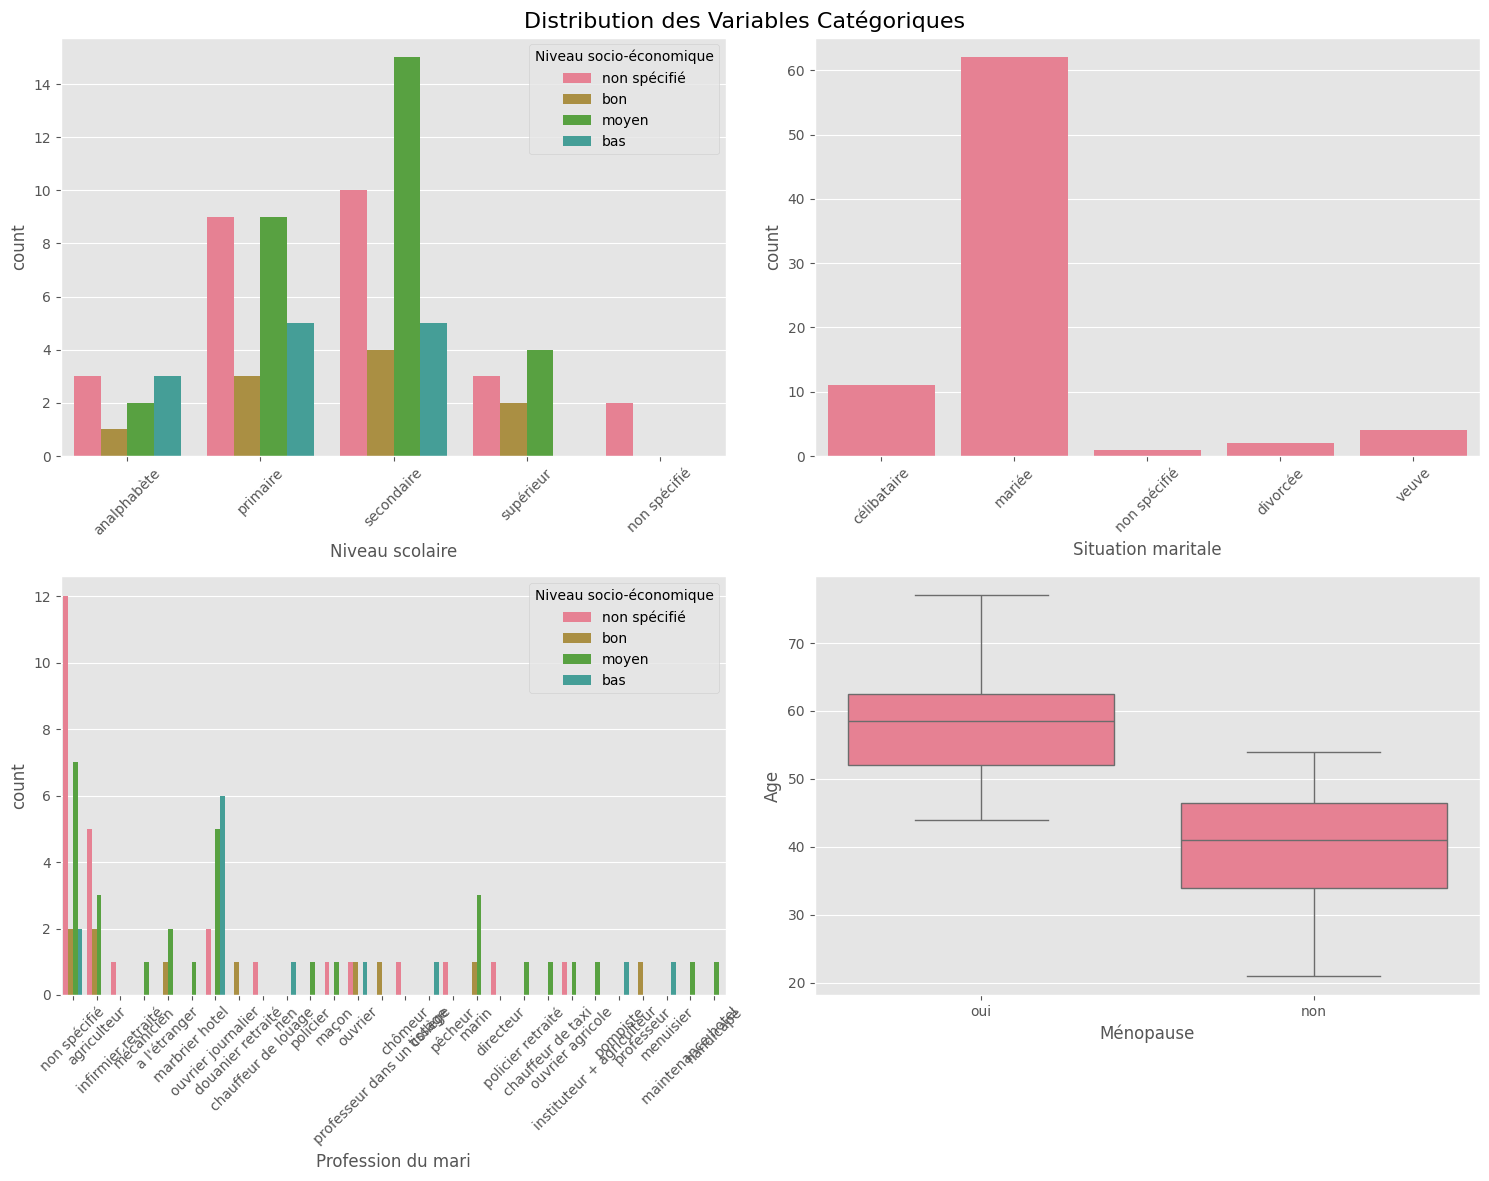

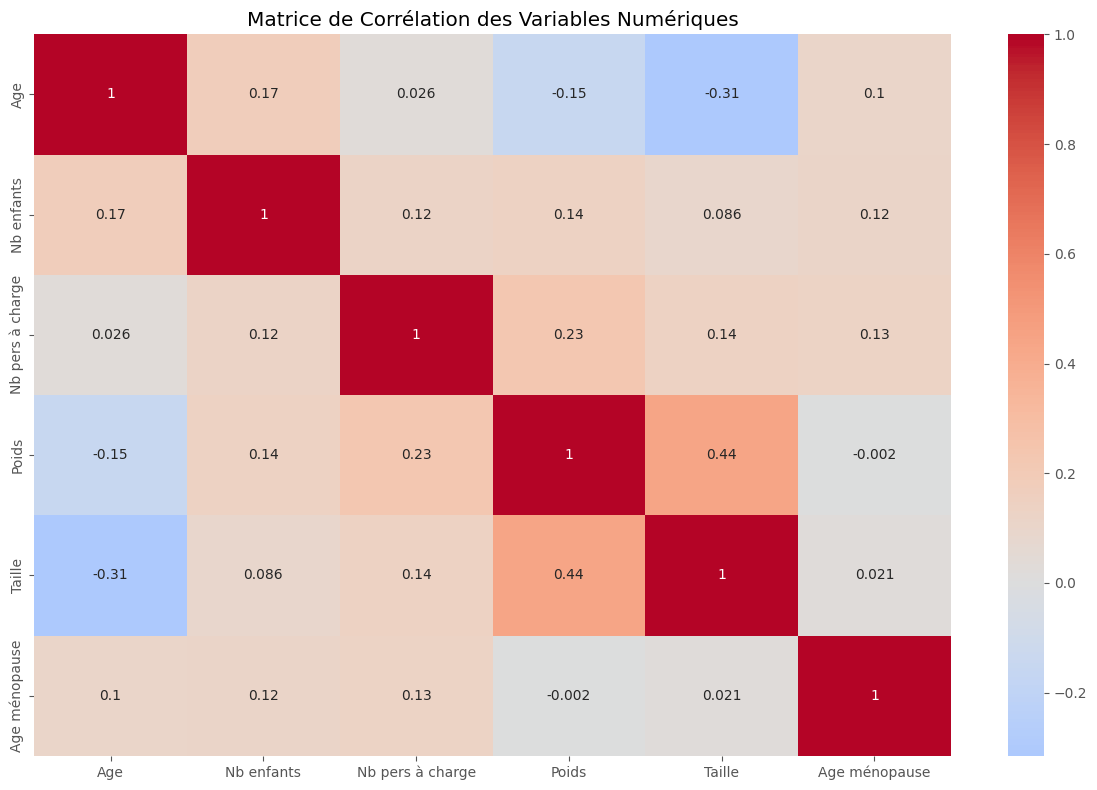

C:\Users\MSI\AppData\Local\Temp\ipykernel_24444\1643605729.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)


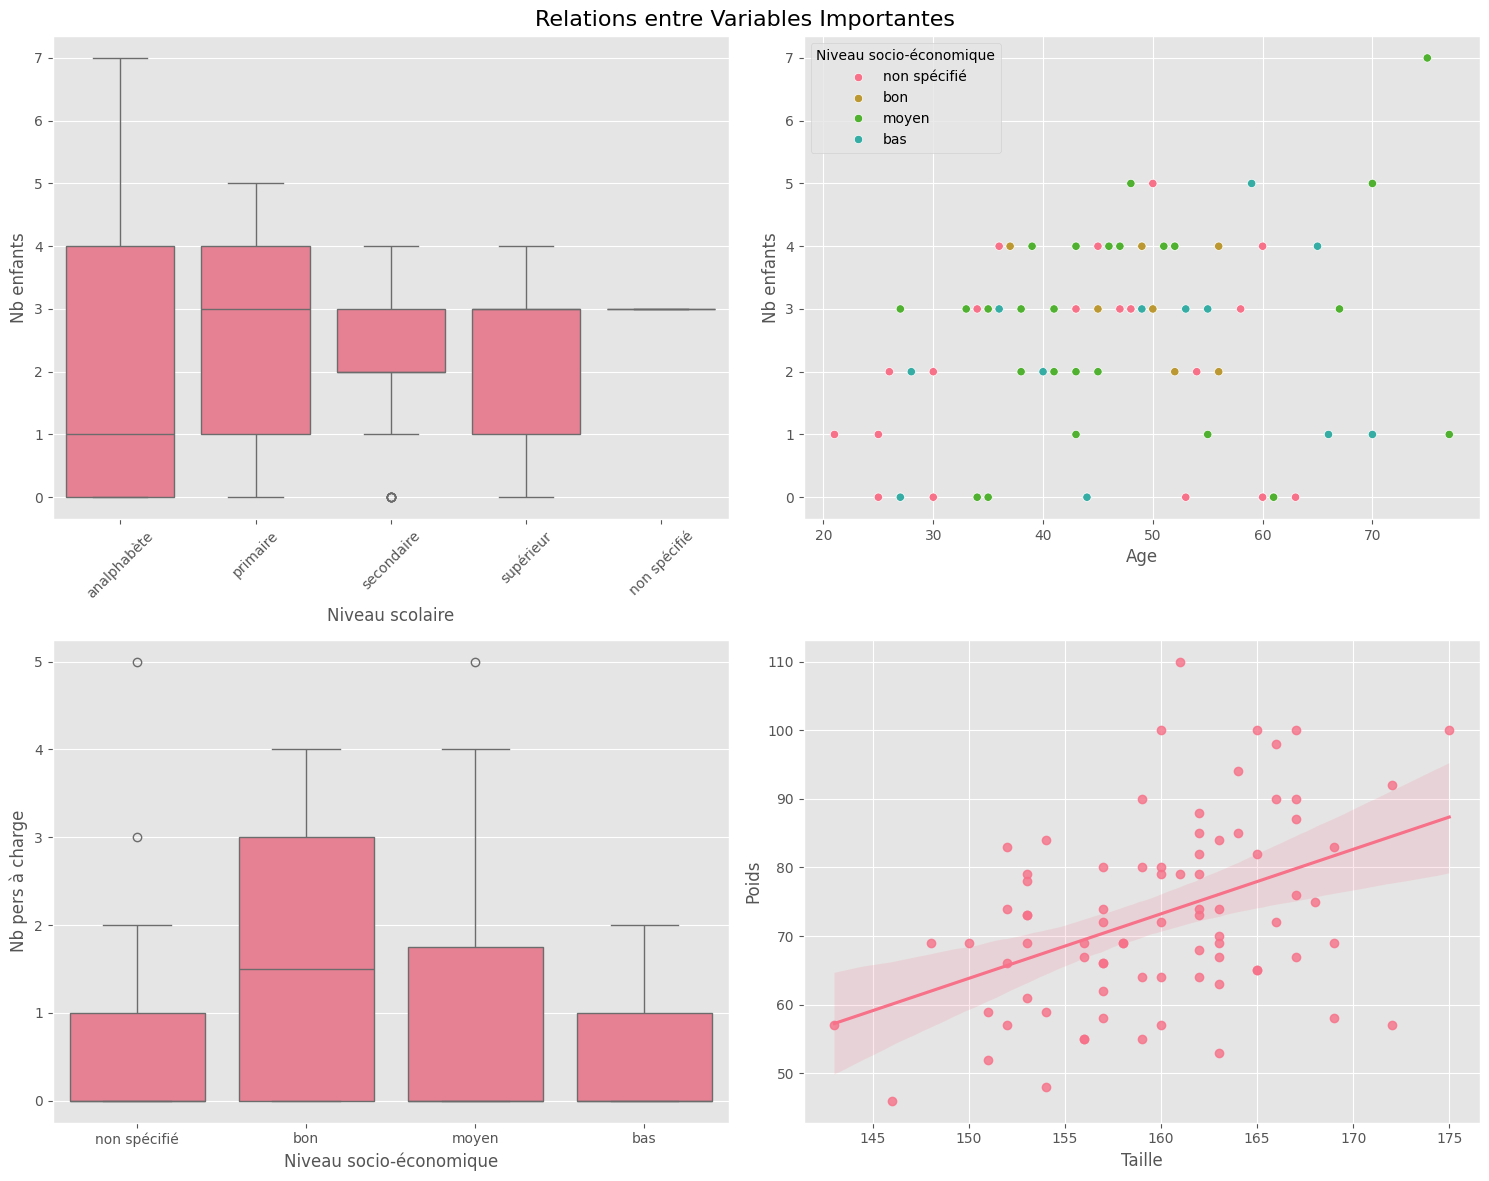


Statistiques descriptives des variables numériques:
             Age  Nb enfants  Nb pers à charge       Poids      Taille  \
count  77.000000   80.000000          80.00000   80.000000   80.000000   
mean   46.779221    2.400000           0.93750   73.075000  159.825000   
std    12.573597    1.635059           1.42619   13.507405    6.251633   
min    21.000000    0.000000           0.00000   46.000000  143.000000   
25%    38.000000    1.000000           0.00000   64.000000  156.000000   
50%    47.000000    3.000000           0.00000   72.000000  160.000000   
75%    55.000000    4.000000           1.25000   82.000000  164.000000   
max    77.000000    7.000000           5.00000  110.000000  175.000000   

       Age ménopause  
count      80.000000  
mean       47.793103  
std         3.729388  
min        30.000000  
25%        47.793103  
50%        47.793103  
75%        47.793103  
max        58.000000  

Valeurs manquantes par colonne:
N°                      0
Date de la vis

In [45]:
analyze_dataset(df) 

### ✔️ Conditions de travail

### Statistiques sur les colonnes catégorielles

In [46]:
profil_categories = ["Catégorie professionnelle", "Statut", "Tâches effectuées", 
    "Contraintes physiques", "Contraintes thermiques", 
    "Produits chimiques utilisés", "Engrais utilisés", "Produits biologiques utilisés",
    "Moyen de transport","Masque pour pesticides", "Bottes", "Gants", "Casquette/Mdhalla", "Manteau imperméable"]
for col in profil_categories:
    print(f"Statistiques pour {col}:")
    print(df[col].value_counts(dropna=False))  # Inclut NaN
    print("\n")

Statistiques pour Catégorie professionnelle:
Catégorie professionnelle
agricultrice indépendante              62
ouvrière                               10
ouvrière, agricultrice indépendante     7
pêcheur indépendante                    1
Name: count, dtype: int64


Statistiques pour Statut:
Statut
permanente      61
saisonnière     11
non spécifié     8
Name: count, dtype: int64


Statistiques pour Tâches effectuées:
Tâches effectuées
elevage des animaux, récolte des fruits/légumes, cueillette des olives                                                                                               16
epandage des engrais, elevage des animaux, récolte des fruits/légumes, cueillette des olives, désherbage manuel                                                      14
récolte des fruits/légumes, cueillette des olives                                                                                                                     9
elevage des animaux, récolte des fruits/légumes, cueille

###  Visualisation des équipements de protection

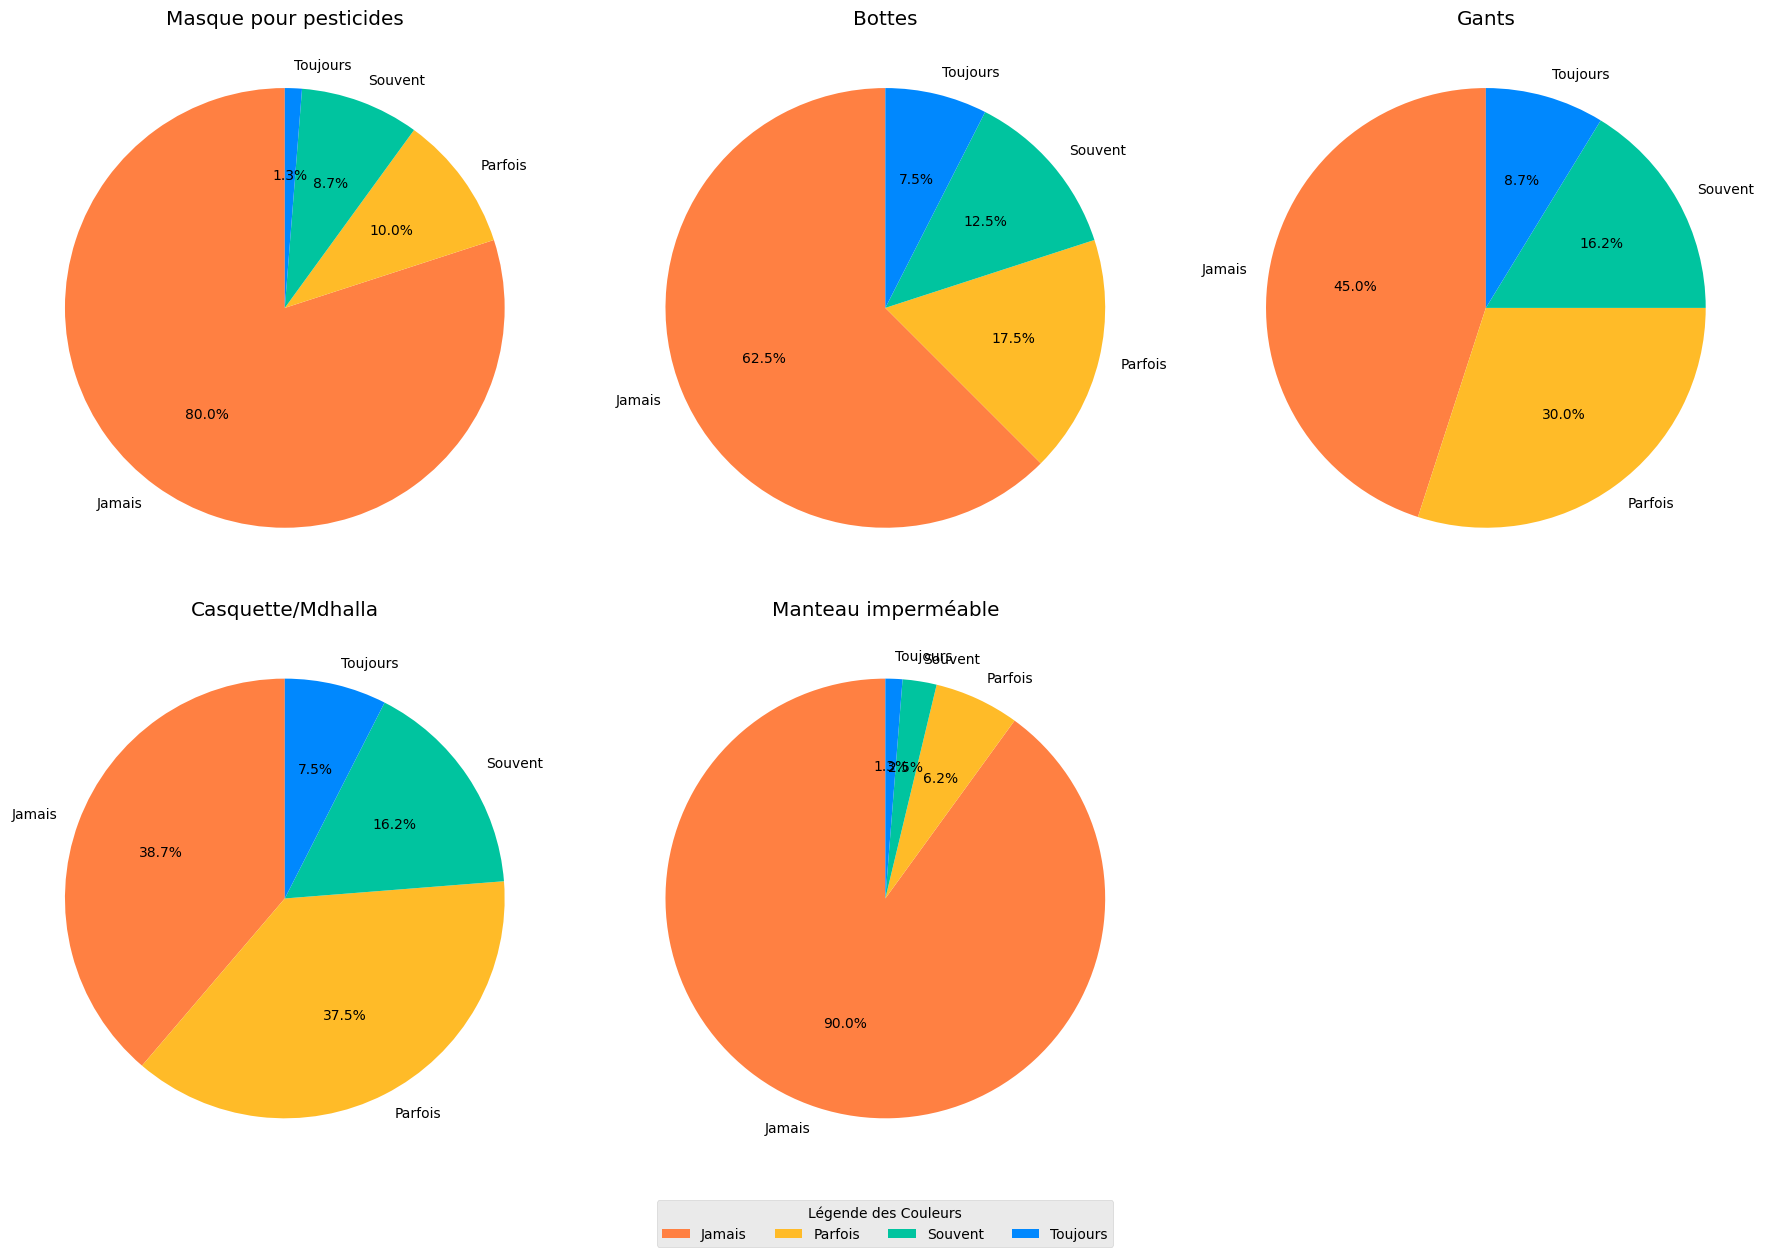

In [116]:
# Données simulées pour la démonstration
equipment_data = {
    "Masque pour pesticides": [
        {"name": "Jamais", "value": 64},
        {"name": "Parfois", "value": 8},
        {"name": "Souvent", "value": 7},
        {"name": "Toujours", "value": 1}
    ],
    "Bottes": [
        {"name": "Jamais", "value": 50},
        {"name": "Parfois", "value": 14},
        {"name": "Souvent", "value": 10},
        {"name": "Toujours", "value": 6}
    ],
    "Gants": [
        {"name": "Jamais", "value": 36},
        {"name": "Parfois", "value": 24},
        {"name": "Souvent", "value": 13},
        {"name": "Toujours", "value": 7}
    ],
    "Casquette/Mdhalla": [
        {"name": "Jamais", "value": 31},
        {"name": "Parfois", "value": 30},
        {"name": "Souvent", "value": 13},
        {"name": "Toujours", "value": 6}
    ],
    "Manteau imperméable": [
        {"name": "Jamais", "value": 72},
        {"name": "Parfois", "value": 5},
        {"name": "Souvent", "value": 2},
        {"name": "Toujours", "value": 1}
    ]
}

colors = ['#FF8042', '#FFBB28', '#00C49F', '#0088FE']
labels = ['Jamais', 'Parfois', 'Souvent', 'Toujours']

# Création des graphiques en camembert pour chaque équipement
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (equipment, data) in enumerate(equipment_data.items()):
    values = [d['value'] for d in data]
    axes[i].pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
    axes[i].set_title(equipment)

# Masquer le dernier subplot s'il n'est pas utilisé
if len(equipment_data) < len(axes):
    for j in range(len(equipment_data), len(axes)):
        fig.delaxes(axes[j])

# Ajouter une légende
fig.legend(labels, title="Légende des Couleurs", loc="lower center", bbox_to_anchor=(0.5, -0.05), ncol=4)

plt.tight_layout()
plt.show()

###  Analyse des équipements de protection

In [117]:
def analyze_protection_equipment(df):
    # 1. Conversion des valeurs ordinales en numériques
    ordinal_mapping = {
        'jamais': 0,
        'parfois': 1,
        'souvent': 2,
        'toujours': 3
    }
    
    protection_cols = ["Masque pour pesticides", "Bottes", "Gants", 
                       "Casquette/Mdhalla", "Manteau imperméable"]
    
    # Créer une copie du DataFrame
    df_clean = df.copy()
    
    # Convertir les colonnes en chaînes de caractères (si nécessaire) et gérer les NaN
    for col in protection_cols:
        # Convertir en chaîne de caractères et gérer les NaN (les remplacer par une valeur par défaut, ex: 'jamais')
        df_clean[col] = df_clean[col].fillna('jamais').astype(str).str.lower().map(ordinal_mapping)
        
    # 2. Visualisation de la distribution des équipements
   

    # 3. Heatmap des fréquences d'utilisation
    plt.figure(figsize=(12, 6))
    protection_means = df_clean[protection_cols].mean().sort_values(ascending=True)
    sns.heatmap([protection_means], annot=True, fmt='.2f', cmap='YlOrRd',
                xticklabels=protection_means.index, yticklabels=['Moyenne d\'utilisation'],
                cbar_kws={'label': 'Fréquence moyenne (0=jamais, 3=toujours)'})
    plt.title('Fréquence Moyenne d\'Utilisation des Équipements de Protection')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


    # 5. Statistiques descriptives
    print("\nStatistiques descriptives sur l'utilisation des équipements:")
    stats = df_clean[protection_cols].describe()
    print("\nMoyenne d'utilisation (0=jamais, 3=toujours):")
    print(stats.loc['mean'].sort_values(ascending=False))
    
    # 6. Analyse des combinaisons d'équipements
    frequent_users = df_clean[protection_cols] >= 2  # souvent ou toujours
    print("\nPourcentage d'utilisation fréquente (souvent ou toujours):")
    print((frequent_users.mean() * 100).sort_values(ascending=False).round(1))

    # 7. Score de protection global
    df_clean['protection_score'] = df_clean[protection_cols].mean(axis=1)
    
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_clean, x='protection_score', bins=20)
    plt.title('Distribution du Score de Protection Global')
    plt.xlabel('Score moyen (0=aucune protection, 3=protection maximale)')
    plt.ylabel('Nombre de personnes')
    plt.tight_layout()
    plt.show()

    return df_clean


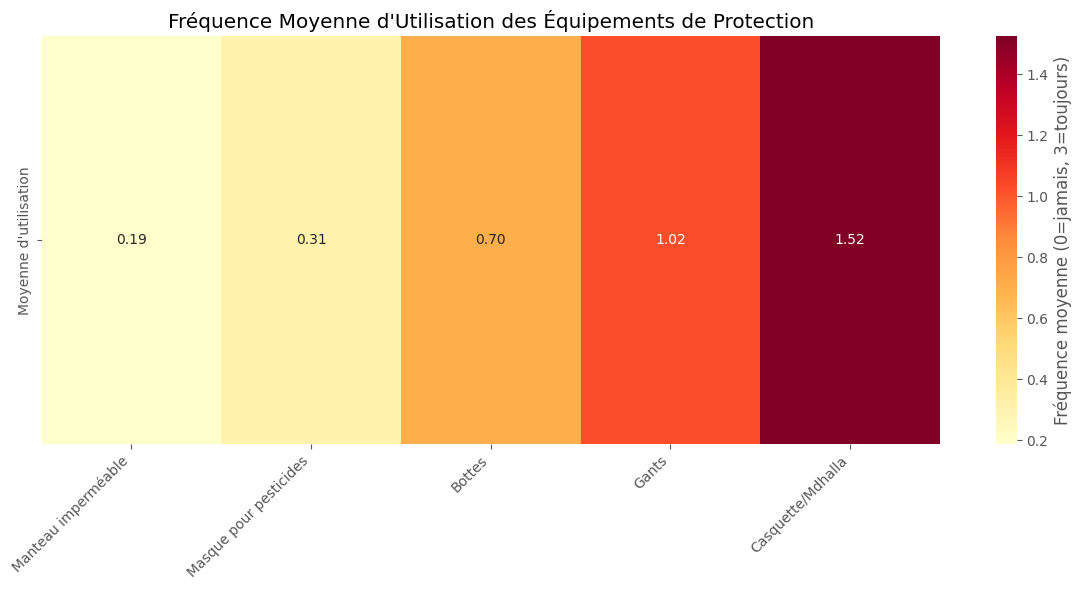


Statistiques descriptives sur l'utilisation des équipements:

Moyenne d'utilisation (0=jamais, 3=toujours):
Casquette/Mdhalla         1.5250
Gants                     1.0250
Bottes                    0.7000
Masque pour pesticides    0.3125
Manteau imperméable       0.1875
Name: mean, dtype: float64

Pourcentage d'utilisation fréquente (souvent ou toujours):
Casquette/Mdhalla         53.8
Gants                     38.8
Bottes                    25.0
Masque pour pesticides    10.0
Manteau imperméable        7.5
dtype: float64


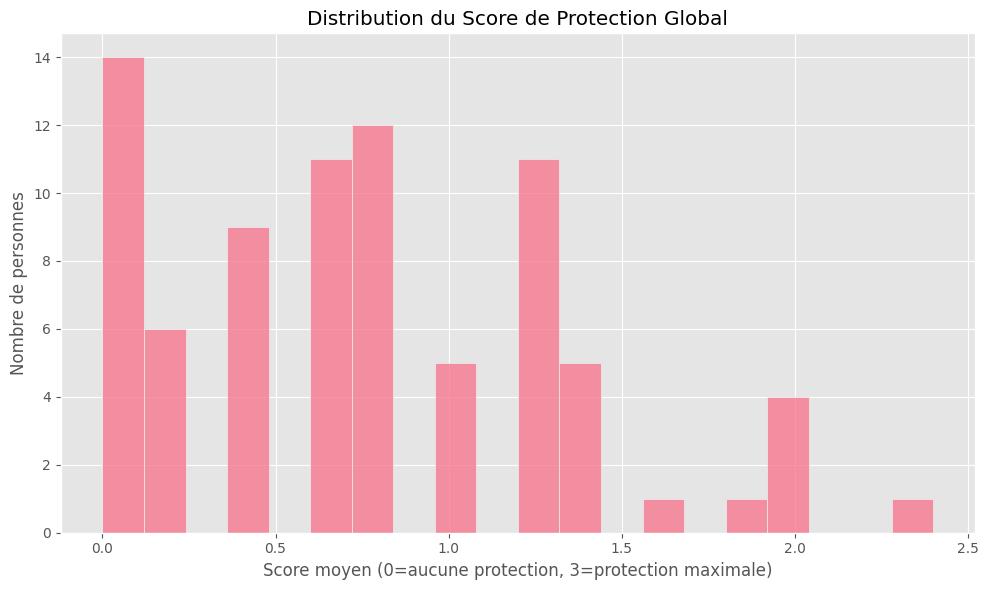

In [118]:
df_clean = analyze_protection_equipment(df)

### Analyse des conditions de travail

In [47]:
def analyze_working_conditions(df):
    plt.style.use('ggplot')
    
    # Définition des colonnes par type
    protection_cols = ["Masque pour pesticides", "Bottes", "Gants", 
                      "Casquette/Mdhalla", "Manteau imperméable"]
    
    # Conversion des variables ordinales en valeurs numériques
    ordinal_mapping = {
        'jamais': 0,
        'parfois': 1,
        'souvent': 2,
        'toujours': 3
    }
    
    # Création d'une copie du DataFrame pour les transformations
    df_numeric = df.copy()
    
    # Conversion des variables de protection en valeurs numériques
    for col in protection_cols:
        df_numeric[col] = df_numeric[col].map(ordinal_mapping)

    # 3. Analyse des tâches et contraintes (reste inchangé)
    fig, axes = plt.subplots(2, 1, figsize=(15, 12))
    
    task_counts = df["Tâches effectuées"].value_counts()
    sns.barplot(x=task_counts.values, y=task_counts.index, ax=axes[0])
    axes[0].set_title("Distribution des Tâches Effectuées")
    
    constraint_counts = df["Contraintes physiques"].value_counts()
    sns.barplot(x=constraint_counts.values, y=constraint_counts.index, ax=axes[1])
    axes[1].set_title("Types de Contraintes Physiques")
    
    plt.tight_layout()
    plt.show()


    # 5. Analyse des contraintes thermiques (reste inchangé)
    plt.figure(figsize=(10, 6))
    thermal_counts = df["Contraintes thermiques"].value_counts()
    sns.barplot(x=thermal_counts.index, y=thermal_counts.values)
    plt.title("Distribution des Contraintes Thermiques")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 6. Analyse du transport (reste inchangé)
    plt.figure(figsize=(10, 6))
    transport_counts = df["Moyen de transport"].value_counts()
    plt.pie(transport_counts.values, labels=transport_counts.index, autopct='%1.1f%%')
    plt.title("Répartition des Moyens de Transport")
    plt.tight_layout()
    plt.show()

    # 7. Analyse des risques améliorée
    def calculate_risk_score(row):
        risk_score = 0
        
        # Facteurs de risque physiques
        if "contraintes biomécaniques" in str(row["Contraintes physiques"]).lower():
            risk_score += 2
        if "contraintes mécaniques" in str(row["Contraintes physiques"]).lower():
            risk_score += 1
            
        # Facteurs de risque thermiques
        if "chaleur" in str(row["Contraintes thermiques"]).lower():
            risk_score += 1
        if "froid" in str(row["Contraintes thermiques"]).lower():
            risk_score += 1
            
        # Facteurs de risque chimiques
        if "pesticides" in str(row["Produits chimiques utilisés"]).lower():
            risk_score += 2
        if "engrais chimiques" in str(row["Produits chimiques utilisés"]).lower():
            risk_score += 1
            
        # Protection (utilisation des valeurs numériques converties)
        protection_score = sum([row[col] for col in protection_cols]) / len(protection_cols)
        
        return risk_score - protection_score

    df_numeric['Risk_Score'] = df_numeric.apply(calculate_risk_score, axis=1)

    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_numeric, x='Risk_Score', bins=20)
    plt.title("Distribution des Scores de Risque")
    plt.xlabel("Score de Risque (Plus élevé = Plus risqué)")
    plt.tight_layout()
    plt.show()

    # 8. Matrice de corrélation améliorée
    plt.figure(figsize=(12, 10))
    correlation_matrix = df_numeric[protection_cols].corr(method='spearman')
    
    # Création d'un masque pour le triangle supérieur
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Affichage de la matrice de corrélation
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='coolwarm', 
                center=0,
                fmt='.2f',
                square=True,
                vmin=-1,
                vmax=1)
    
    plt.title('Matrice de Corrélation des Équipements de Protection')
    plt.tight_layout()
    plt.show()

    # 9. Statistiques descriptives
    print("\nStatistiques sur l'utilisation des équipements de protection:")
    protection_stats = df[protection_cols].value_counts().unstack()
    print(protection_stats)

    return df_numeric

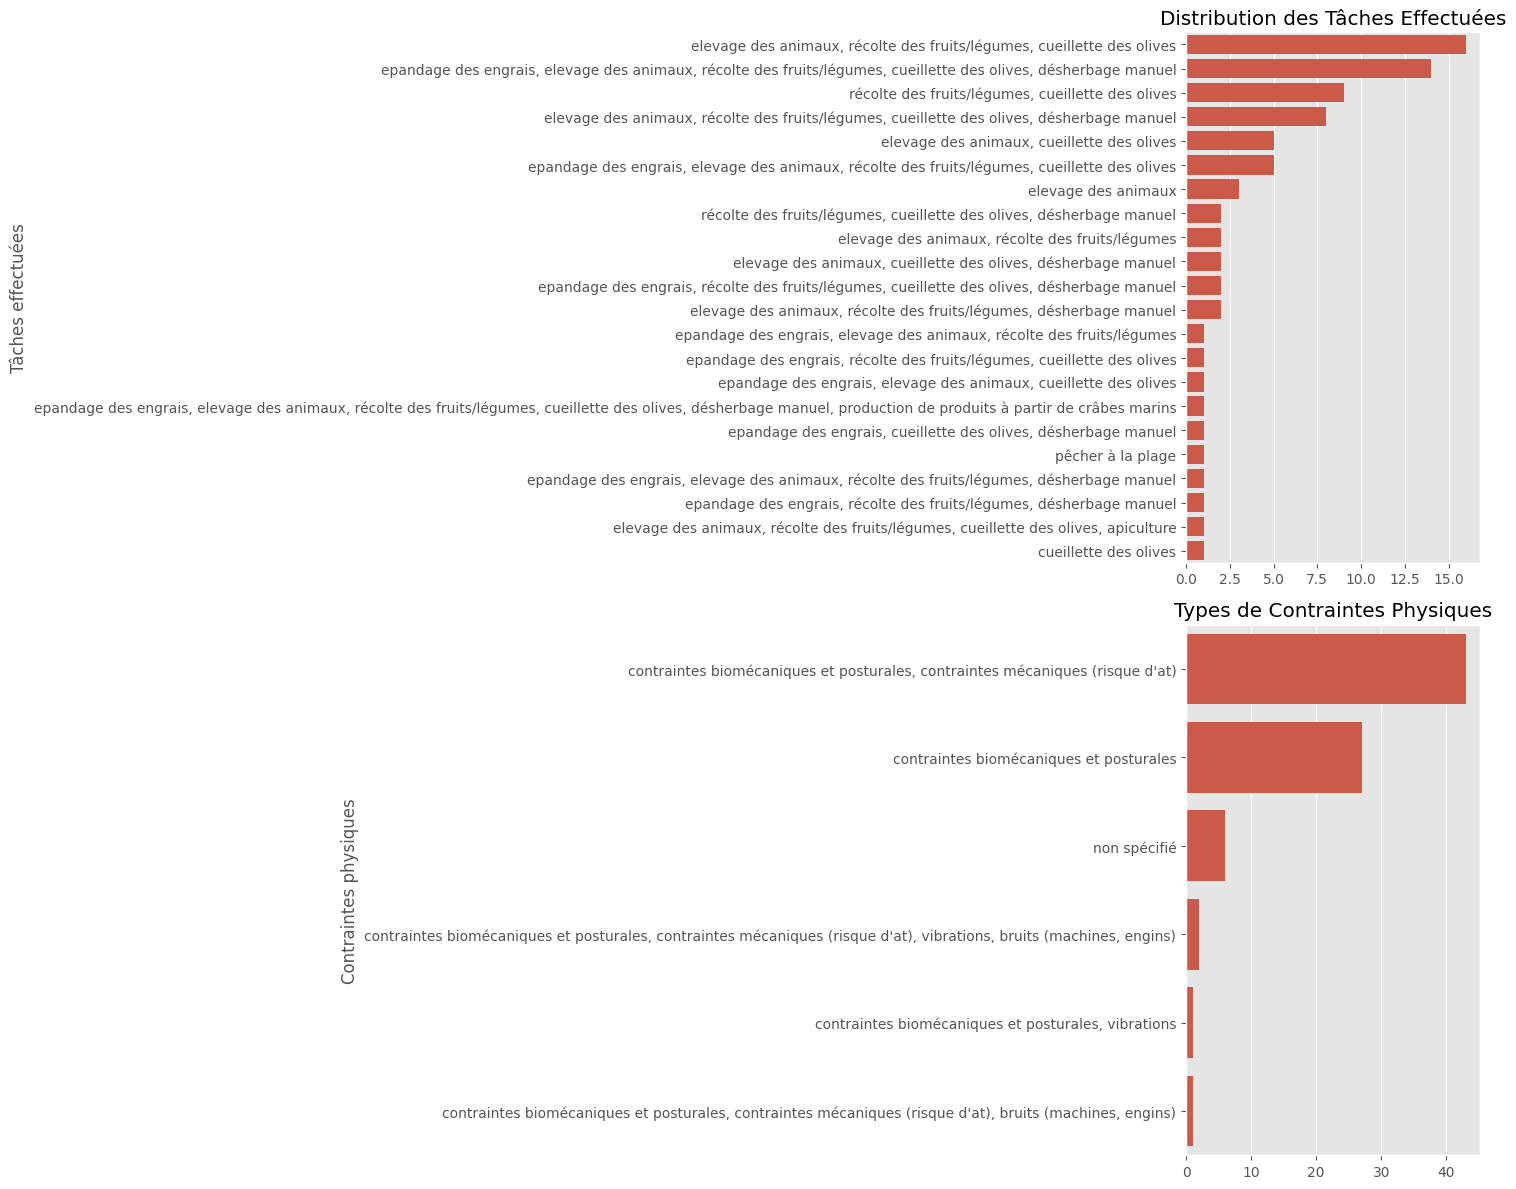

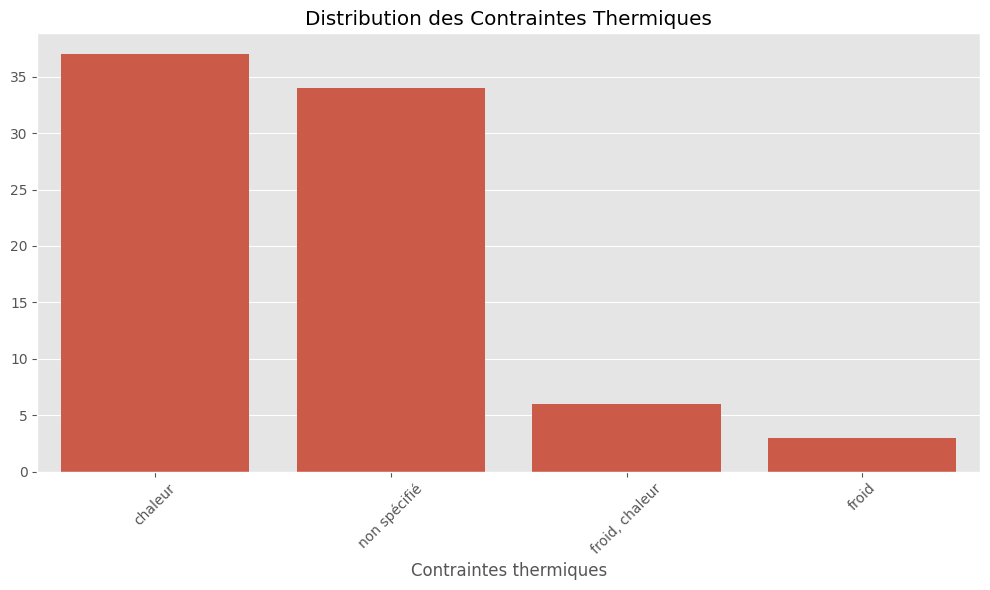

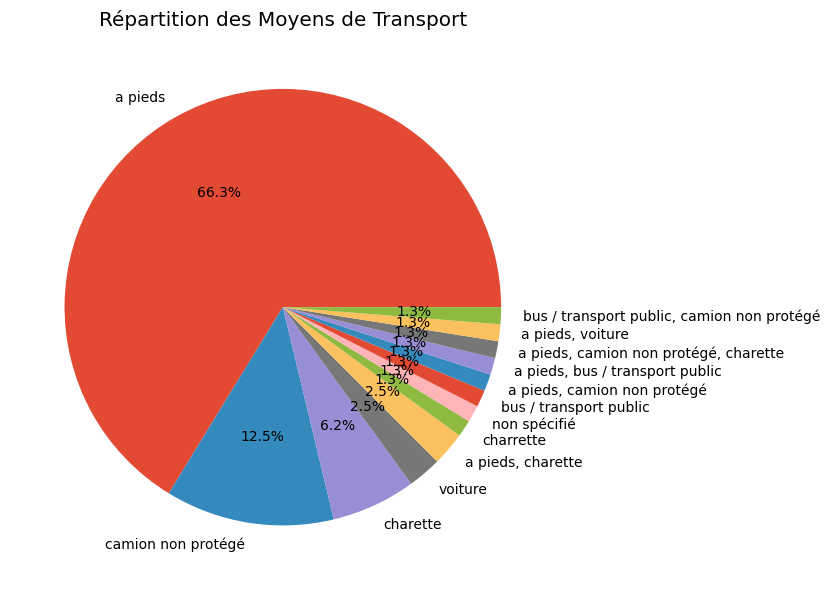

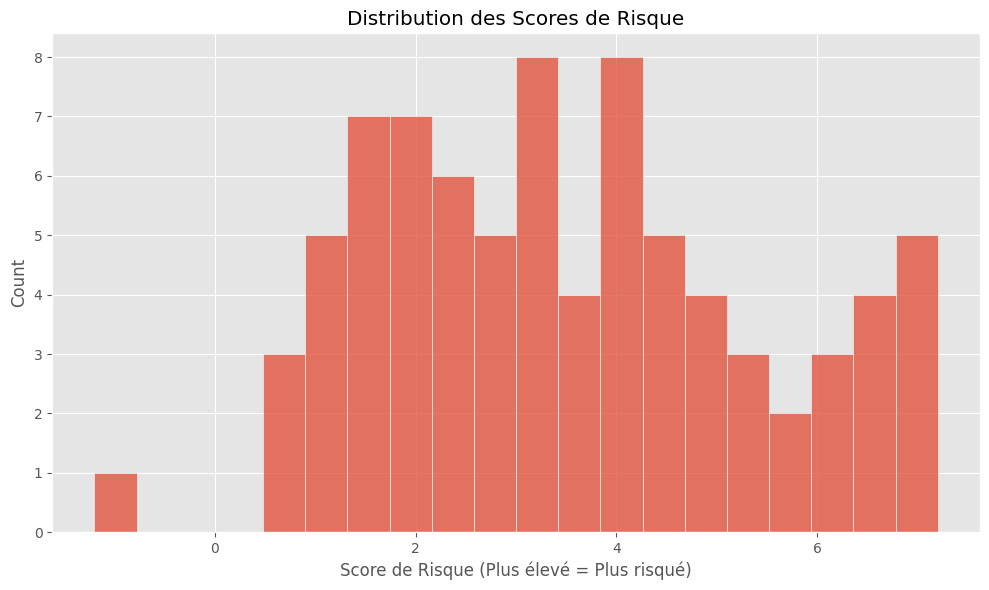

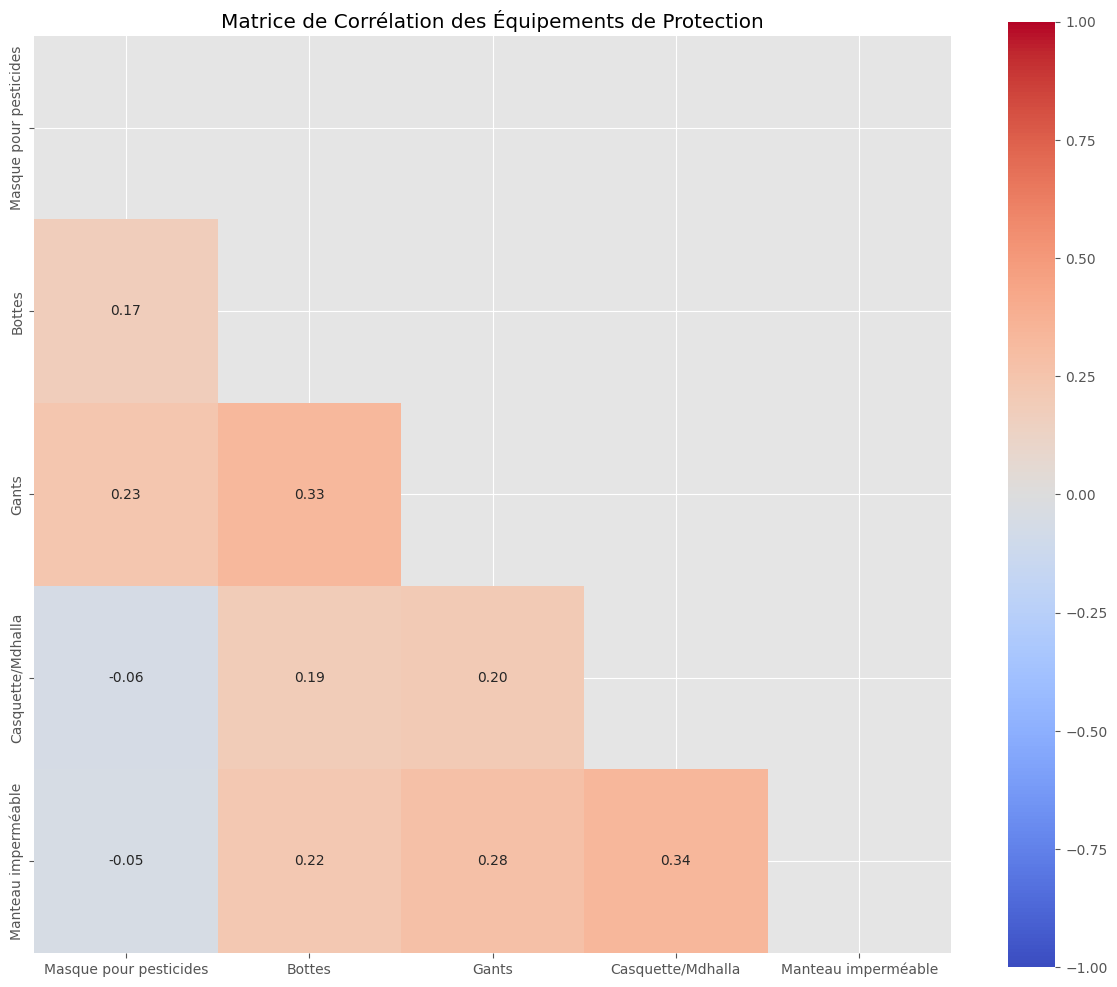


Statistiques sur l'utilisation des équipements de protection:
Manteau imperméable                                         jamais  parfois  \
Masque pour pesticides Bottes   Gants    Casquette/Mdhalla                    
jamais                 jamais   jamais   jamais               14.0      NaN   
                                         parfois               2.0      NaN   
                                         souvent               3.0      NaN   
                                         toujours              7.0      NaN   
                                parfois  jamais                2.0      NaN   
                                         parfois               1.0      NaN   
                                         toujours              1.0      NaN   
                                souvent  jamais                3.0      NaN   
                                         parfois               1.0      NaN   
                                         souvent               2.0  

N° Date de la visite Date de naissance   Age Situation maritale  \
0    1        2024-09-21        1965-01-01  60.0        célibataire   
1    2        2024-09-21               NaT   NaN             mariée   
2    3        2024-09-21        1965-01-01  60.0             mariée   
3    4        2024-09-21        1977-01-01  48.0             mariée   
4    5        2024-09-21        1982-01-06  43.0             mariée   
..  ..               ...               ...   ...                ...   
75  76        2024-10-08        1979-01-16  46.0             mariée   
76  77        2024-10-08        1976-02-20  49.0             mariée   
77  78        2024-10-08        1997-04-17  27.0             mariée   
78  79        2024-10-08        1960-01-01  65.0             mariée   
79  80        2024-10-08        1972-01-14  53.0             mariée   

    Nb enfants  Nb pers à charge  Profession du mari  Domicile  \
0          0.0               1.0        non spécifié  monastir   
1          1.0               1.0         agriculteur  monastir   
2          4.0               0.0  infirmier retraité  monastir   
3          5.0               0.0          mécanicien  monastir   
4          3.0               0.0        a l'étranger  monastir   
..         ...               ...                 ...       ...   
75         4.0               5.0           handicapé    mahdia   
76         3.0               0.0             ouvrier    mahdia   
77         3.0               0.0  ouvrier journalier    mahdia   
78         4.0               1.0        non spécifié    mahdia   
79         3.0               2.0  ouvrier journalier    mahdia   

   Niveau socio-économique  ... Examen buccodentaire  \
0             non spécifié  ...         non spécifié   
1                      bon  ...         non spécifié   
2             non spécifié  ...         non spécifié   
3                    moyen  ...         non spécifié   
4                      bon  ...         non spécifié   
..                     ...  ...                  ...   
75                   moyen  ...         non spécifié   
76                     bas  ...         non spécifié   
77                   moyen  ...         non spécifié   
78                     bas  ...         non spécifié   
79                     bas  ...         non spécifié   

   Examen des membres supérieurs              Examen du rachis  \
0                   non spécifié                  non spécifié   
1                   non spécifié                    lombalgies   
2                douleurs coudes                  non spécifié   
3                   non spécifié                  non spécifié   
4                   non spécifié              lombosciatalgies   
..                           ...                           ...   
75                  non spécifié                  non spécifié   
76                  non spécifié                  non spécifié   
77                  non spécifié  signe de la sonnette positif   
78                  non spécifié                  non spécifié   
79                  non spécifié                  non spécifié   

   Examen des téguments Examen neurologique Examen abdominal  \
0          non spécifié        non spécifié     non spécifié   
1          non spécifié        non spécifié     non spécifié   
2          non spécifié        non spécifié     non spécifié   
3          non spécifié        non spécifié     non spécifié   
4          non spécifié        non spécifié     non spécifié   
..                  ...                 ...              ...   
75         non spécifié        non spécifié     non spécifié   
76         non spécifié        non spécifié     non spécifié   
77         non spécifié        non spécifié     non spécifié   
78         non spécifié        non spécifié     non spécifié   
79         non spécifié        non spécifié     non spécifié   

                        Examen visuel         Spirométrie  \
0                        non spécifié  mauvaise exécution   
1

In [48]:
df_numeric=analyze_working_conditions(df) 
df_numeric

###  Analyse des risques par profil :

In [49]:
def analyze_advanced_risks(df):
    # 1. Calcul du score de risque initial
    def calculate_base_risk(row):
        risk_score = 0
        
        if isinstance(row['Contraintes physiques'], str):
            if 'contraintes biomécaniques' in row['Contraintes physiques'].lower():
                risk_score += 2
            if 'contraintes mécaniques' in row['Contraintes physiques'].lower():
                risk_score += 2
        
        if isinstance(row['Contraintes thermiques'], str):
            if 'chaleur' in row['Contraintes thermiques'].lower():
                risk_score += 1
            if 'froid' in row['Contraintes thermiques'].lower():
                risk_score += 1
        
        return risk_score
    
    # 2. Calcul du score de protection
    protection_cols = ["Masque pour pesticides", "Bottes", "Gants", 
                      "Casquette/Mdhalla", "Manteau imperméable"]
    
    protection_map = {
        'jamais': 0,
        'parfois': 1,
        'souvent': 2,
        'toujours': 3
    }
    
    # Création d'une copie des données
    df_numeric = df.copy()
    
    # Conversion des colonnes de protection
    for col in protection_cols:
        if col in df_numeric.columns:
            df_numeric[col] = df_numeric[col].map(protection_map)
    
    # Calcul du score de protection moyen
    df_numeric['protection_score'] = df_numeric[protection_cols].mean(axis=1)
    
    # 3. Calcul du score de risque lié au transport
    transport_risk = {
        'a pieds': 1,
        'camion non protégé': 3,
        'charette': 2,
        'voiture': 1,
        'bus / transport public': 1
    }
    
    def get_transport_risk(transport):
        if isinstance(transport, str):
            for mode, score in transport_risk.items():
                if mode in transport.lower():
                    return score
        return 1
    
    # Calcul des scores de risque
    df_numeric['transport_risk'] = df['Moyen de transport'].apply(get_transport_risk)
    df_numeric['base_risk'] = df.apply(calculate_base_risk, axis=1)
    df_numeric['Risk_Score'] = df_numeric['base_risk'] + df_numeric['transport_risk'] - df_numeric['protection_score']
    
    # Configuration du style
    plt.style.use('ggplot')
    sns.set_palette("husl")
    
    # Création de la figure
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # Configuration des boxplots
    boxplot_params = {
        'showfliers': True,
        'whis': 1.5,
        'showmeans': True,
        'meanprops': {"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"10"}
    }
    
    # Premier boxplot
    sns.boxplot(data=df_numeric, 
                x='Moyen de transport', 
                y='Risk_Score',
                ax=axes[0,0],
                **boxplot_params)
    
    sns.stripplot(data=df_numeric,
                 x='Moyen de transport',
                 y='Risk_Score',
                 color='red',
                 alpha=0.3,
                 size=4,
                 jitter=0.2,
                 ax=axes[0,0])
    
    axes[0,0].set_title('Distribution des Risques par Moyen de Transport', 
                       pad=20, fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Moyen de Transport', fontsize=12)
    axes[0,0].set_ylabel('Score de Risque', fontsize=12)
    axes[0,0].tick_params(axis='x', rotation=45, labelsize=10)
    axes[0,0].grid(True, alpha=0.3)
    
    # Deuxième boxplot
    sns.boxplot(data=df_numeric,
                x='Contraintes physiques',
                y='protection_score',
                ax=axes[0,1],
                **boxplot_params)
    
    sns.stripplot(data=df_numeric,
                 x='Contraintes physiques',
                 y='protection_score',
                 color='red',
                 alpha=0.3,
                 size=4,
                 jitter=0.2,
                 ax=axes[0,1])
    
    axes[0,1].set_title('Niveau de Protection par Type de Contrainte Physique',
                       pad=20, fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Type de Contrainte Physique', fontsize=12)
    axes[0,1].set_ylabel('Score de Protection', fontsize=12)
    axes[0,1].tick_params(axis='x', rotation=45, labelsize=10)
    axes[0,1].grid(True, alpha=0.3)
    
    # Histogrammes
    sns.histplot(data=df_numeric,
                x='protection_score',
                ax=axes[1,0],
                bins=20,
                kde=True)
    axes[1,0].set_title('Distribution des Scores de Protection',
                       pad=20, fontsize=14, fontweight='bold')
    axes[1,0].grid(True, alpha=0.3)
    
    sns.histplot(data=df_numeric,
                x='Risk_Score',
                ax=axes[1,1],
                bins=20,
                kde=True)
    axes[1,1].set_title('Distribution des Scores de Risque',
                       pad=20, fontsize=14, fontweight='bold')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout(pad=3.0)
    fig.suptitle('Analyse des Risques et des Protections', 
                fontsize=16, fontweight='bold', y=1.02)
    
    plt.show()
    
    # Statistiques
    print("\nStatistiques descriptives des scores de risque:")
    print(df_numeric['Risk_Score'].describe())
    
    print("\nMoyenne des scores de risque par moyen de transport:")
    print(df_numeric.groupby('Moyen de transport')['Risk_Score'].mean().sort_values(ascending=False))
    
    return df_numeric

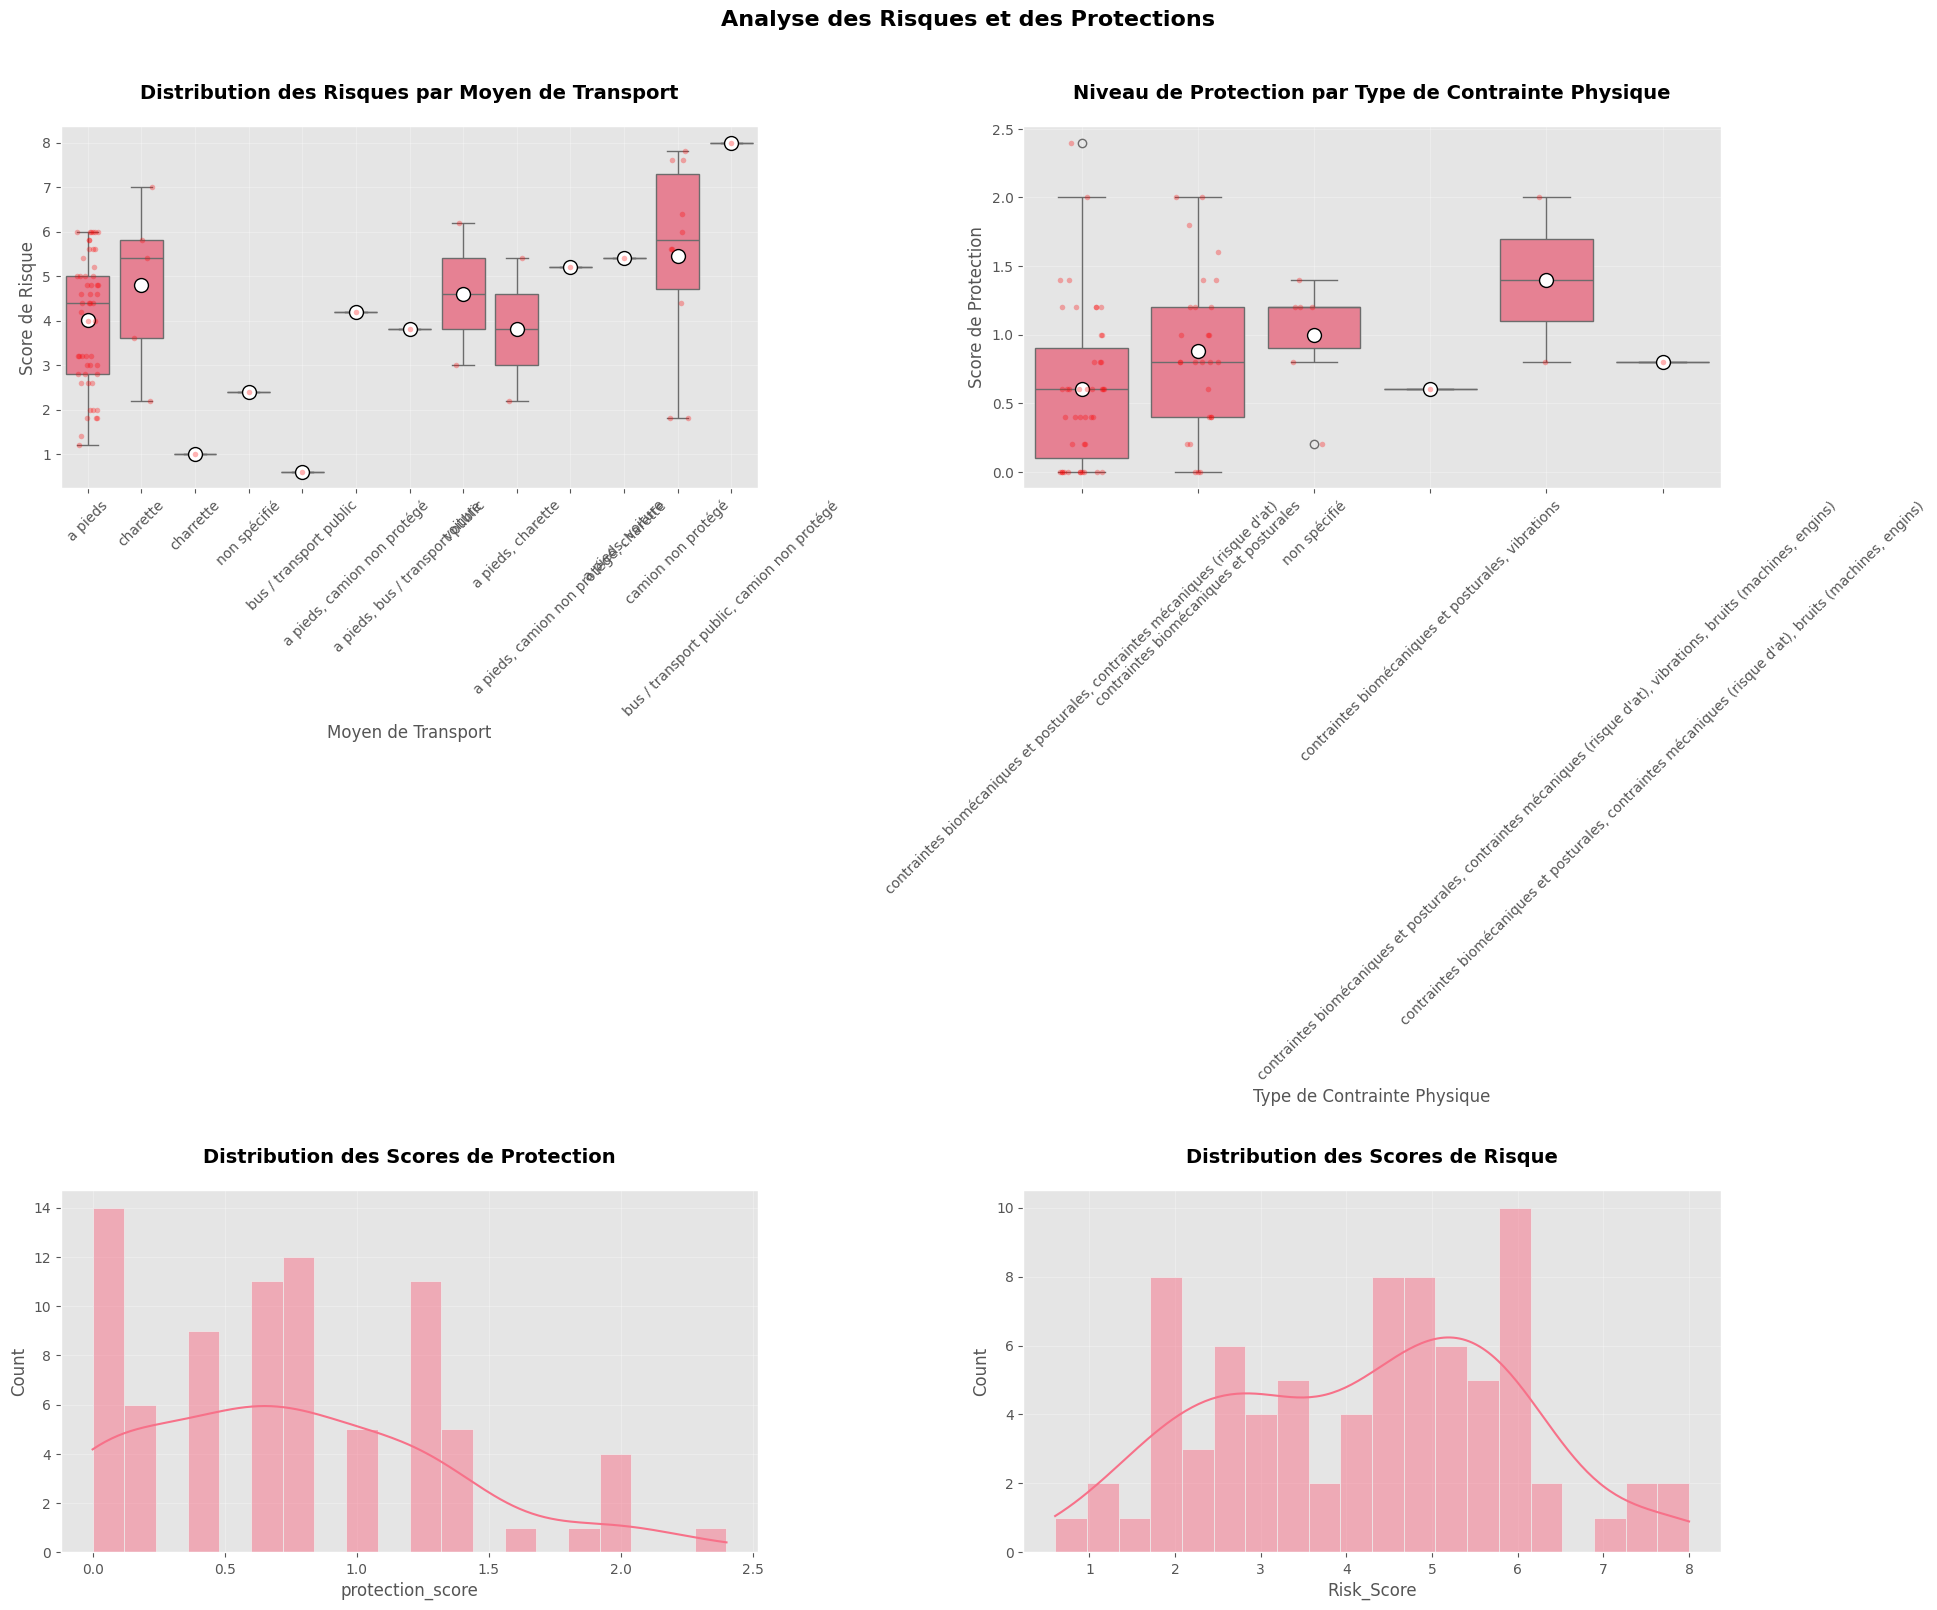


Statistiques descriptives des scores de risque:
count    80.000000
mean      4.237500
std       1.740099
min       0.600000
25%       2.800000
50%       4.400000
75%       5.600000
max       8.000000
Name: Risk_Score, dtype: float64

Moyenne des scores de risque par moyen de transport:
Moyen de transport
bus / transport public, camion non protégé    8.000000
camion non protégé                            5.460000
a pieds, voiture                              5.400000
a pieds, camion non protégé, charette         5.200000
charette                                      4.800000
voiture                                       4.600000
a pieds, camion non protégé                   4.200000
a pieds                                       4.018868
a pieds, charette                             3.800000
a pieds, bus / transport public               3.800000
non spécifié                                  2.400000
charrette                                     1.000000
bus / transport public           

N° Date de la visite Date de naissance   Age Situation maritale  \
0    1        2024-09-21        1965-01-01  60.0        célibataire   
1    2        2024-09-21               NaT   NaN             mariée   
2    3        2024-09-21        1965-01-01  60.0             mariée   
3    4        2024-09-21        1977-01-01  48.0             mariée   
4    5        2024-09-21        1982-01-06  43.0             mariée   
..  ..               ...               ...   ...                ...   
75  76        2024-10-08        1979-01-16  46.0             mariée   
76  77        2024-10-08        1976-02-20  49.0             mariée   
77  78        2024-10-08        1997-04-17  27.0             mariée   
78  79        2024-10-08        1960-01-01  65.0             mariée   
79  80        2024-10-08        1972-01-14  53.0             mariée   

    Nb enfants  Nb pers à charge  Profession du mari  Domicile  \
0          0.0               1.0        non spécifié  monastir   
1          1.0               1.0         agriculteur  monastir   
2          4.0               0.0  infirmier retraité  monastir   
3          5.0               0.0          mécanicien  monastir   
4          3.0               0.0        a l'étranger  monastir   
..         ...               ...                 ...       ...   
75         4.0               5.0           handicapé    mahdia   
76         3.0               0.0             ouvrier    mahdia   
77         3.0               0.0  ouvrier journalier    mahdia   
78         4.0               1.0        non spécifié    mahdia   
79         3.0               2.0  ouvrier journalier    mahdia   

   Niveau socio-économique  ... Examen des téguments Examen neurologique  \
0             non spécifié  ...         non spécifié        non spécifié   
1                      bon  ...         non spécifié        non spécifié   
2             non spécifié  ...         non spécifié        non spécifié   
3                    moyen  ...         non spécifié        non spécifié   
4                      bon  ...         non spécifié        non spécifié   
..                     ...  ...                  ...                 ...   
75                   moyen  ...         non spécifié        non spécifié   
76                     bas  ...         non spécifié        non spécifié   
77                   moyen  ...         non spécifié        non spécifié   
78                     bas  ...         non spécifié        non spécifié   
79                     bas  ...         non spécifié        non spécifié   

   Examen abdominal                      Examen visuel         Spirométrie  \
0      non spécifié                       non spécifié  mauvaise exécution   
1      non spécifié  pterygion bilatéral - flou visuel           non faite   
2      non spécifié                        flou visuel       interprétable   
3      non spécifié                                bav           non faite   
4      non spécifié                    pterygion droit       interprétable   
..              ...                                ...                 ...   
75     non spécifié                       non spécifié           non faite   
76     non spécifié                       non spécifié           non faite   
77     non spécifié                       non spécifié           non faite   
78     non spécifié                        flou visuel           non faite   
79     non spécifié    mouches volatiles + flou visuel           non faite   

   Interprétation Spiro protection_score  transport_risk base_risk Risk_Score  
0                     -              0.4               1         5        5.6  
1                     -              0.4               2         2        3.6  
2                     -              2.0               1         2        1.0  
3                     -              0.8               1         5        5.2  
4               normale              0.4               1         4        4.6  
..                  ...     

In [50]:
analyze_advanced_risks(df)

### ✔️ Habitudes alimentaires et consommation de tabac

In [123]:
# Statistiques sur les colonnes catégorielles
profil_categories = ["Tabagisme", "Neffa", "Fumées de Tabouna" ]
for col in profil_categories:
    print(f"Statistiques pour {col}:")
    print(df[col].value_counts(dropna=False))  # Inclut NaN
    print("\n")

Statistiques pour Tabagisme:
Tabagisme
non             63
passif          13
non spécifié     2
oui              2
Name: count, dtype: int64


Statistiques pour Neffa:
Neffa
non             78
non spécifié     2
Name: count, dtype: int64


Statistiques pour Fumées de Tabouna:
Fumées de Tabouna
oui             58
non             21
non spécifié     1
Name: count, dtype: int64




C:\Users\MSI\AppData\Local\Temp\ipykernel_13848\2471294446.py:27: UserWarning: Glyph 128684 (\N{SMOKING SYMBOL}) missing from current font.
  plt.tight_layout()
C:\Users\MSI\AppData\Local\Temp\ipykernel_13848\2471294446.py:27: UserWarning: Glyph 127807 (\N{HERB}) missing from current font.
  plt.tight_layout()
C:\Users\MSI\AppData\Local\Temp\ipykernel_13848\2471294446.py:27: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  plt.tight_layout()
C:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128684 (\N{SMOKING SYMBOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127807 (\N{HERB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWa

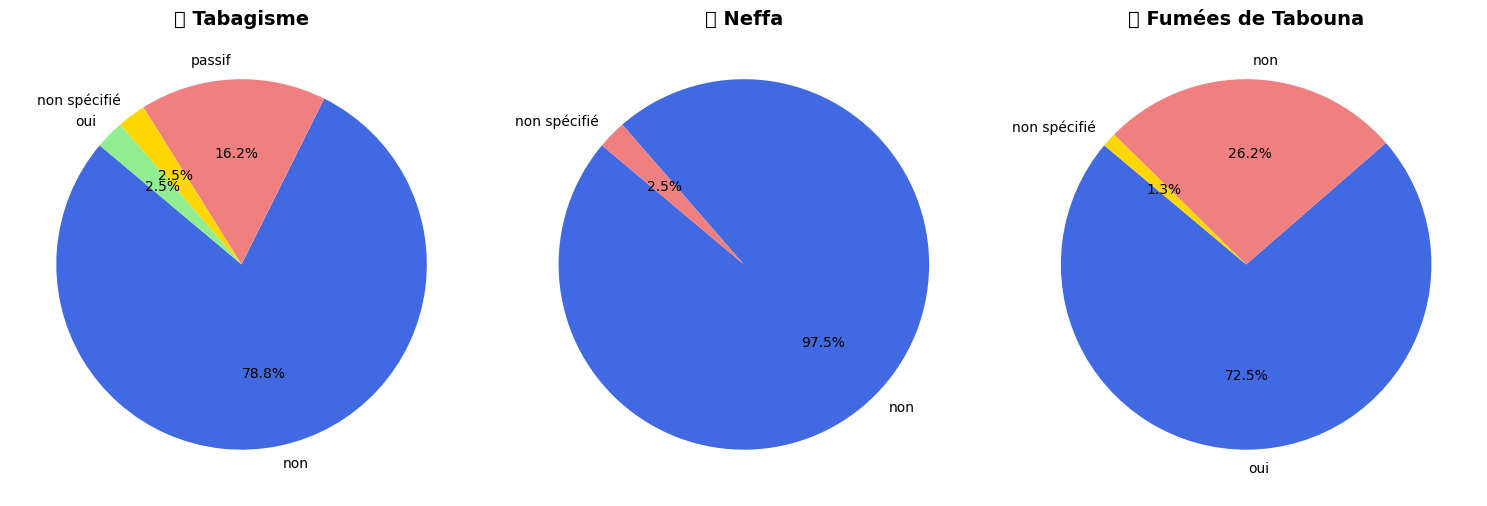

In [124]:
import matplotlib.pyplot as plt

# Données des statistiques
tabagisme = {"non": 63, "passif": 13, "non spécifié": 2, "oui": 2}
neffa = {"non": 78, "non spécifié": 2}
fumées_tabouna = {"oui": 58, "non": 21, "non spécifié": 1}

# Création de la figure avec 3 sous-graphiques
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Définition des couleurs
colors = ["royalblue", "lightcoral", "gold", "lightgreen"]

# 1️⃣ Tabagisme
axes[0].pie(tabagisme.values(), labels=tabagisme.keys(), autopct='%1.1f%%', colors=colors, startangle=140)
axes[0].set_title("🚬 Tabagisme", fontsize=14, fontweight="bold")

# 2️⃣ Neffa
axes[1].pie(neffa.values(), labels=neffa.keys(), autopct='%1.1f%%', colors=colors[:2], startangle=140)
axes[1].set_title("🌿 Neffa", fontsize=14, fontweight="bold")

# 3️⃣ Fumées de Tabouna
axes[2].pie(fumées_tabouna.values(), labels=fumées_tabouna.keys(), autopct='%1.1f%%', colors=colors[:3], startangle=140)
axes[2].set_title("🔥 Fumées de Tabouna", fontsize=14, fontweight="bold")

# Ajustement de l'affichage
plt.tight_layout()
plt.show()


### ✔️ Maladies professionnelles et symptômes médicaux

In [52]:
# Statistiques sur les colonnes catégorielles
profil_categories = ["Troubles gynécologiques", "Troubles cardio-respiratoires", "Troubles cognitifs",
    "Troubles neurologiques", "Troubles cutanés/phanères", 
    "Examen cardiovasculaire et pulmonaire", "Examen tête et cou", "Examen buccodentaire",
    "Examen des membres supérieurs", "Examen du rachis", "Examen des téguments",
    "Examen neurologique", "Examen abdominal", "Examen visuel",
    "Spirométrie", "Interprétation Spiro"]
for col in profil_categories:
    print(f"Statistiques pour {col}:")
    print(df[col].value_counts(dropna=False))  # Inclut NaN
    print("\n")

Statistiques pour Troubles gynécologiques:
Troubles gynécologiques
non spécifié                                 74
cycles irréguliers                            2
dysménorrhée                                  1
métrorragies                                  1
aménorrhée depuis l'âge de 30 ans             1
douleur pariétale à la palpation mammaire     1
Name: count, dtype: int64


Statistiques pour Troubles cardio-respiratoires:
Troubles cardio-respiratoires
non spécifié                                                                          47
dyspnée d'effort                                                                       4
palpitations                                                                           3
dyspnée                                                                                3
dyspnée d'effort mmrc 2                                                                2
varices mi                                                                             2
dysp

In [53]:
# Définition des groupes de variables
troubles = ["Troubles gynécologiques", "Troubles cardio-respiratoires", 
            "Troubles cognitifs", "Troubles neurologiques", "Troubles cutanés/phanères"]
    
examens = ["Examen cardiovasculaire et pulmonaire", "Examen tête et cou", 
          "Examen buccodentaire", "Examen des membres supérieurs", 
            "Examen du rachis", "Examen des téguments", "Examen neurologique", 
            "Examen abdominal", "Examen visuel"]
    
tests = ["Spirométrie", "Interprétation Spiro"]

### Distribution des troubles de santé

C:\Users\MSI\AppData\Local\Temp\ipykernel_24444\2009618631.py:9: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  troubles_counts = df[troubles].apply(pd.value_counts).transpose()
C:\Users\MSI\AppData\Local\Temp\ipykernel_24444\2009618631.py:9: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  troubles_counts = df[troubles].apply(pd.value_counts).transpose()
C:\Users\MSI\AppData\Local\Temp\ipykernel_24444\2009618631.py:9: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  troubles_counts = df[troubles].apply(pd.value_counts).transpose()
C:\Users\MSI\AppData\Local\Temp\ipykernel_24444\2009618631.py:9: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tr

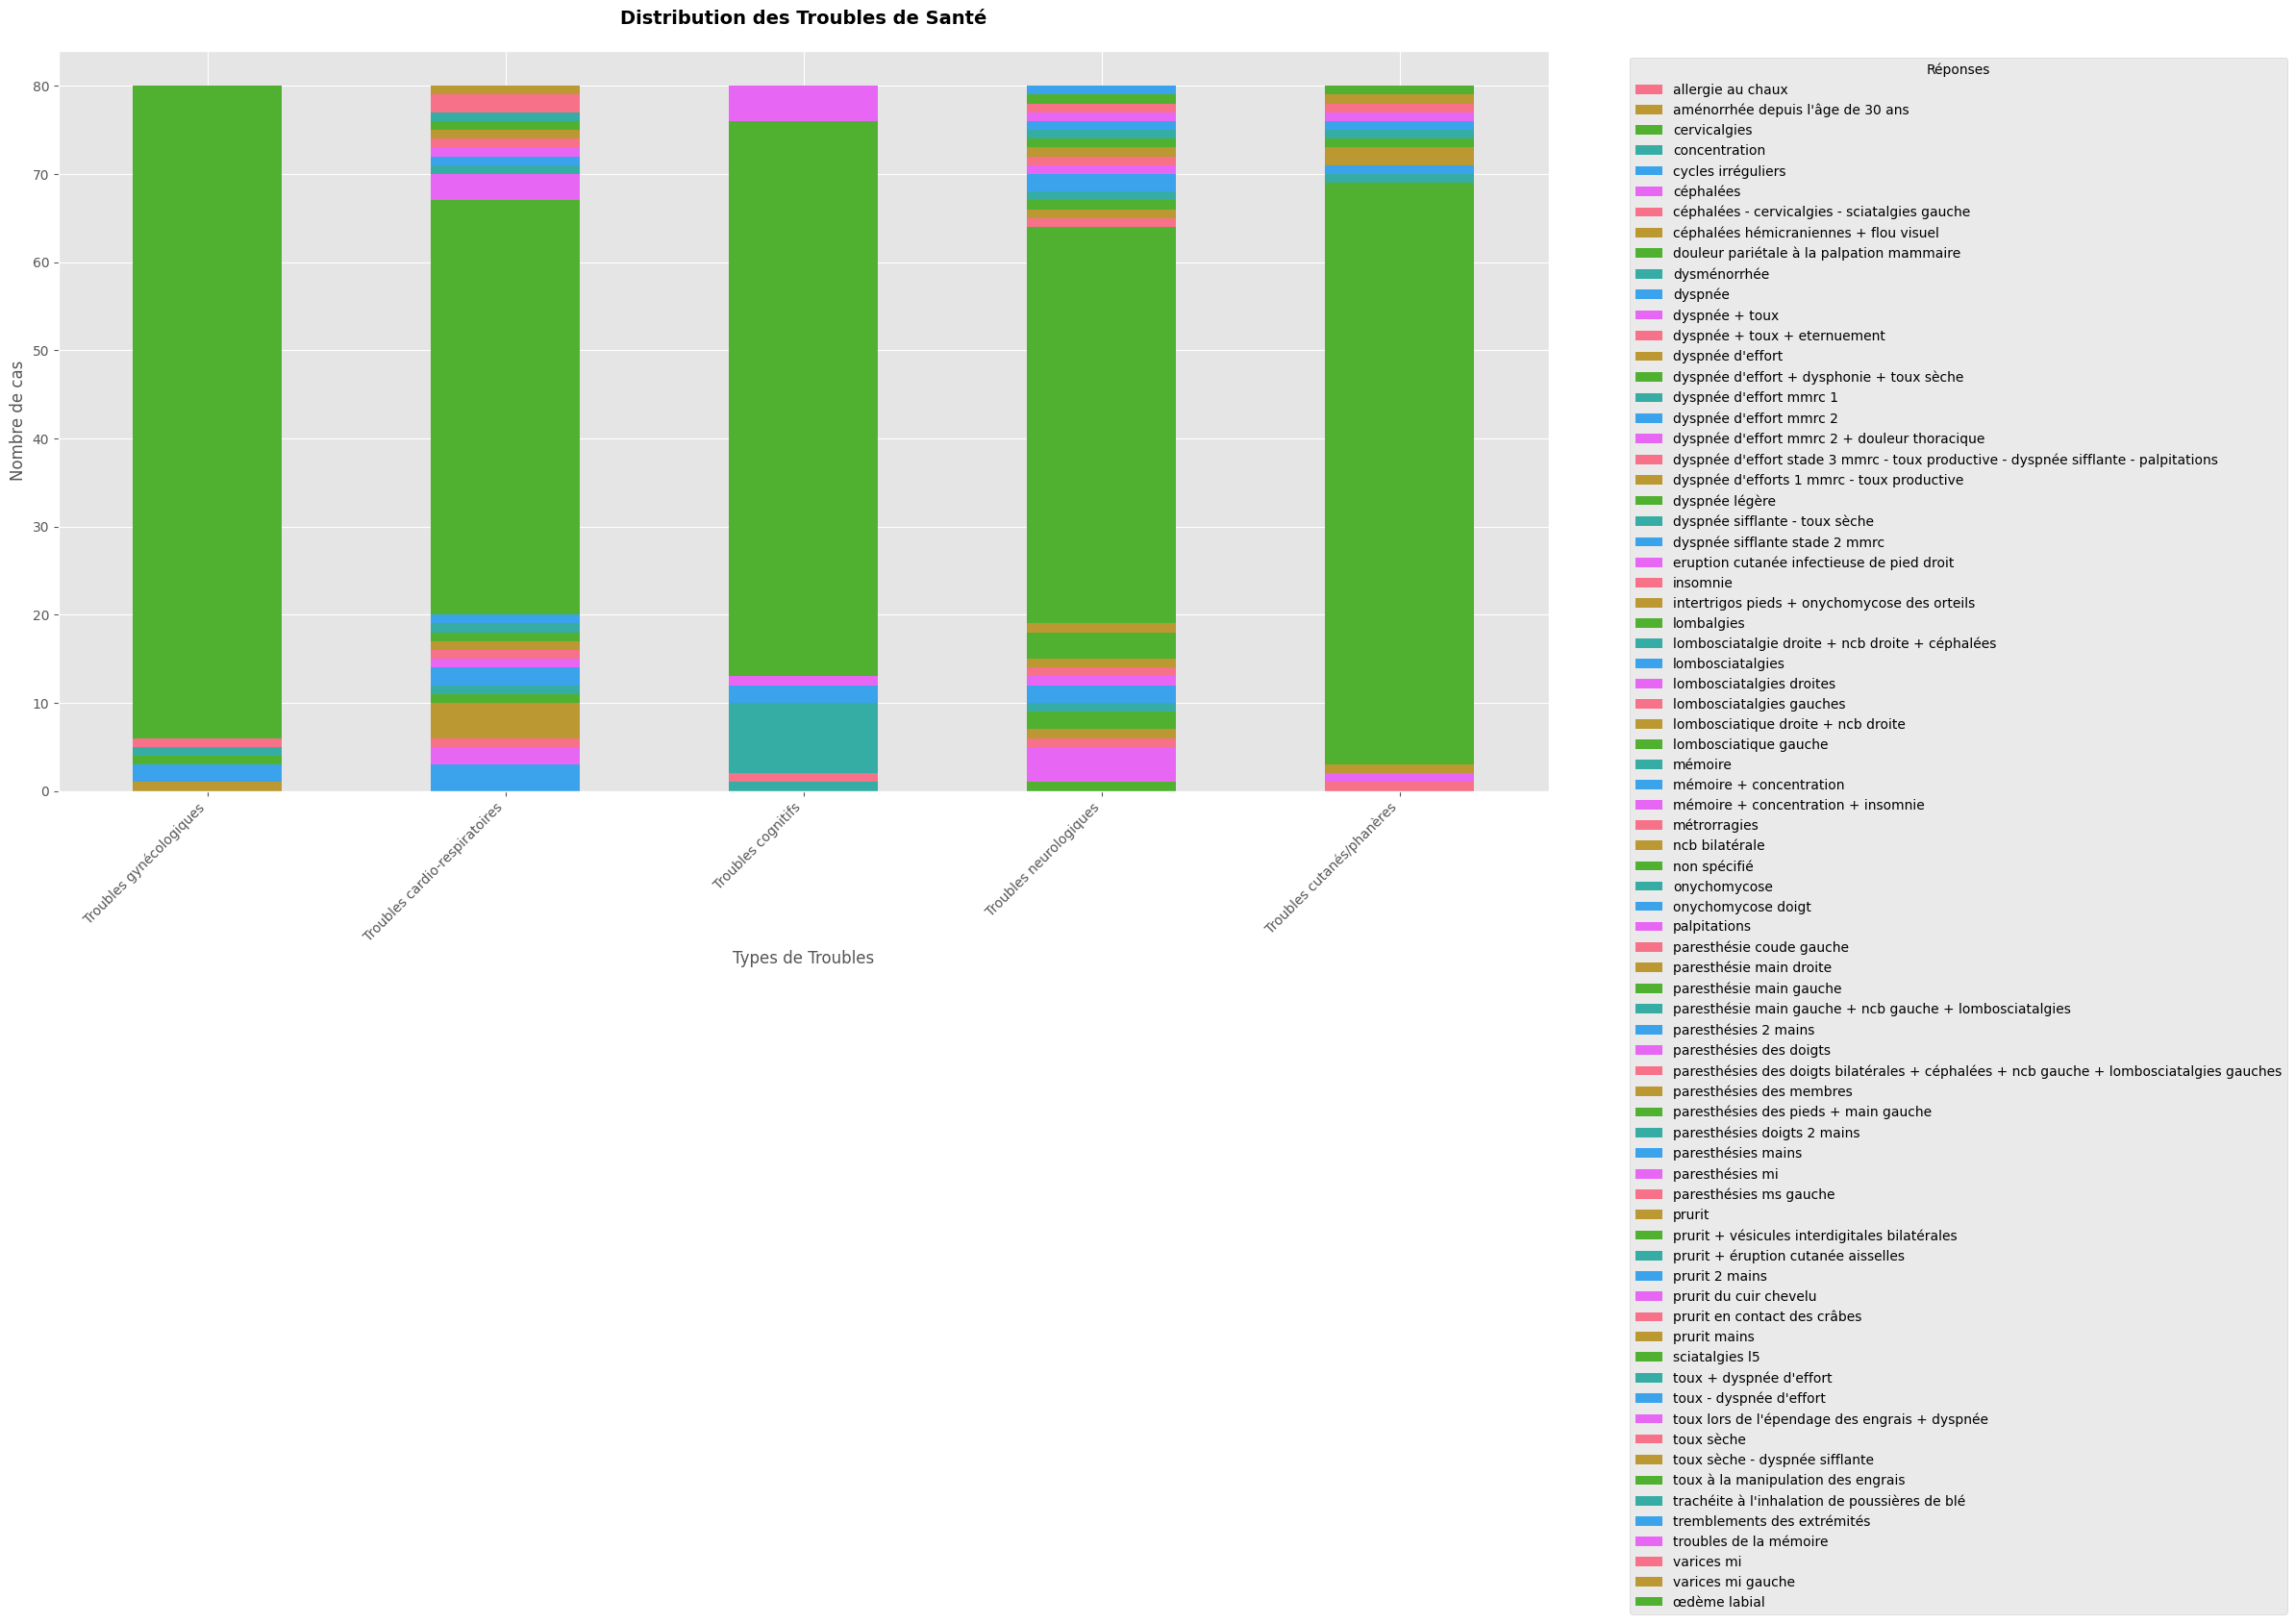

In [54]:
# Configuration du style
plt.style.use('ggplot')
sns.set_palette("husl")

# Création de la figure et des axes
fig, ax = plt.subplots(figsize=(20, 10))  # Supprime l'ancien plt.figure()

# 1. Distribution des troubles
troubles_counts = df[troubles].apply(pd.value_counts).transpose()
troubles_counts.plot(kind='bar', stacked=True, ax=ax)  # Spécifier ax ici

# Titres et labels
ax.set_title('Distribution des Troubles de Santé', pad=20, fontsize=14, fontweight='bold')
ax.set_xlabel('Types de Troubles')
ax.set_ylabel('Nombre de cas')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.legend(title='Réponses', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()  # Afficher correctement le graphe


(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, 'Troubles gynécologiques'),
  Text(0, 1.5, 'Troubles cardio-respiratoires'),
  Text(0, 2.5, 'Troubles cognitifs'),
  Text(0, 3.5, 'Troubles neurologiques'),
  Text(0, 4.5, 'Troubles cutanés/phanères')])

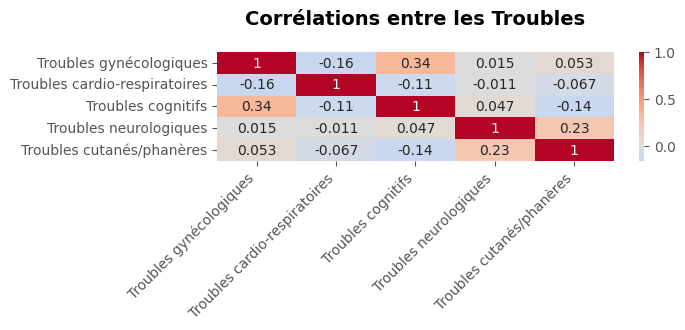

In [55]:
# 2. Heatmap des corrélations entre les troubles
plt.subplot(3, 1, 2)
correlation_matrix = df[troubles].apply(lambda x: pd.Categorical(x).codes).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Corrélations entre les Troubles', pad=20, fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

C:\Users\MSI\AppData\Local\Temp\ipykernel_24444\408103408.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  examens_counts = df[examens].apply(pd.value_counts).transpose()
C:\Users\MSI\AppData\Local\Temp\ipykernel_24444\408103408.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  examens_counts = df[examens].apply(pd.value_counts).transpose()
C:\Users\MSI\AppData\Local\Temp\ipykernel_24444\408103408.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  examens_counts = df[examens].apply(pd.value_counts).transpose()
C:\Users\MSI\AppData\Local\Temp\ipykernel_24444\408103408.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  examens_coun

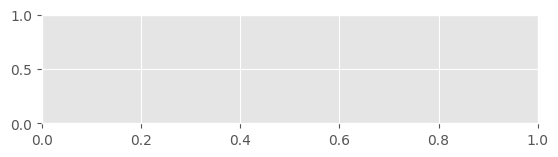

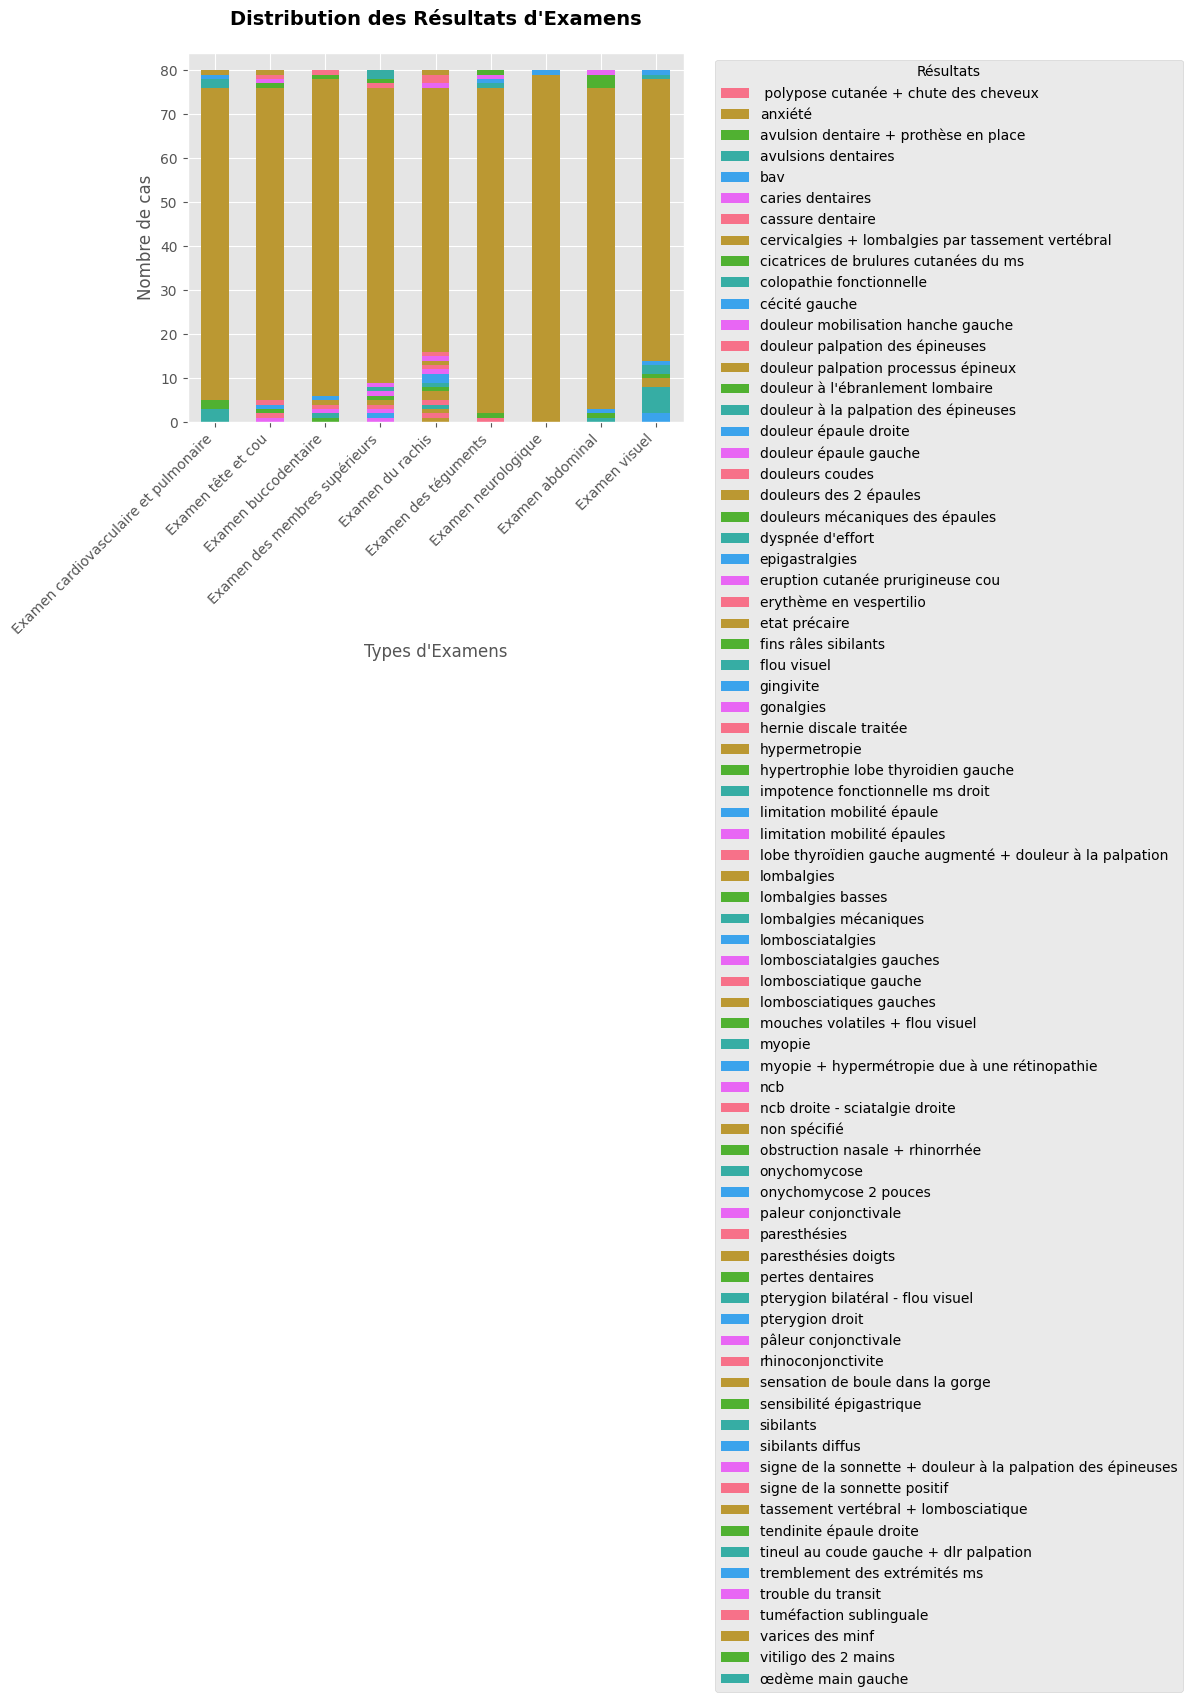

In [56]:
# 3. Distribution des résultats d'examens
plt.subplot(3, 1, 3)
examens_counts = df[examens].apply(pd.value_counts).transpose()
examens_counts.plot(kind='bar', stacked=True)
plt.title('Distribution des Résultats d\'Examens', pad=20, fontsize=14, fontweight='bold')
plt.xlabel('Types d\'Examens')
plt.ylabel('Nombre de cas')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Résultats', bbox_to_anchor=(1.05, 1), loc='upper left')
    
plt.tight_layout(pad=3.0)
plt.show()

### Analyse des relations entre troubles et examens

In [130]:
# Initialisation des résultats
results = []

# Analyse des relations
for trouble in troubles:
    for examen in examens:
        contingency = pd.crosstab(df[trouble], df[examen])
        chi2, p_value, _, _ = chi2_contingency(contingency)
        if p_value < 0.05:
            results.append({
                "Trouble": trouble,
                "Examen": examen,
                "p-value": p_value,
                "Table de contingence": contingency
            })

# Créer un DataFrame pour les résultats significatifs
results_df = pd.DataFrame(results)

# Afficher les résultats
print("\nRésultats des relations significatives :")
print(results_df[["Trouble", "Examen", "p-value"]])

# Afficher les tables de contingence pour chaque relation
for idx, row in results_df.iterrows():
    print(f"\nTable de contingence entre {row['Trouble']} et {row['Examen']}:")
    print(row["Table de contingence"])


Résultats des relations significatives :
                          Trouble                         Examen       p-value
0         Troubles gynécologiques           Examen buccodentaire  1.527437e-04
1         Troubles gynécologiques               Examen du rachis  6.696627e-03
2         Troubles gynécologiques            Examen neurologique  6.583687e-11
3         Troubles gynécologiques                  Examen visuel  3.086020e-05
4   Troubles cardio-respiratoires             Examen tête et cou  2.297862e-04
5   Troubles cardio-respiratoires  Examen des membres supérieurs  3.517768e-05
6   Troubles cardio-respiratoires               Examen du rachis  3.968760e-03
7   Troubles cardio-respiratoires           Examen des téguments  1.427724e-09
8              Troubles cognitifs             Examen tête et cou  1.190284e-12
9              Troubles cognitifs           Examen buccodentaire  1.624550e-03
10             Troubles cognitifs               Examen du rachis  4.068625e-03
11        

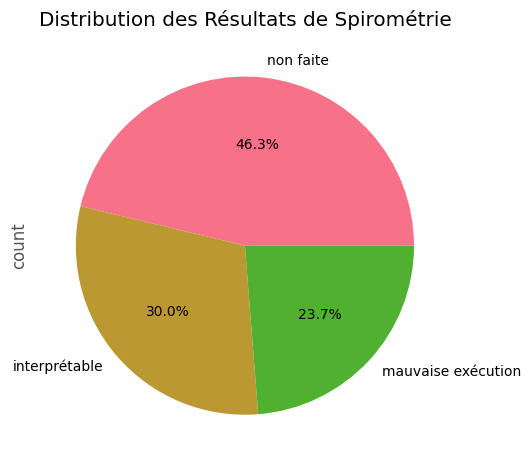

In [57]:
if "Spirométrie" in df.columns and "Interprétation Spiro" in df.columns:
        plt.figure(figsize=(12, 6))
        
        # Distribution des résultats de spirométrie
        plt.subplot(1, 2, 1)
        df["Spirométrie"].value_counts().plot(kind='pie', autopct='%1.1f%%')
        plt.title('Distribution des Résultats de Spirométrie')
      

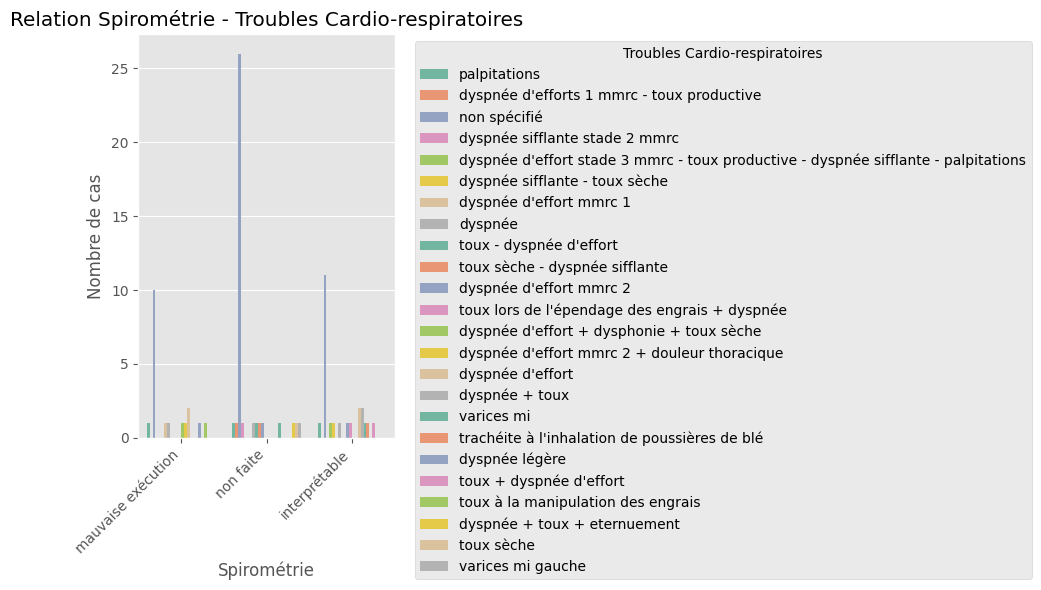

In [58]:
# Assurez-vous que les colonnes existent et sont correctement formatées
if "Spirométrie" in df.columns and "Troubles cardio-respiratoires" in df.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x="Spirométrie", hue="Troubles cardio-respiratoires", palette="Set2")
    plt.title('Relation Spirométrie - Troubles Cardio-respiratoires')
    plt.xticks(rotation=45, ha='right')  # Rotation des étiquettes pour améliorer la lisibilité
    plt.xlabel('Spirométrie')
    plt.ylabel('Nombre de cas')
    plt.legend(title='Troubles Cardio-respiratoires', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("Les colonnes 'Spirométrie' ou 'Troubles cardio-respiratoires' n'existent pas dans le DataFrame.")

In [59]:
 # Statistiques sur la spirométrie
print("\nStatistiques sur la spirométrie :")
print("\nDistribution des résultats de spirométrie :")
print(df["Spirométrie"].value_counts(normalize=True))
        
if "Troubles cardio-respiratoires" in df.columns:
    contingency = pd.crosstab(df["Spirométrie"], 
                            df["Troubles cardio-respiratoires"])
    chi2, p_value, _, _ = chi2_contingency(contingency)
    print("\nRelation entre Spirométrie et Troubles cardio-respiratoires:")
    print(f"p-value : {p_value:.4f}")
    print("\nTable de contingence :")
    print(contingency)


Statistiques sur la spirométrie :

Distribution des résultats de spirométrie :
Spirométrie
non faite             0.4625
interprétable         0.3000
mauvaise exécution    0.2375
Name: proportion, dtype: float64

Relation entre Spirométrie et Troubles cardio-respiratoires:
p-value : 0.4046

Table de contingence :
Troubles cardio-respiratoires  dyspnée  dyspnée + toux  \
Spirométrie                                              
interprétable                        1               2   
mauvaise exécution                   1               0   
non faite                            1               0   

Troubles cardio-respiratoires  dyspnée + toux + eternuement  dyspnée d'effort  \
Spirométrie                                                                     
interprétable                                             0                 2   
mauvaise exécution                                        0                 2   
non faite                                                 1           

### ✔️ Antécédents médicaux et accidents de travail

### Statistiques sur les colonnes catégorielles

In [60]:
profil_categories = ["Antécédents familiaux", "Antécédent personnels: chirurgicaux", "AT en milieu agricole",
    "Mécanisme AT", "Antécédents gynéco", "Professions antérieures"]
for col in profil_categories:
    print(f"Statistiques pour {col}:")
    print(df[col].value_counts(dropna=False))  # Inclut NaN
    print("\n") 

Statistiques pour Antécédents familiaux:
Antécédents familiaux
non spécifié                                                      15
aucun                                                             13
hta, diabète                                                       8
hta, diabète, cardiopathies                                        6
hta                                                                5
hta, cardiopathies                                                 4
tumeur maligne                                                     4
cardiopathies                                                      3
diabète                                                            3
hta, diabète, dysthyroidie                                         2
cardiopathies, tumeur maligne                                      2
hémopathie maligne                                                 1
hta, rhumatisme + insuffisance rénale                              1
hta, diabète, dyslipidémie, asthme aller

### Visualisation des antécédents médicaux

C:\Users\MSI\AppData\Local\Temp\ipykernel_24444\658652063.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(pad=5.0)  # Augmenter le padding pour éviter les chevauchements


<Figure size 2500x1000 with 0 Axes>

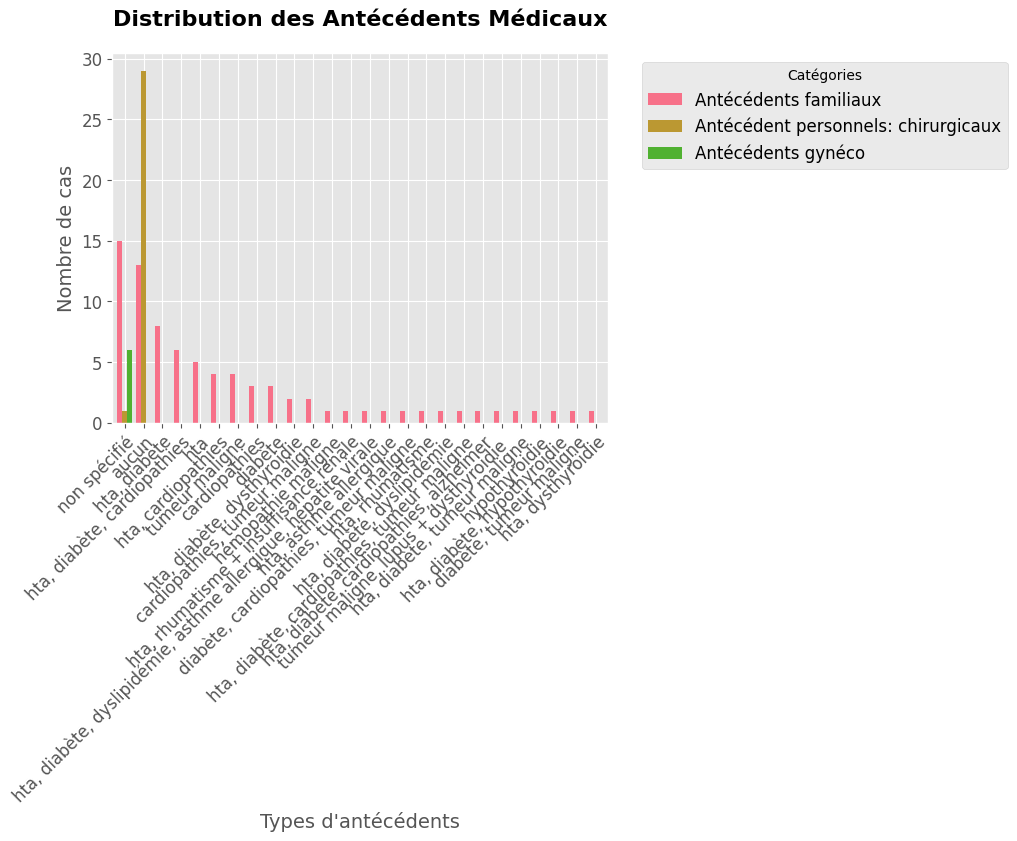

In [61]:
# Configuration du style
plt.style.use('ggplot')
sns.set_palette("husl")

# Création de la figure principale avec une taille plus grande
plt.figure(figsize=(25, 10))  # Augmenter la largeur et la hauteur de la figure

# Distribution des antécédents médicaux
antecedents_dist = pd.DataFrame()

for col in ["Antécédents familiaux", "Antécédent personnels: chirurgicaux", "Antécédents gynéco"]:
    if col in df.columns:
        # Compter les valeurs non nulles
        counts = df[col].value_counts()
        antecedents_dist[col] = counts

# Ajuster l'espacement entre les barres
bar_width = 0.8  # Largeur des barres
antecedents_dist.plot(kind='bar', width=bar_width, stacked=False)

plt.title('Distribution des Antécédents Médicaux', pad=20, fontsize=16, fontweight='bold')
plt.xlabel('Types d\'antécédents', fontsize=14)
plt.ylabel('Nombre de cas', fontsize=14)

# Ajouter un espacement entre les étiquettes
plt.xticks(rotation=45, ha='right', fontsize=12, rotation_mode='anchor')  # Rotation et alignement des étiquettes
plt.yticks(fontsize=12)
plt.legend(title='Catégories', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Ajuster l'espacement autour de la figure
plt.tight_layout(pad=5.0)  # Augmenter le padding pour éviter les chevauchements
plt.show()

### Analyse des accidents de travail

<Figure size 2000x800 with 0 Axes>

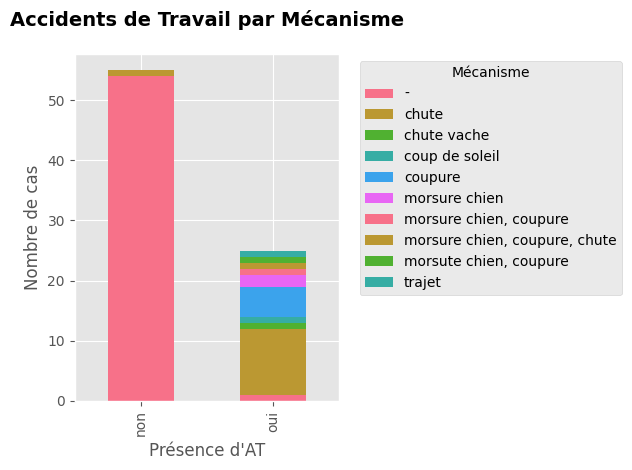

In [62]:
# Analyse des accidents de travail
plt.figure(figsize=(20, 8))

if "AT en milieu agricole" in df.columns and "Mécanisme AT" in df.columns:
    # Créer un tableau croisé
    at_mecanism = pd.crosstab(df["AT en milieu agricole"], df["Mécanisme AT"])
    at_mecanism.plot(kind='bar', stacked=True)
    plt.title('Accidents de Travail par Mécanisme', pad=20, fontsize=14, fontweight='bold')
    plt.xlabel('Présence d\'AT')
    plt.ylabel('Nombre de cas')
    plt.legend(title='Mécanisme', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show() 

### Analyse des professions antérieures

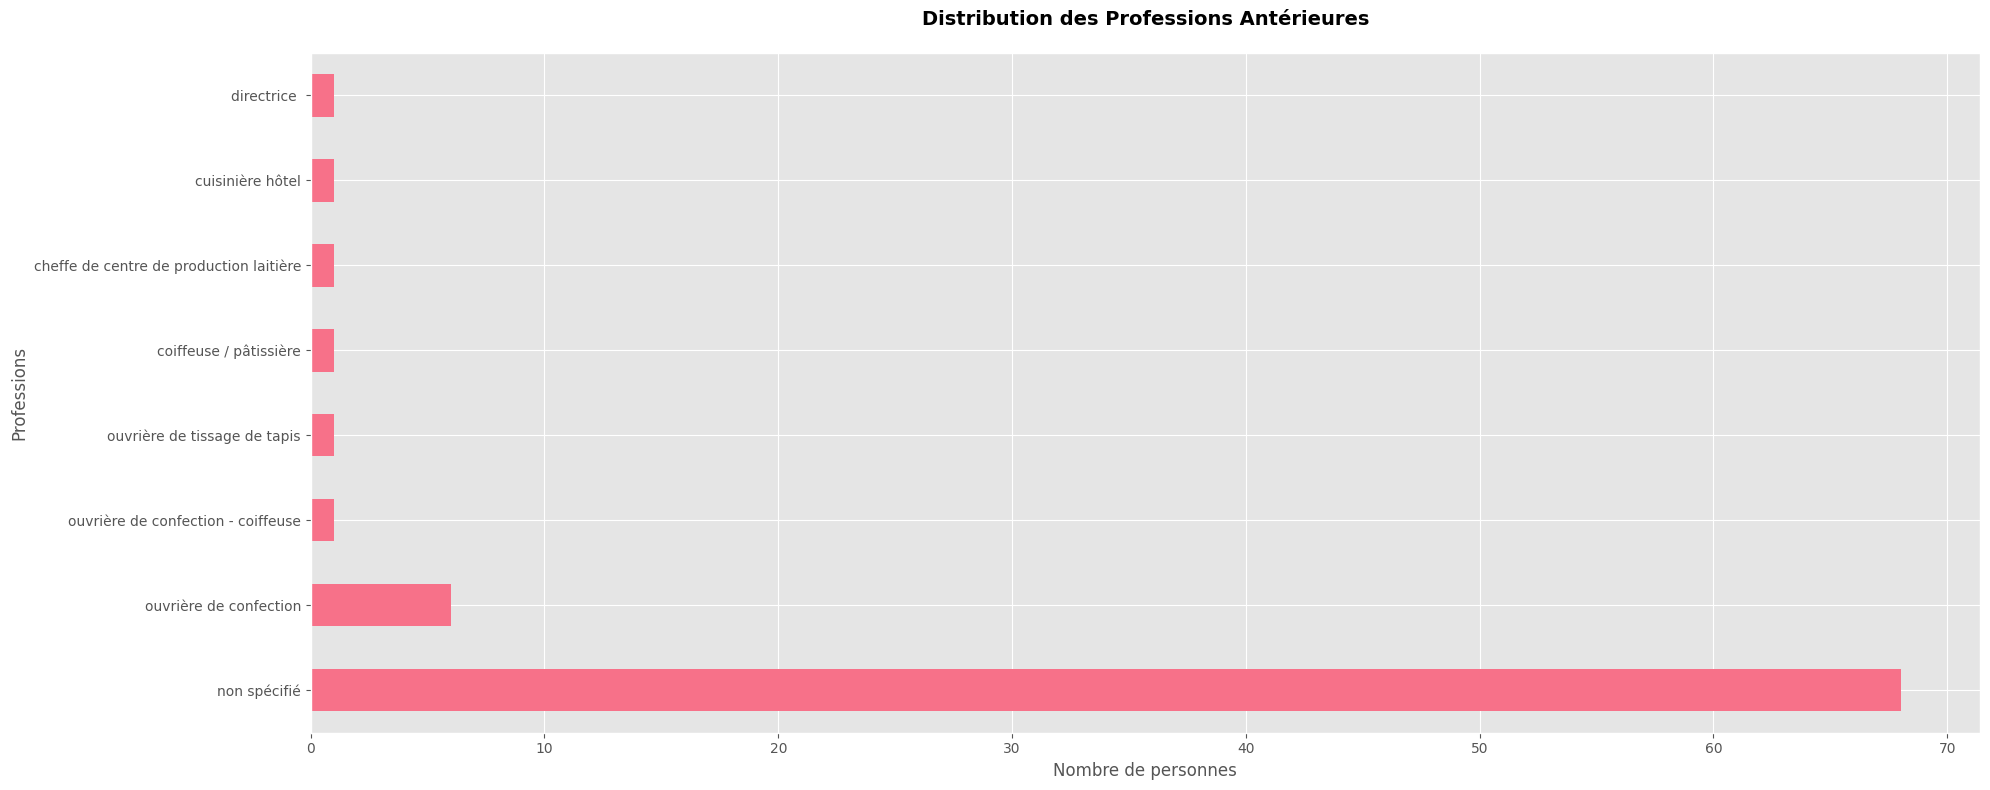

In [63]:
# Analyse des professions antérieures
plt.figure(figsize=(20, 8))

if "Professions antérieures" in df.columns:
    # Compter les professions les plus fréquentes
    prof_counts = df["Professions antérieures"].value_counts()
    prof_counts.plot(kind='barh')
    plt.title('Distribution des Professions Antérieures', pad=20, fontsize=14, fontweight='bold')
    plt.xlabel('Nombre de personnes')
    plt.ylabel('Professions')

plt.tight_layout()
plt.show()

### Analyses statistiques détaillées

In [64]:
# Analyses statistiques détaillées
print("\nAnalyses statistiques des antécédents médicaux et accidents de travail:")

# 1. Antécédents médicaux
for col in ["Antécédents familiaux", "Antécédent personnels: chirurgicaux", "Antécédents gynéco"]:
    if col in df.columns:
        print(f"\n{col}:")
        print(df[col].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')

# 2. Accidents de travail
if "AT en milieu agricole" in df.columns:
    print("\nAccidents de travail en milieu agricole:")
    at_stats = df["AT en milieu agricole"].value_counts(normalize=True).mul(100).round(2)
    print(at_stats.astype(str) + '%')
    
    if "Mécanisme AT" in df.columns:
        print("\nMécanismes d'accidents les plus fréquents:")
        mec_stats = df["Mécanisme AT"].value_counts(normalize=True).mul(100).round(2)
        print(mec_stats.astype(str) + '%')


Analyses statistiques des antécédents médicaux et accidents de travail:

Antécédents familiaux:
Antécédents familiaux
non spécifié                                                      18.75%
aucun                                                             16.25%
hta, diabète                                                       10.0%
hta, diabète, cardiopathies                                         7.5%
hta                                                                6.25%
hta, cardiopathies                                                  5.0%
tumeur maligne                                                      5.0%
cardiopathies                                                      3.75%
diabète                                                            3.75%
hta, diabète, dysthyroidie                                          2.5%
cardiopathies, tumeur maligne                                       2.5%
hémopathie maligne                                                 1.25%
hta, 

# ## 📊 Analyse des relations entre les variables


Analyse des relations entre variables:


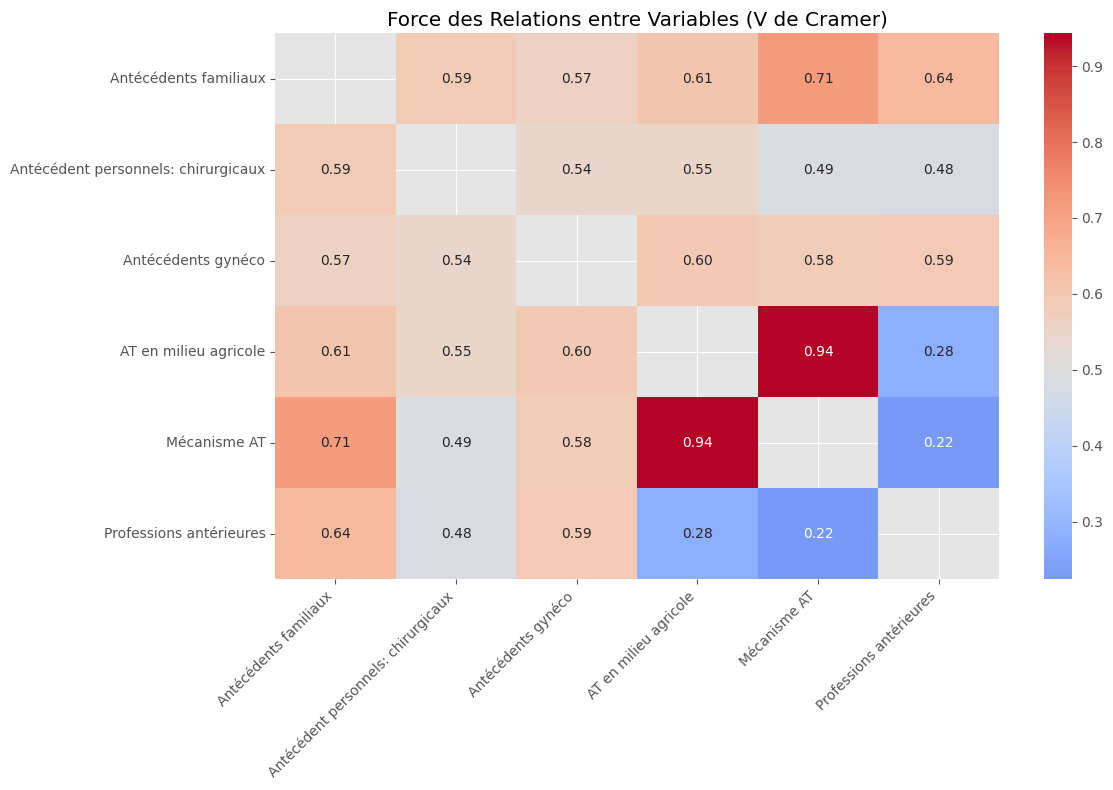

In [66]:
# ### 🛠️ Préparation des colonnes catégorielles

antecedents_cols = [
        "Antécédents familiaux", 
        "Antécédent personnels: chirurgicaux",
        "Antécédents gynéco",
        "AT en milieu agricole",
        "Mécanisme AT",
        "Professions antérieures"
    ] 
# Sélection des colonnes catégorielles présentes dans le DataFrame
print("\nAnalyse des relations entre variables:")
categorical_cols = [col for col in antecedents_cols if col in df.columns]

# ### 🔍 Calcul de la matrice de corrélation avec Cramer's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))

# Initialisation de la matrice de corrélation
corr_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

# Remplissage de la matrice avec les valeurs de Cramer's V
for i in categorical_cols:
    for j in categorical_cols:
        if i != j:
            try:
                corr_matrix.loc[i, j] = cramers_v(df[i], df[j])
            except:
                corr_matrix.loc[i, j] = np.nan  # En cas d'erreur, mettre NaN

# Conversion de la matrice en valeurs numériques (float)
corr_matrix = corr_matrix.astype(float)

# ### 📈 Visualisation de la matrice de corrélation
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0.5, fmt=".2f")  # Format des annotations à 2 décimales
plt.title('Force des Relations entre Variables (V de Cramer)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show() 

# ## 🗑️ Supprimer les colonnes non nécessaires

In [19]:
df = df.drop(columns=["N°", "Date de la visite", "Date de naissance"])

# ## 🤖 Prédire les accidents de travail dans le milieu agricole

### Random Forest

In [147]:
df_copy = df.copy()
# Séparer les features et la cible
X = df_copy.drop('AT en milieu agricole', axis=1)
y = df_copy['AT en milieu agricole'] 
y = y.map({"non": 0, "oui": 1})

In [148]:
# Encodage one-hot des variables catégorielles
X_encoded = pd.get_dummies(X, drop_first=True)

In [149]:
# Diviser les données
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Entraîner un modèle Random Forest
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Matrice de confusion:
[[10  0]
 [ 4  2]]

Rapport de classification:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83        10
           1       1.00      0.33      0.50         6

    accuracy                           0.75        16
   macro avg       0.86      0.67      0.67        16
weighted avg       0.82      0.75      0.71        16

AUC-ROC Score: 0.85


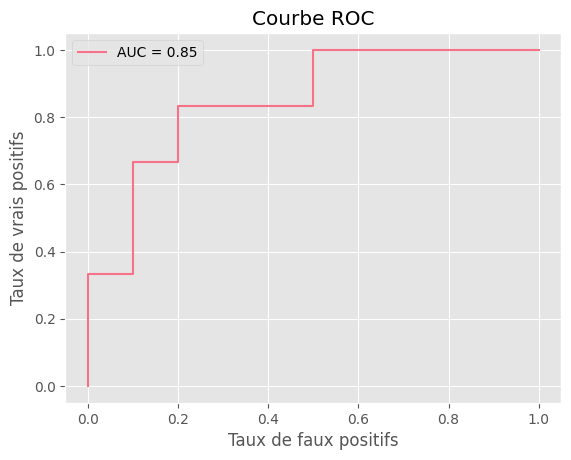

In [150]:
# Prédictions
y_pred = model.predict(X_test)

# Évaluation
print("Matrice de confusion:")
print(confusion_matrix(y_test, y_pred))

print("\nRapport de classification:")
print(classification_report(y_test, y_pred))

# AUC-ROC
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC-ROC Score:", auc)

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("Courbe ROC")
plt.legend()
plt.show() 

💡 Problème :

...

### XGBoost

In [151]:
# Séparer les features et la cible
X = df_copy.drop('AT en milieu agricole', axis=1)
y = df_copy['AT en milieu agricole'] 

In [152]:
# Encodage de la cible : "non" -> 0, "oui" -> 1
y = y.map({"non": 0, "oui": 1})

In [153]:
# Encodage one-hot des variables catégorielles
X_encoded = pd.get_dummies(X, drop_first=True)

In [154]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

In [155]:
# Vérifier la répartition des classes avant SMOTE
print("Répartition des classes avant SMOTE:")
print(y_train.value_counts())  # Vérifie combien de 0 et 1 sont présents

Répartition des classes avant SMOTE:
AT en milieu agricole
0    44
1    20
Name: count, dtype: int64


In [156]:
# ## 🔄 Application de SMOTE pour équilibrer les classessmote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
# Vérifier la répartition des classes après SMOTE
print("Répartition des classes après SMOTE:")
print(y_train_balanced.value_counts()) 

Répartition des classes après SMOTE:
AT en milieu agricole
0    44
1    44
Name: count, dtype: int64


In [157]:
# Calculer scale_pos_weight après SMOTE
scale_pos_weight = len(y_train_balanced[y_train_balanced == 0]) / len(y_train_balanced[y_train_balanced == 1])

In [158]:
# Création et entraînement du modèle XGBoost
model = xgb.XGBClassifier(
    objective="binary:logistic",  # Classification binaire
    eval_metric="logloss",  # Mesure de performance
    use_label_encoder=False,  # Évite un warning
    random_state=42,
    scale_pos_weight=scale_pos_weight  # Gestion du déséquilibre
)
# Entraîner le modèle sur les données équilibrées par SMOTE
model.fit(X_train_balanced, y_train_balanced)

C:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:51:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Matrice de confusion:
[[10  1]
 [ 2  3]]

Rapport de classification:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        11
           1       0.75      0.60      0.67         5

    accuracy                           0.81        16
   macro avg       0.79      0.75      0.77        16
weighted avg       0.81      0.81      0.81        16

AUC-ROC Score: 0.7090909090909092


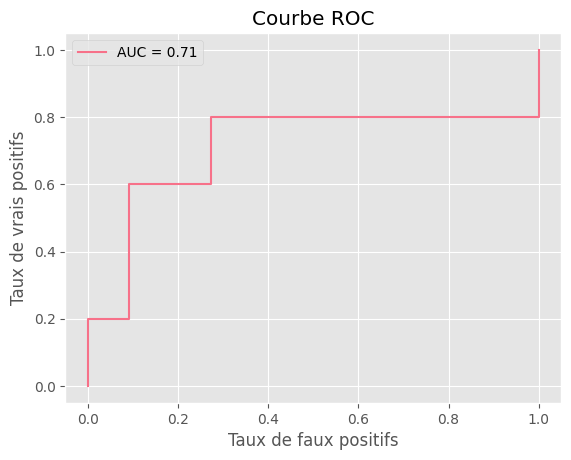

In [159]:
# ## 📊 Évaluation du modèle
y_pred = model.predict(X_test)

# Évaluation
print("Matrice de confusion:")
print(confusion_matrix(y_test, y_pred))

print("\nRapport de classification:")
print(classification_report(y_test, y_pred))

# AUC-ROC
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC-ROC Score:", auc)

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("Courbe ROC")
plt.legend()
plt.show()

### recherche du meilleure hyperparamètres pour le modèle XGBOOST

In [168]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1',  # Optimiser pour le F1-score
    cv=5,  # Validation croisée à 5 folds
    n_jobs=-1  # Utiliser tous les cœurs CPU
)

grid_search.fit(X_train_balanced, y_train_balanced)

print("Meilleurs hyperparamètres:", grid_search.best_params_)
print("Meilleur score F1:", grid_search.best_score_)

C:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
C:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
C:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:39: DeprecationWarning: Attribute n is deprecated and will be removed in Python 3.14; use value instead
  return node.n
C:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py:38: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  if isinstance(node, ast.Num):  # <number>
C:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\jobl

Meilleurs hyperparamètres: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1.0}
Meilleur score F1: 0.9527089783281733


### améliorer le modèle

In [160]:
# Création du modèle XGBoost avec les meilleurs hyperparamètres
model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    
    # Ajout des meilleurs hyperparamètres trouvés
    colsample_bytree=0.6,
    gamma=0,
    learning_rate=0.01,
    max_depth=3,
    min_child_weight=1,
    n_estimators=100,
    reg_alpha=0,
    reg_lambda=0,
    subsample=1.0
)

# Entraînement du modèle sur les données équilibrées par SMOTE
model.fit(X_train_balanced, y_train_balanced) 

C:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:51:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Matrice de confusion:
[[11  0]
 [ 2  3]]

Rapport de classification:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        11
           1       1.00      0.60      0.75         5

    accuracy                           0.88        16
   macro avg       0.92      0.80      0.83        16
weighted avg       0.89      0.88      0.86        16

AUC-ROC Score: 0.7818181818181819


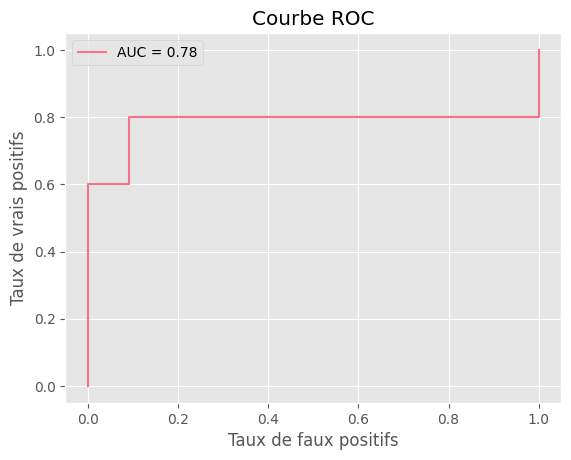

In [161]:
# ## 📊 Évaluation du modèle
y_pred = model.predict(X_test)

# Évaluation
print("Matrice de confusion:")
print(confusion_matrix(y_test, y_pred))

print("\nRapport de classification:")
print(classification_report(y_test, y_pred))

# AUC-ROC
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC-ROC Score:", auc)

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.title("Courbe ROC")
plt.legend()
plt.show()

### 📊 Feature Importance

                                               Feature  Importance
147                                 Mécanisme AT_chute    0.093548
150                               Mécanisme AT_coupure    0.068597
298                   Troubles neurologiques_céphalées    0.049575
92     q_diabète, hta, dyslipidémie, otites chroniques    0.047662
126          Antécédent personnels: chirurgicaux_aucun    0.045481
183         Troubles gynécologiques_cycles irréguliers    0.045116
196  Catégorie professionnelle_ouvrière, agricultri...    0.042619
211  Tâches effectuées_epandage des engrais, elevag...    0.040298
221  Contraintes physiques_contraintes biomécanique...    0.039469
198                                  Statut_permanente    0.039148


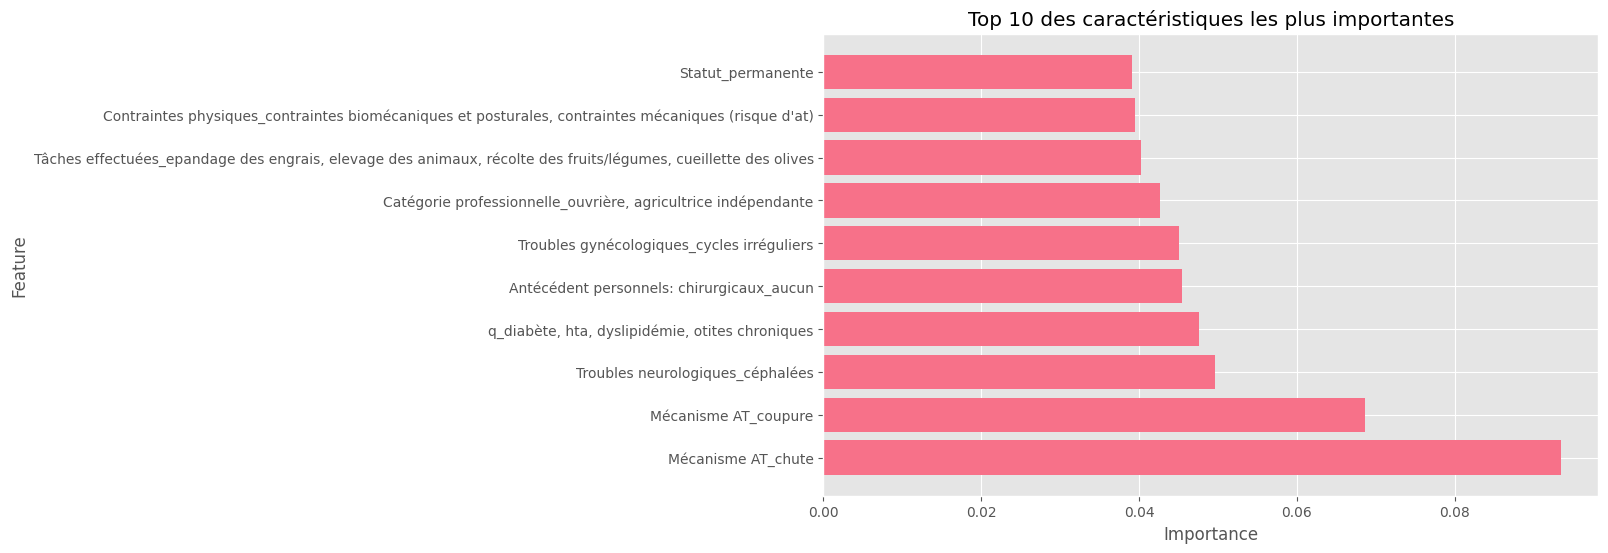

In [162]:
# Extraire les importances des caractéristiques
feature_importances = model.feature_importances_

# Associer les importances aux noms des caractéristiques
feature_names = X_train_balanced.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Trier par importance décroissante
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Afficher les 10 caractéristiques les plus importantes
print(importance_df.head(10))

# Visualiser les importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 des caractéristiques les plus importantes')
plt.show()

### 📊 Analyse SHAP pour l'interprétabilité du modèle

C:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\plots\_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


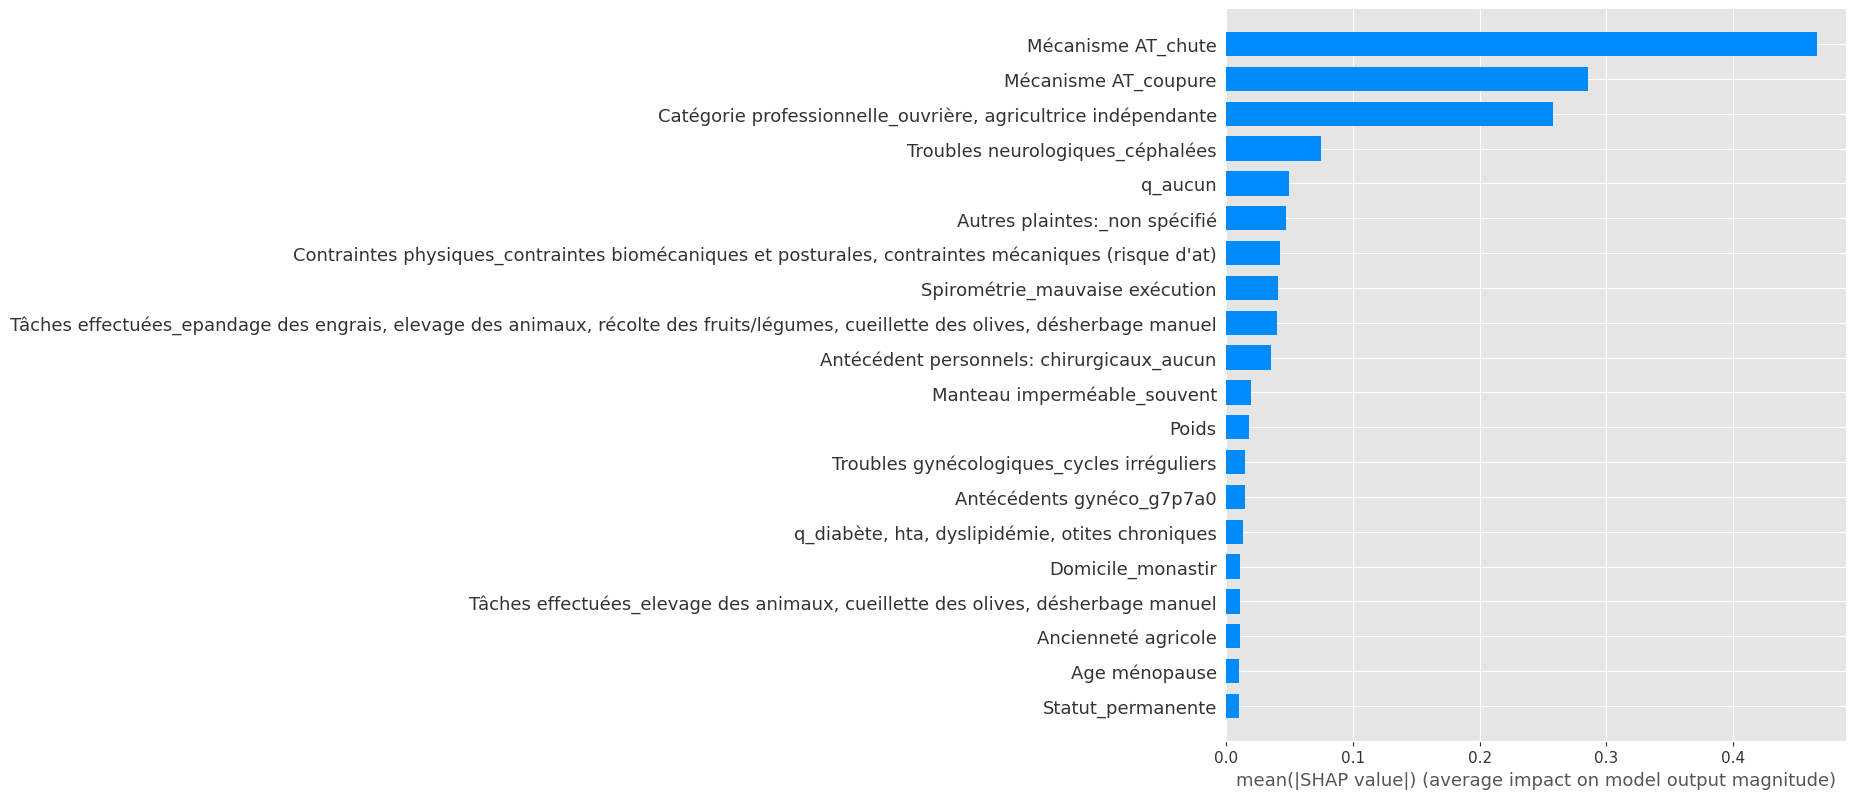

C:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\plots\_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


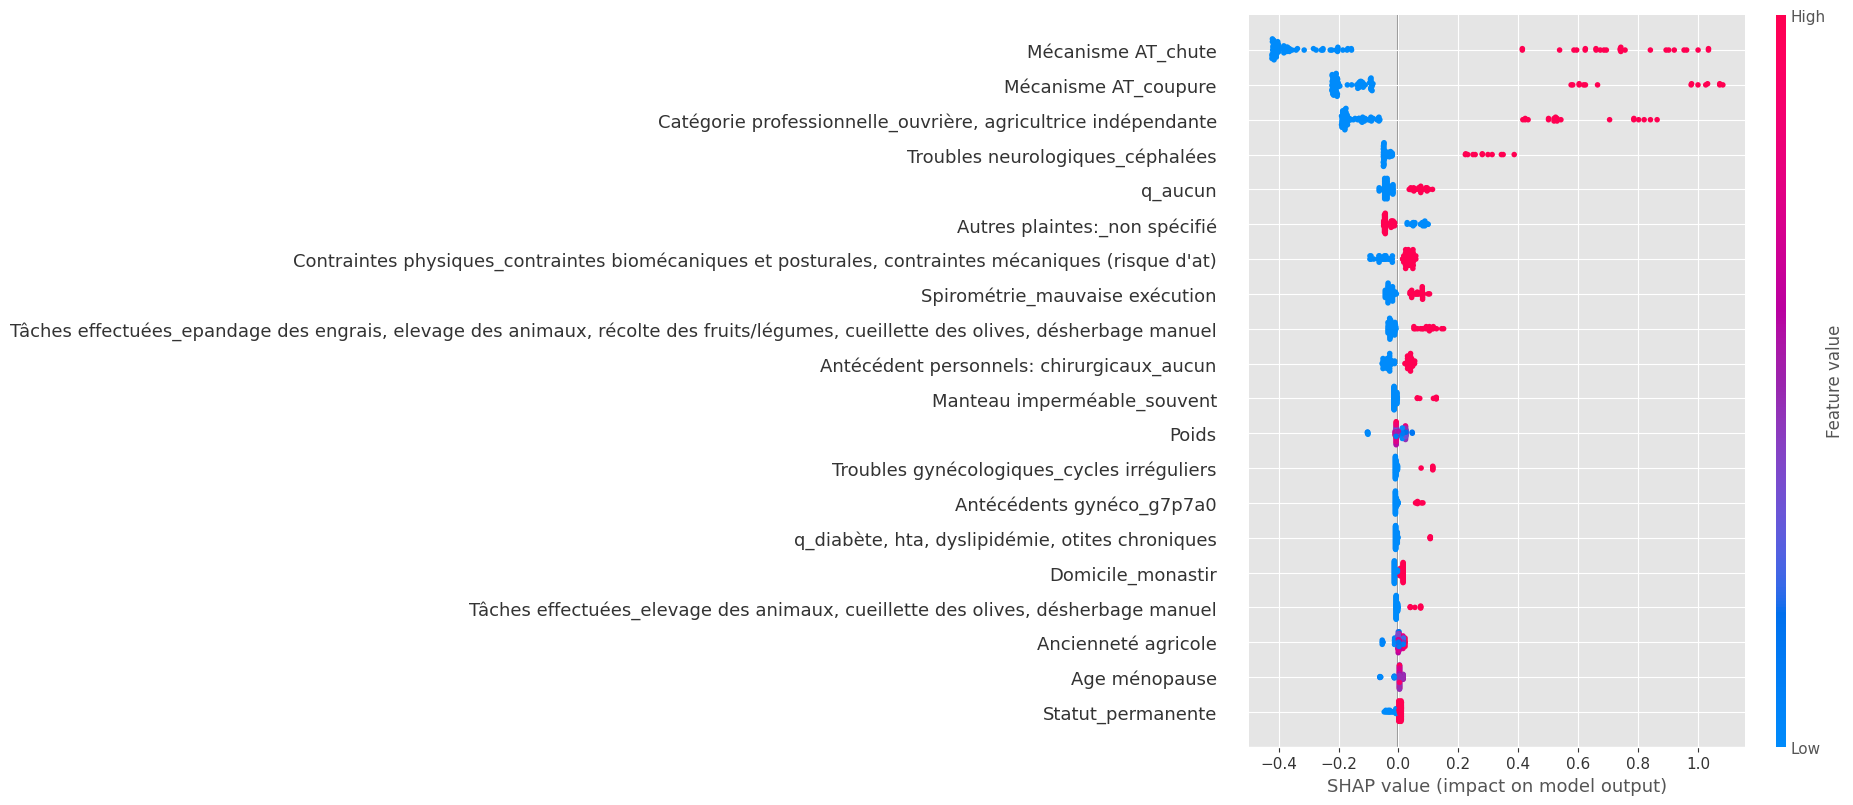

In [163]:
# Expliquer le modèle avec SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_balanced)

# Visualiser l'importance globale des caractéristiques
shap.summary_plot(shap_values, X_train_balanced, plot_type="bar")

# Visualiser l'impact des caractéristiques sur les prédictions
shap.summary_plot(shap_values, X_train_balanced) 

# ### 🛠️ Création du système de recommandation Personnalisé

In [112]:
# Sélectionner une ligne de données pour générer des recommandations
premiere_ligne = X_train.iloc[42:43]  # Sélectionne la première ligne
print(premiere_ligne)

    Age  Nb enfants  Nb pers à charge  H travail / jour  Age ménopause  \
3  48.0         5.0               0.0               6.0      47.793103   

   Ancienneté agricole  J travail / Sem  Poids  Taille  TAS  ...  \
3                 27.0              7.0     88     162  120  ...   

   Examen visuel_myopie  \
3                 False   

   Examen visuel_myopie + hypermétropie due à une rétinopathie  \
3                                              False             

   Examen visuel_non spécifié  \
3                       False   

   Examen visuel_pterygion bilatéral - flou visuel  \
3                                            False   

   Examen visuel_pterygion droit  Spirométrie_mauvaise exécution  \
3                          False                           False   

   Spirométrie_non faite  Interprétation Spiro_mixte  \
3                   True                       False   

   Interprétation Spiro_normale  Interprétation Spiro_prism  
3                         False       

In [113]:
class SystemeRecommandation:
    def __init__(self, model, seuil_importance=0.01):
        self.model = model
        self.seuil_importance = seuil_importance
        self.recommandations = {
            'Mécanisme AT_chute': [
                "Mettre en place des garde-corps sur les plateformes surélevées",
                "Porter des chaussures antidérapantes",
                "Maintenir les surfaces de travail propres et sèches",
                "Installer un éclairage adéquat dans les zones de travail"
            ],
            'Mécanisme AT_coupure': [
                "Utiliser des outils bien entretenus et adaptés",
                "Porter des gants de protection appropriés",
                "Suivre une formation sur l'utilisation sécuritaire des outils tranchants",
                "Prendre des pauses régulières pour maintenir la concentration"
            ],
            'Contraintes physiques_contraintes biomécaniques et posturales': [
                "Alterner les tâches pour varier les postures",
                "Utiliser des outils ergonomiques",
                "Faire des exercices d'étirement réguliers",
                "Respecter les principes de manutention sécuritaire"
            ],
            'Tâches effectuées_epandage des engrais': [
                "Porter un équipement de protection respiratoire",
                "Suivre les instructions de dosage des produits",
                "Éviter l'épandage par grand vent",
                "Se laver les mains après manipulation"
            ],
            'Spirométrie_mauvaise exécution': [
                "Consulter un pneumologue pour un suivi",
                "Porter un masque de protection lors des travaux poussiéreux",
                "Éviter l'exposition aux produits irritants"
            ]
        }

    def get_feature_importance(self):
        importance = self.model.feature_importances_
        features = self.model.feature_names_in_
        importance_df = pd.DataFrame({
            'feature': features,
            'importance': importance
        })
        return importance_df.sort_values('importance', ascending=False)

    def generer_recommandations(self, X):
        # Probabilité initiale d'accident
        proba_initiale = self.model.predict_proba(X)[0][1]
        
        # Importance des caractéristiques
        features_importantes = self.get_feature_importance()
        features_importantes = features_importantes[
            features_importantes['importance'] > self.seuil_importance
        ]
        
        # Calcul de la probabilité après recommandations
        proba_apres = proba_initiale
        recommandations_dict = {
            'niveau_risque': proba_initiale,
            'categories': []
        }
        
        if proba_initiale > 0.5:
            for feature in features_importantes['feature']:
                if feature in self.recommandations:
                    # Réduction de la probabilité proportionnelle à l'importance de la caractéristique
                    reduction = features_importantes.loc[
                        features_importantes['feature'] == feature, 'importance'
                    ].values[0] * 0.5  # Réduction de 50% de l'importance
                    proba_apres -= reduction
                    
                    recommandations_dict['categories'].append({
                        'feature': feature,
                        'recommendations': self.recommandations[feature],
                        'reduction': reduction
                    })
        
        # Calcul de la réduction de risque
        reduction_risque = proba_initiale - proba_apres
        
        # Ajout des résultats au dictionnaire
        recommandations_dict['proba_apres'] = proba_apres
        recommandations_dict['reduction_risque'] = reduction_risque
        
        return recommandations_dict

    def afficher_recommandations_jupyter(self, X):
        recommandations = self.generer_recommandations(X)
        
        # Style CSS amélioré
        style = """
        <style>
            .header-container {
                background-color: #1e40af;
                color: white;
                padding: 20px;
                border-radius: 8px;
                margin: 20px 0;
                text-align: center;
            }
            .header-title {
                font-size: 24px;
                font-weight: bold;
                margin-bottom: 10px;
            }
            .header-subtitle {
                font-size: 16px;
                opacity: 0.9;
            }
            .risk-container { 
                padding: 20px;
                margin: 20px 0;
                border-radius: 8px;
                font-family: Arial, sans-serif;
            }
            .high-risk {
                background-color: #fee2e2;
                border: 1px solid #ef4444;
            }
            .low-risk {
                background-color: #dcfce7;
                border: 1px solid #22c55e;
            }
            .rec-card {
                background-color: white;
                border: 1px solid #e5e7eb;
                border-radius: 8px;
                padding: 20px;
                margin: 15px 0;
                box-shadow: 0 4px 6px rgba(0,0,0,0.1);
            }
            .rec-title {
                color: #1e40af;
                font-size: 18px;
                font-weight: bold;
                margin-bottom: 15px;
                padding-bottom: 10px;
                border-bottom: 2px solid #e5e7eb;
            }
            .rec-list {
                list-style-type: none;
                padding-left: 0;
            }
            .rec-item {
                padding: 10px 0;
                margin: 5px 0;
                border-bottom: 1px solid #f3f4f6;
                line-height: 1.5;
            }
            .rec-item:before {
                content: "🔹";
                margin-right: 10px;
            }
            .footer-note {
                background-color: #f3f4f6;
                padding: 15px;
                border-radius: 8px;
                margin-top: 20px;
                font-style: italic;
                color: #4b5563;
            }
            .impact-container {
                background-color: #f0f9ff;
                padding: 20px;
                border-radius: 8px;
                margin: 20px 0;
            }
            .impact-title {
                font-size: 20px;
                font-weight: bold;
                color: #1e40af;
                margin-bottom: 15px;
            }
            .impact-item {
                margin: 10px 0;
                font-size: 16px;
            }
        </style>
        """
        
        # En-tête explicatif
        header = """
        <div class="header-container">
            <div class="header-title">Système de Prévention des Accidents du Travail</div>
            <div class="header-subtitle">
                Recommandations personnalisées pour améliorer la sécurité et réduire les risques d'accidents
            </div>
        </div>
        """
        
        # HTML pour le niveau de risque
        risk_html = f"""
        <div class="risk-container {'high-risk' if recommandations['niveau_risque'] > 0.5 else 'low-risk'}">
            <h2>{'⚠️ Niveau de risque élevé' if recommandations['niveau_risque'] > 0.5 else '✓ Niveau de risque faible'}: 
            {recommandations['niveau_risque']:.1%}</h2>
        </div>
        """
        
        # HTML pour les recommandations
        recommendations_html = """
        <div class="rec-card">
            <div class="rec-title">Objectif des Recommandations</div>
            <p>Les recommandations suivantes sont conçues pour :</p>
            <ul class="rec-list">
                <li class="rec-item">Réduire les risques d'accidents du travail</li>
                <li class="rec-item">Améliorer les conditions de travail</li>
                <li class="rec-item">Protéger votre santé et votre sécurité</li>
            </ul>
        </div>
        """
        
        if recommandations['niveau_risque'] > 0.5:
            for categorie in recommandations['categories']:
                recommendations_html += f"""
                <div class="rec-card">
                    <div class="rec-title">Actions préventives pour : {categorie['feature']}</div>
                    <ul class="rec-list">
                """
                for rec in categorie['recommendations']:
                    recommendations_html += f'<li class="rec-item">{rec}</li>'
                recommendations_html += '</ul></div>'
        else:
            recommendations_html += """
            <div class="rec-card">
                <div class="rec-title">Maintien des bonnes pratiques</div>
                <p>Continuez à appliquer les bonnes pratiques de sécurité actuelles.</p>
            </div>
            """
        
        # HTML pour l'impact des recommandations (affiché en dernier)
        impact_html = f"""
        <div class="impact-container">
            <div class="impact-title">Impact des Recommandations</div>
            <div class="impact-item">📉 Probabilité initiale d'accident : <strong>{recommandations['niveau_risque']:.1%}</strong></div>
            <div class="impact-item">📈 Probabilité après recommandations : <strong>{recommandations['proba_apres']:.1%}</strong></div>
            <div class="impact-item">🚀 Réduction de risque : <strong>{recommandations['reduction_risque']:.1%}</strong></div>
        </div>
        """
        
        # Note de bas de page
        footer = """
        <div class="footer-note">
            ℹ️ Ces recommandations sont basées sur l'analyse des facteurs de risque identifiés. 
            Leur application régulière contribue à créer un environnement de travail plus sûr.
        </div>
        """
        
        # Afficher le HTML complet
        display(HTML(style + header + risk_html + recommendations_html + impact_html + footer))

In [114]:
# Créer une instance du système
systeme = SystemeRecommandation(model)

# Afficher les recommandations avec le nouveau format
systeme.afficher_recommandations_jupyter(premiere_ligne)

# ## 🤖 Prédire les risques de maladies pour les femmes agricultrices

In [20]:
# ### 📂 Chargement des données
data = df.copy()

### 🛠️ Préparation des données

In [21]:
# Liste des colonnes cibles à ne pas encoder
colonnes_cibles = [
    'Troubles gynécologiques', 'Troubles cardio-respiratoires', 
    'Troubles cognitifs', 'Troubles neurologiques', 'Troubles cutanés/phanères'
]

# Affichage des valeurs uniques pour chaque colonne cible

for col in colonnes_cibles:
    print(f"Valeurs uniques pour {col} :")
    print(data[col].unique())
    
# Encodage des colonnes catégorielles (sauf les colonnes cibles)
for col in data.columns:
    if data[col].dtype == 'object' and col not in colonnes_cibles:  # Si la colonne est catégorielle et non cible
        # Remplacement des valeurs 'non spécifié' par NaN
        data[col] = data[col].replace('non spécifié', pd.NA)
        
        # One-Hot Encoding pour les colonnes catégorielles nominales
        if data[col].nunique() > 2:  # Si plus de 2 catégories
            data = pd.get_dummies(data, columns=[col], prefix=col, drop_first=True)
        else:
            # Label Encoding pour les colonnes binaires
            label_encoder = LabelEncoder()
            data[col] = label_encoder.fit_transform(data[col].astype(str))

Valeurs uniques pour Troubles gynécologiques :
['non spécifié' 'dysménorrhée' 'cycles irréguliers' 'métrorragies'
 "aménorrhée depuis l'âge de 30 ans"
 'douleur pariétale à la palpation mammaire']
Valeurs uniques pour Troubles cardio-respiratoires :
['palpitations' "dyspnée d'efforts 1 mmrc - toux productive"
 'non spécifié' 'dyspnée sifflante stade 2 mmrc'
 "dyspnée d'effort stade 3 mmrc - toux productive - dyspnée sifflante - palpitations"
 'dyspnée sifflante - toux sèche' "dyspnée d'effort mmrc 1" 'dyspnée'
 "toux - dyspnée d'effort" 'toux sèche - dyspnée sifflante'
 "dyspnée d'effort mmrc 2" "toux lors de l'épendage des engrais + dyspnée"
 "dyspnée d'effort + dysphonie + toux sèche"
 "dyspnée d'effort mmrc 2 + douleur thoracique" "dyspnée d'effort"
 'dyspnée + toux' 'varices mi'
 "trachéite à l'inhalation de poussières de blé" 'dyspnée légère'
 "toux + dyspnée d'effort" 'toux à la manipulation des engrais'
 'dyspnée + toux + eternuement' 'toux sèche' 'varices mi gauche']
Valeurs un

### Encodage des colonnes cibles

In [22]:
for col in colonnes_cibles:
    data[col] = data[col].apply(lambda x: 0 if x == 'non spécifié' else 1) 

### 🧩 Séparation des features et des cibles

In [23]:
X = data.drop(columns=colonnes_cibles)
y = data[colonnes_cibles]

In [24]:
print(y.value_counts())

Troubles gynécologiques  Troubles cardio-respiratoires  Troubles cognitifs  Troubles neurologiques  Troubles cutanés/phanères
0                        0                              0                   0                       0                            19
                         1                              0                   0                       0                            15
                         0                              0                   1                       0                            10
                         1                              0                   1                       0                             8
                         0                              1                   1                       0                             5
                                                        0                   1                       1                             4
                         1                              1                   1     

In [25]:
# Affichage de la distribution des classes pour chaque cible
for col in colonnes_cibles:
    print(f"Distribution des classes pour {col} :")
    print(y[col].value_counts()) 

Distribution des classes pour Troubles gynécologiques :
Troubles gynécologiques
0    74
1     6
Name: count, dtype: int64
Distribution des classes pour Troubles cardio-respiratoires :
Troubles cardio-respiratoires
0    47
1    33
Name: count, dtype: int64
Distribution des classes pour Troubles cognitifs :
Troubles cognitifs
0    63
1    17
Name: count, dtype: int64
Distribution des classes pour Troubles neurologiques :
Troubles neurologiques
0    45
1    35
Name: count, dtype: int64
Distribution des classes pour Troubles cutanés/phanères :
Troubles cutanés/phanères
0    66
1    14
Name: count, dtype: int64


In [223]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

###  Entraînement du modèle Random Forest avec ClassifierChain

In [224]:
# Calculer les poids des classes pour chaque cible
class_weights = []
for i in range(y_train.shape[1]):
    weights = compute_class_weight('balanced', classes=np.unique(y_train.iloc[:, i]), y=y_train.iloc[:, i])
    class_weights.append(dict(zip(np.unique(y_train.iloc[:, i]), weights)))

# Entraînement du modèle avec pondération des classes
model = ClassifierChain(
    RandomForestClassifier(random_state=42, class_weight=class_weights[i])
)
model.fit(X_train, y_train) 

ClassifierChain(base_estimator=RandomForestClassifier(class_weight={0: 0.5925925925925926,
                                                                    1: 3.2},
                                                      random_state=42))

In [225]:
# Prédiction sur l'ensemble de test
y_pred = model.predict(X_test)

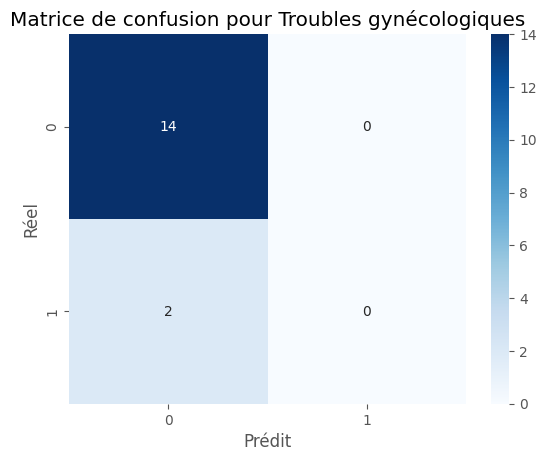

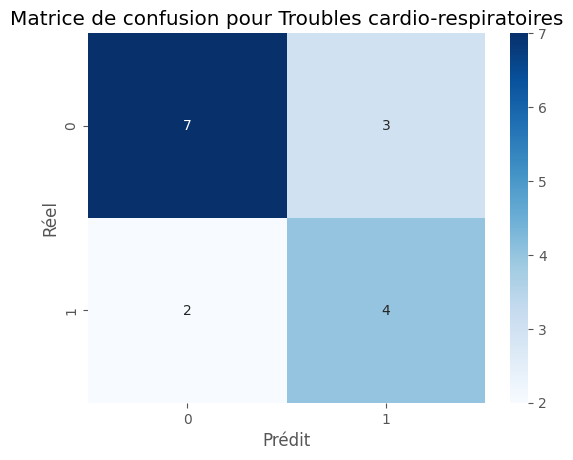

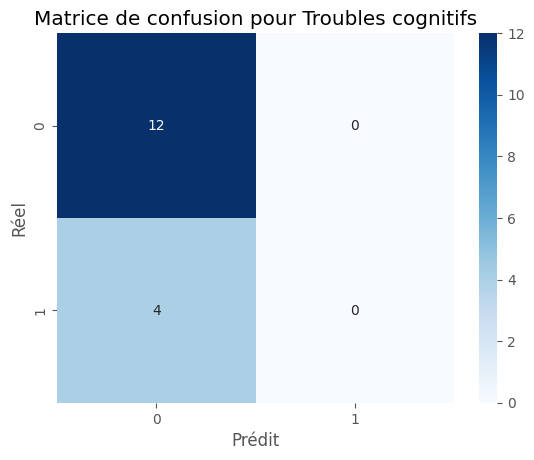

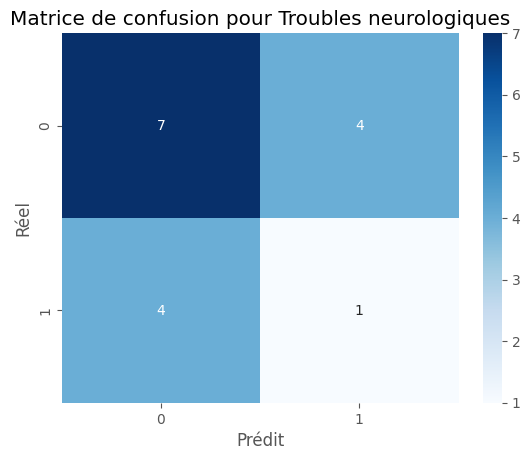

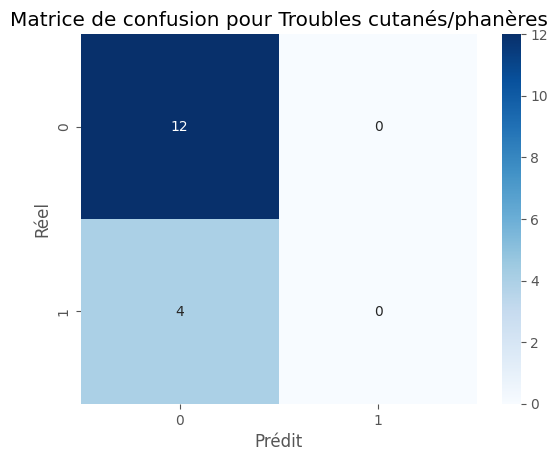

In [226]:
# Matrice de confusion pour chaque cible
for i, col in enumerate(y_test.columns):
    classes = np.unique(y_train.iloc[:, i])  # Utilisez les classes de l'ensemble d'entraînement
    cm = confusion_matrix(y_test.iloc[:, i], y_pred[:, i], labels=classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f"Matrice de confusion pour {col}")
    plt.xlabel('Prédit')
    plt.ylabel('Réel')
    plt.show()

In [227]:
# Rapport de classification pour chaque cible
for i, col in enumerate(colonnes_cibles):
    print(f"Classification Report for {col}:")
    print(classification_report(y_test.iloc[:, i], y_pred[:, i]))
    print("-" * 60)

Classification Report for Troubles gynécologiques:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        14
           1       0.00      0.00      0.00         2

    accuracy                           0.88        16
   macro avg       0.44      0.50      0.47        16
weighted avg       0.77      0.88      0.82        16

------------------------------------------------------------
Classification Report for Troubles cardio-respiratoires:
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.57      0.67      0.62         6

    accuracy                           0.69        16
   macro avg       0.67      0.68      0.68        16
weighted avg       0.70      0.69      0.69        16

------------------------------------------------------------
Classification Report for Troubles cognitifs:
              precision    recall  f1-score   support

           0   

C:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

# ## Amélioration du modèle Random Forest avec ClassifierChain

In [31]:
# Initialisation des listes pour stocker les résultats
all_confusion_matrices = {col: [] for col in y.columns}
all_classification_reports = {col: [] for col in y.columns}

In [32]:
# Initialisation de la validation croisée stratifiée
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [33]:
# Compter les valeurs manquantes dans y
print("\nNombre total de valeurs manquantes dans y :")
print(y.isna().sum())


Nombre total de valeurs manquantes dans y :
Troubles gynécologiques          0
Troubles cardio-respiratoires    0
Troubles cognitifs               0
Troubles neurologiques           0
Troubles cutanés/phanères        0
dtype: int64


In [34]:
# Pour chaque fold
for fold, (train_index, test_index) in enumerate(skf.split(X, y.iloc[:, 0])):
    print(f"Fold {fold + 1}/5")
    
    # Split des données
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Application de SMOTE séparément pour chaque cible
    X_resampled_list = []
    y_resampled_list = []
    
    for col in y_train.columns:
        # Calcul du nombre minimal d'échantillons dans la classe minoritaire
        min_samples = min(np.bincount(y_train[col]))
        # Ajustement du nombre de voisins (k) en fonction de la taille de la classe minoritaire
        k_neighbors = min(min_samples - 1, 5)  # -1 car on ne compte pas l'échantillon lui-même
        
        if k_neighbors > 0:
            smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
            X_temp, y_temp = smote.fit_resample(X_train, y_train[col])
            X_resampled_list.append(X_temp)
            y_resampled_list.append(y_temp)
        else:
            # Si pas assez d'échantillons pour SMOTE, garder les données originales
            X_resampled_list.append(X_train)
            y_resampled_list.append(y_train[col])
    
    # Combiner les résultats
    X_train_res = pd.concat(X_resampled_list, axis=0)
    y_train_res = pd.concat(y_resampled_list, axis=1)
    
    # Supprimer les doublons dans X_train_res et aligner y_train_res
    X_train_res = X_train_res.drop_duplicates()
    y_train_res = y_train_res.loc[X_train_res.index]
    
    # Réinitialiser l'index de y_train_res pour éviter les doublons
    y_train_res = y_train_res.reset_index(drop=True)
    
    # Vérifier les valeurs manquantes dans y_train_res après SMOTE
    print("Valeurs manquantes dans y_train_res après SMOTE :")
    print(y_train_res.isna().sum())
    
    # Imputation KNN pour les valeurs manquantes dans y_train_res
    # Combiner X_train_res et y_train_res pour l'imputation
    imputation_data = pd.concat([X_train_res.reset_index(drop=True), y_train_res], axis=1)
    
    # Initialiser l'imputer KNN avec un nombre approprié de voisins
    imputer = KNNImputer(n_neighbors=min(5, len(X_train_res)//10), weights='uniform')
    
    # Appliquer l'imputation
    imputed_data = imputer.fit_transform(imputation_data)
    
    # Récupérer les cibles imputées
    y_train_res = pd.DataFrame(
        imputed_data[:, -len(y_train.columns):],
        columns=y_train.columns
    )
    
    # Arrondir les valeurs imputées à 0 ou 1 car ce sont des classifications binaires
    for col in y_train_res.columns:
        y_train_res[col] = y_train_res[col].round().astype(int)
    
    print("Valeurs manquantes après imputation KNN :")
    print(y_train_res.isna().sum())
    
    # Création et entraînement du modèle
    base_classifier = RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_leaf=2,
        random_state=42
    )
    
    model = ClassifierChain(base_classifier, random_state=42)
    model.fit(X_train_res, y_train_res)  # Utiliser X_train_res au lieu de X_train
    
    # Prédictions
    y_pred = model.predict(X_test)
    
    # Évaluation pour chaque cible
    for i, col in enumerate(y.columns):
        # Matrice de confusion
        conf_matrix = confusion_matrix(y_test[col], y_pred[:, i])
        all_confusion_matrices[col].append(conf_matrix)
        
        # Rapport de classification
        class_report = classification_report(y_test[col], y_pred[:, i], output_dict=True)
        all_classification_reports[col].append(class_report)
        
        print(f"\nRésultats pour {col} - Fold {fold + 1}:")
        print("Matrice de confusion:")
        print(conf_matrix)
        print("\nRapport de classification:")
        print(classification_report(y_test[col], y_pred[:, i]))

Fold 1/5
Valeurs manquantes dans y_train_res après SMOTE :
Troubles gynécologiques            0
Troubles cardio-respiratoires     84
Troubles cognitifs                24
Troubles neurologiques           124
Troubles cutanés/phanères         16
dtype: int64
Valeurs manquantes après imputation KNN :
Troubles gynécologiques          0
Troubles cardio-respiratoires    0
Troubles cognitifs               0
Troubles neurologiques           0
Troubles cutanés/phanères        0
dtype: int64


C:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier


Résultats pour Troubles gynécologiques - Fold 1:
Matrice de confusion:
[[15  0]
 [ 1  0]]

Rapport de classification:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       0.00      0.00      0.00         1

    accuracy                           0.94        16
   macro avg       0.47      0.50      0.48        16
weighted avg       0.88      0.94      0.91        16


Résultats pour Troubles cardio-respiratoires - Fold 1:
Matrice de confusion:
[[4 4]
 [3 5]]

Rapport de classification:
              precision    recall  f1-score   support

           0       0.57      0.50      0.53         8
           1       0.56      0.62      0.59         8

    accuracy                           0.56        16
   macro avg       0.56      0.56      0.56        16
weighted avg       0.56      0.56      0.56        16


Résultats pour Troubles cognitifs - Fold 1:
Matrice de confusion:
[[13  1]
 [ 2  0]]

Rapport de classifi

C:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier


Résultats pour Troubles gynécologiques - Fold 2:
Matrice de confusion:
[[15  0]
 [ 1  0]]

Rapport de classification:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       0.00      0.00      0.00         1

    accuracy                           0.94        16
   macro avg       0.47      0.50      0.48        16
weighted avg       0.88      0.94      0.91        16


Résultats pour Troubles cardio-respiratoires - Fold 2:
Matrice de confusion:
[[6 6]
 [2 2]]

Rapport de classification:
              precision    recall  f1-score   support

           0       0.75      0.50      0.60        12
           1       0.25      0.50      0.33         4

    accuracy                           0.50        16
   macro avg       0.50      0.50      0.47        16
weighted avg       0.62      0.50      0.53        16


Résultats pour Troubles cognitifs - Fold 2:
Matrice de confusion:
[[10  0]
 [ 6  0]]

Rapport de classifi

C:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier


Résultats pour Troubles gynécologiques - Fold 3:
Matrice de confusion:
[[15  0]
 [ 1  0]]

Rapport de classification:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       0.00      0.00      0.00         1

    accuracy                           0.94        16
   macro avg       0.47      0.50      0.48        16
weighted avg       0.88      0.94      0.91        16


Résultats pour Troubles cardio-respiratoires - Fold 3:
Matrice de confusion:
[[5 7]
 [1 3]]

Rapport de classification:
              precision    recall  f1-score   support

           0       0.83      0.42      0.56        12
           1       0.30      0.75      0.43         4

    accuracy                           0.50        16
   macro avg       0.57      0.58      0.49        16
weighted avg       0.70      0.50      0.52        16


Résultats pour Troubles cognitifs - Fold 3:
Matrice de confusion:
[[15  0]
 [ 1  0]]

Rapport de classifi

In [35]:
# Calcul des moyennes des métriques sur tous les folds
print("\nMoyennes des métriques sur tous les folds:")
for col in y.columns:
    avg_report = {}
    metrics = ['precision', 'recall', 'f1-score']
    
    for metric in metrics:
        for class_label in ['0', '1', 'macro avg', 'weighted avg']:
            values = [fold_report[class_label][metric] 
                     for fold_report in all_classification_reports[col]]
            avg_report[f"{class_label}_{metric}"] = np.mean(values)
    
    print(f"\n{col}:")
    print(f"Moyenne F1-score (macro): {avg_report['macro avg_f1-score']:.3f}")
    print(f"Moyenne F1-score (weighted): {avg_report['weighted avg_f1-score']:.3f}")
    
    # Matrice de confusion moyenne
    avg_conf_matrix = np.mean(all_confusion_matrices[col], axis=0)
    print("\nMatrice de confusion moyenne:")
    print(avg_conf_matrix)


Moyennes des métriques sur tous les folds:

Troubles gynécologiques:
Moyenne F1-score (macro): 0.580
Moyenne F1-score (weighted): 0.901

Matrice de confusion moyenne:
[[14.6  0.2]
 [ 1.   0.2]]

Troubles cardio-respiratoires:
Moyenne F1-score (macro): 0.489
Moyenne F1-score (weighted): 0.509

Matrice de confusion moyenne:
[[4.2 5.2]
 [2.8 3.8]]

Troubles cognitifs:
Moyenne F1-score (macro): 0.422
Moyenne F1-score (weighted): 0.672

Matrice de confusion moyenne:
[[11.8  0.8]
 [ 3.4  0. ]]

Troubles neurologiques:
Moyenne F1-score (macro): 0.508
Moyenne F1-score (weighted): 0.523

Matrice de confusion moyenne:
[[5.6 3.4]
 [4.2 2.8]]

Troubles cutanés/phanères:
Moyenne F1-score (macro): 0.474
Moyenne F1-score (weighted): 0.763

Matrice de confusion moyenne:
[[12.8  0.4]
 [ 2.6  0.2]]


### Points d'Attention et Recommandations
### Limites Observées
Persistance du déséquilibre malgré SMOTE

Tendance générale à la sur-prédiction de la classe majoritaire

Faible capacité de détection des cas positifs


### Rapport sur les stratégies utilisées pour gérer le déséquilibre Important

### 1/ SMOTE (Synthetic Minority Over-sampling Technique) 🧬 :

Génère des échantillons synthétiques pour la classe minoritaire afin d'équilibrer les classes.

Le nombre de voisins k_neighbors est ajusté en fonction de la taille de la classe minoritaire.

Si une classe minoritaire a trop peu d'échantillons (moins de 2), SMOTE n'est pas appliqué pour cette classe.

### 2/ Imputation KNN pour les valeurs manquantes 🛠️ :

Remplissage des valeurs manquantes dans y_train avant l'application de SMOTE, en utilisant l'imputation par les voisins les plus proches.

Après imputation, les valeurs sont arrondies à 0 ou 1 (classification binaire).

### 3/ Random Forest Classifier ⚖️ 

# ## Amélioration du modèle Random Forest avec ClassifierChain

In [71]:
class AdaptiveMultiLabelClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, threshold_optimization=True, n_trials=100, min_samples_smote=6):
        self.threshold_optimization = threshold_optimization
        self.n_trials = n_trials
        self.min_samples_smote = min_samples_smote
        self.thresholds = {}
        self.feature_selector = None
        self.models = {}
        self.scalers = {}
        self.label_names = None
        
    def optimize_threshold(self, X, y_true, y_pred_proba, label):
        """
        Optimize decision threshold for a label using Optuna
        """
        def objective(trial):
            threshold = trial.suggest_float("threshold", 0.1, 0.9)
            y_pred = (y_pred_proba > threshold).astype(int)
            try:
                return geometric_mean_score(y_true, y_pred)
            except ValueError:
                return 0.0
                
        study = optuna.create_study(direction="maximize")
        try:
            study.optimize(objective, n_trials=self.n_trials)
            return study.best_params["threshold"]
        except Exception as e:
            print(f"Error optimizing threshold for {label}: {str(e)}")
            return 0.5

    def fit(self, X, y):
        self.label_names = y.columns
        X_orig = X.copy()
        
        # Feature selection
        base_clf = RandomForestClassifier(
            n_estimators=200,
            max_depth=20,
            random_state=42
        )
        
        self.feature_selector = SelectFromModel(
            estimator=base_clf,
            threshold="mean"
        )
        
        X_selected = self.feature_selector.fit_transform(X_orig, y.iloc[:, 0])
        
        # Process each label separately
        for label in self.label_names:
            print(f"Processing label: {label}")
            
            y_label = y[label].values
            
            # Standardization
            self.scalers[label] = StandardScaler()
            X_scaled = self.scalers[label].fit_transform(X_selected)
            
            # Aucune adaptation d'échantillon ici
            X_resampled, y_resampled = X_scaled, y_label  # X_scaled et y_label restent inchangés
            
            # Model creation and calibration
            base_model = RandomForestClassifier(
                n_estimators=200,
                max_depth=20,
                random_state=42
            )
            
            n_splits = min(5, len(np.unique(y_resampled, return_counts=True)[1]))
            n_splits = max(2, n_splits)
            
            calibrated_model = CalibratedClassifierCV(
                base_model,
                cv=n_splits,
                method='sigmoid'
            )
            
            try:
                self.models[label] = calibrated_model.fit(X_resampled, y_resampled)
            except Exception as e:
                print(f"Training error for {label}: {str(e)}")
                self.models[label] = base_model.fit(X_resampled, y_resampled)
            
            if self.threshold_optimization:
                y_pred_proba = self.models[label].predict_proba(X_scaled)[:, 1]
                self.thresholds[label] = self.optimize_threshold(
                    X_scaled, y_label, y_pred_proba, label
                )
            else:
                self.thresholds[label] = 0.5
        
        return self

    def predict(self, X):
        X_selected = self.feature_selector.transform(X)
        predictions = pd.DataFrame(index=X.index, columns=self.label_names)
        
        for label in self.label_names:
            try:
                X_scaled = self.scalers[label].transform(X_selected)
                y_pred_proba = self.models[label].predict_proba(X_scaled)[:, 1]
                predictions[label] = (y_pred_proba > self.thresholds[label]).astype(int)
            except Exception as e:
                print(f"Prediction error for {label}: {str(e)}")
                predictions[label] = 0
        
        return predictions


In [72]:
def evaluate_model(X, y, n_splits=5):
    """
    Evaluate the model using cross-validation
    
    Parameters:
    -----------
    X : array-like
        Input features
    y : array-like
        Target values
    n_splits : int, default=5
        Number of folds for cross-validation
    
    Returns:
    --------
    tuple
        (results, models, feature_selector)
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = {}
    all_models = {}
    feature_selector = None
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y.iloc[:, 0])):
        print(f"Processing fold {fold + 1}/{n_splits}")
        
        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx].copy(), y.iloc[test_idx].copy()
        
        model = AdaptiveMultiLabelClassifier(threshold_optimization=True)
        model.fit(X_train, y_train)
        
        # Store feature selector from the first fold
        if fold == 0:
            feature_selector = model.feature_selector
            
        y_pred = model.predict(X_test)
        
        # Store results for this fold
        for label in y.columns:
            if label not in results:
                results[label] = {
                    'f1_scores': [],
                    'g_means': [],
                    'conf_matrices': [],
                    'y_true': [],
                    'y_pred': []
                }
            
            results[label]['f1_scores'].append(
                classification_report(y_test[label], y_pred[label], output_dict=True)
            )
            results[label]['g_means'].append(
                geometric_mean_score(y_test[label], y_pred[label])
            )
            results[label]['conf_matrices'].append(
                confusion_matrix(y_test[label], y_pred[label])
            )
            results[label]['y_true'].append(y_test[label])
            results[label]['y_pred'].append(y_pred[label])
            
            if label not in all_models:
                all_models[label] = model.models[label]
            
            print(f"\nResults for {label} - Fold {fold + 1}:")
            print(classification_report(y_test[label], y_pred[label]))
    
    return results, all_models, feature_selector

In [73]:
def plot_confusion_matrix(conf_matrix, label):
    """
    Plot confusion matrix using seaborn
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues')
    plt.title(f'Confusion Matrix - {label}')
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.tight_layout()
    plt.show() 

In [90]:
def get_feature_importances(model):
    """
    Extrait les feature importances d'un modèle de manière robuste
    """
    try:
        # Pour CalibratedClassifierCV
        if hasattr(model, 'calibrated_classifiers_'):
            # Accéder au RandomForestClassifier sous-jacent
            base_model = model.calibrated_classifiers_[0].estimator
            return base_model.feature_importances_
            
        # Pour les modèles standards
        elif hasattr(model, 'feature_importances_'):
            return model.feature_importances_
            
        # Pour les modèles avec estimators_ (comme RandomForest)
        elif hasattr(model, 'estimators_') and len(model.estimators_) > 0:
            return model.estimators_[0].feature_importances_
            
        else:
            raise AttributeError("Modèle non compatible avec feature_importances_")
            
    except Exception as e:
        raise ValueError(f"Erreur lors de l'extraction des feature importances: {str(e)}")

def plot_feature_importance(model, feature_names, X, y_true, feature_selector, title):
    """
    Affiche l'importance des features avec des noms complets
    """
    plt.figure(figsize=(15, 7))
    
    # Feature Importance classique
    plt.subplot(1, 2, 1)
    
    # Obtenir les features sélectionnées
    if feature_selector:
        selected_features_mask = feature_selector.get_support()
        selected_feature_names = [name for name, selected in zip(feature_names, selected_features_mask) if selected]
    else:
        selected_feature_names = feature_names
    
    try:
        # Extraction des importances avec la nouvelle fonction
        importances = get_feature_importances(model)
        
        # Création du DataFrame avec les noms complets
        feature_imp = pd.DataFrame({
            'feature': selected_feature_names,
            'importance': importances
        })
        
        # Tri par importance décroissante et sélection des 10 plus importantes
        feature_imp = feature_imp.sort_values('importance', ascending=False).head(10)
        
        # Création du graphique
        plt.title(f'Top 10 des caractéristiques les plus importantes\n{title}')
        
        # Utilisation de barh pour un graphique horizontal
        bars = plt.barh(range(len(feature_imp)), feature_imp['importance'])
        
        # Ajout des étiquettes
        plt.yticks(range(len(feature_imp)), feature_imp['feature'], wrap=True)
        
        # Ajustement de la mise en page pour les longs noms
        plt.subplots_adjust(left=0.4)
        
        # Ajout des valeurs sur les barres
        for i, bar in enumerate(bars):
            width = bar.get_width()
            plt.text(width, i, f'{width:.4f}', 
                    va='center', ha='left', fontsize=8)
            
    except Exception as e:
        plt.text(0.5, 0.5, f'Feature importance not available\n{str(e)}',
                ha='center', va='center', transform=plt.gca().transAxes)
    
    # SHAP Values
    try:
        plt.subplot(1, 2, 2)
        plt.title(f'SHAP Values - {title}')
        
        # Pour CalibratedClassifierCV, utiliser le modèle de base
        if hasattr(model, 'calibrated_classifiers_'):
            base_model = model.calibrated_classifiers_[0].estimator
        else:
            base_model = model
            
        explainer = shap.TreeExplainer(base_model)
        
        # Utilisation des features sélectionnées pour SHAP
        X_selected = X if not feature_selector else feature_selector.transform(X)
        
        # Échantillonnage si nécessaire
        max_samples = min(100, X_selected.shape[0])
        X_sample = X_selected[:max_samples]
        
        shap_values = explainer.shap_values(X_sample)
        
        if isinstance(shap_values, list):
            shap_values = shap_values[1] if len(shap_values) > 1 else shap_values[0]
        
        shap.summary_plot(shap_values, 
                         X_sample,
                         feature_names=selected_feature_names,
                         plot_type="bar",
                         show=False,
                         max_display=10)
        
    except Exception as e:
        plt.text(0.5, 0.5, f'SHAP analysis not available\n{str(e)}',
                ha='center', va='center', transform=plt.gca().transAxes)
    
    plt.tight_layout()
    plt.show()

In [88]:
def print_average_results(results, models, X, feature_names, feature_selector):
    """
    Affiche les résultats moyens sur tous les folds avec visualisations
    """
    for label, metrics in results.items():
        print(f"\n{'='*50}")
        print(f"Résultats pour {label}")
        print(f"{'='*50}")
        
        # Métriques moyennes
        f1_macro = np.mean([report['macro avg']['f1-score'] 
                           for report in metrics['f1_scores']])
        f1_weighted = np.mean([report['weighted avg']['f1-score'] 
                             for report in metrics['f1_scores']])
        g_mean = np.mean(metrics['g_means'])
        
        # Affichage des métriques
        metrics_df = pd.DataFrame({
            'Métrique': ['F1-score (macro)', 'F1-score (weighted)', 'G-mean'],
            'Valeur': [f1_macro, f1_weighted, g_mean]
        })
        print("\nMétriques globales:")
        print(metrics_df.to_string(index=False))
        
        # Matrice de confusion
        conf_matrix = np.mean(metrics['conf_matrices'], axis=0)
        plot_confusion_matrix(conf_matrix, label)
        
        # Analyse des features importantes
        if models and label in models:
            print(f"\nAnalyse des features importantes pour {label}")
            plot_feature_importance(
                models[label],
                feature_names,
                X,
                np.concatenate(metrics['y_true']) if 'y_true' in metrics else None,
                feature_selector,
                label
            )
        else:
            print(f"\nModèle non disponible pour {label}")

In [76]:
# Utilisation
if __name__ == "__main__":
    # Évaluation du modèle
    results, models, feature_selector = evaluate_model(X, y)

Processing fold 1/5
Processing label: Troubles gynécologiques


[I 2025-02-19 20:06:33,548] A new study created in memory with name: no-name-a7869f7b-89b5-4a0f-a146-d26f6315f687
[I 2025-02-19 20:06:33,550] Trial 0 finished with value: 0.0 and parameters: {'threshold': 0.6186992536783362}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:33,552] Trial 1 finished with value: 0.0 and parameters: {'threshold': 0.13426404290833657}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:33,555] Trial 2 finished with value: 0.0 and parameters: {'threshold': 0.611311968650135}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:33,558] Trial 3 finished with value: 0.0 and parameters: {'threshold': 0.4203323738506973}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:33,560] Trial 4 finished with value: 0.0 and parameters: {'threshold': 0.19940969812145015}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:33,563] Trial 5 finished with value: 0.0 and parameters: {'threshold': 0.10085834130504381}. Best is trial 0 with value: 0.0.
[I 2025-02-19 

Processing label: Troubles cardio-respiratoires


[I 2025-02-19 20:06:34,518] A new study created in memory with name: no-name-61299908-1177-4fc7-bcce-cb362a390a82
[I 2025-02-19 20:06:34,521] Trial 0 finished with value: 0.0 and parameters: {'threshold': 0.2076135498359637}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:34,523] Trial 1 finished with value: 0.0 and parameters: {'threshold': 0.39112916345863036}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:34,526] Trial 2 finished with value: 0.0 and parameters: {'threshold': 0.7979904547009621}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:34,529] Trial 3 finished with value: 0.0 and parameters: {'threshold': 0.306560241768708}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:34,532] Trial 4 finished with value: 0.0 and parameters: {'threshold': 0.34188405908525976}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:34,533] Trial 5 finished with value: 0.0 and parameters: {'threshold': 0.8112331583009329}. Best is trial 0 with value: 0.0.
[I 2025-02-19 2

Processing label: Troubles cognitifs


[I 2025-02-19 20:06:35,440] A new study created in memory with name: no-name-3ec544e5-99a0-4e76-9b38-e6f1baae906c
[I 2025-02-19 20:06:35,446] Trial 0 finished with value: 0.0 and parameters: {'threshold': 0.4593317286912396}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:35,450] Trial 1 finished with value: 0.0 and parameters: {'threshold': 0.7325955236092933}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:35,454] Trial 2 finished with value: 0.0 and parameters: {'threshold': 0.6013479451379212}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:35,457] Trial 3 finished with value: 0.0 and parameters: {'threshold': 0.583902848823971}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:35,460] Trial 4 finished with value: 0.25819888974716115 and parameters: {'threshold': 0.409958350104242}. Best is trial 4 with value: 0.25819888974716115.
[I 2025-02-19 20:06:35,463] Trial 5 finished with value: 0.0 and parameters: {'threshold': 0.8744210003214324}. Best is trial 4 wit

Processing label: Troubles neurologiques


[I 2025-02-19 20:06:36,361] A new study created in memory with name: no-name-084a456c-1d39-4da5-b5f4-28ddeb054c37
[I 2025-02-19 20:06:36,364] Trial 0 finished with value: 0.12524485821702994 and parameters: {'threshold': 0.48834314725356254}. Best is trial 0 with value: 0.12524485821702994.
[I 2025-02-19 20:06:36,366] Trial 1 finished with value: 0.0 and parameters: {'threshold': 0.4198502485074015}. Best is trial 0 with value: 0.12524485821702994.
[I 2025-02-19 20:06:36,368] Trial 2 finished with value: 0.0 and parameters: {'threshold': 0.6091400615975902}. Best is trial 0 with value: 0.12524485821702994.
[I 2025-02-19 20:06:36,370] Trial 3 finished with value: 0.0 and parameters: {'threshold': 0.4236538361689667}. Best is trial 0 with value: 0.12524485821702994.
[I 2025-02-19 20:06:36,374] Trial 4 finished with value: 0.0 and parameters: {'threshold': 0.8745439514264033}. Best is trial 0 with value: 0.12524485821702994.
[I 2025-02-19 20:06:36,376] Trial 5 finished with value: 0.0 and

Processing label: Troubles cutanés/phanères


[I 2025-02-19 20:06:37,315] A new study created in memory with name: no-name-7a820bee-97a7-4aef-aa8f-895738919881
[I 2025-02-19 20:06:37,317] Trial 0 finished with value: 0.8744746321952062 and parameters: {'threshold': 0.1778289241942571}. Best is trial 0 with value: 0.8744746321952062.
[I 2025-02-19 20:06:37,319] Trial 1 finished with value: 0.0 and parameters: {'threshold': 0.8958006723223366}. Best is trial 0 with value: 0.8744746321952062.
[I 2025-02-19 20:06:37,321] Trial 2 finished with value: 0.6201736729460423 and parameters: {'threshold': 0.5858487274096728}. Best is trial 0 with value: 0.8744746321952062.
[I 2025-02-19 20:06:37,323] Trial 3 finished with value: 0.7337993857053428 and parameters: {'threshold': 0.5609049148204357}. Best is trial 0 with value: 0.8744746321952062.
[I 2025-02-19 20:06:37,324] Trial 4 finished with value: 0.0 and parameters: {'threshold': 0.821998802773574}. Best is trial 0 with value: 0.8744746321952062.
[I 2025-02-19 20:06:37,327] Trial 5 finish


Results for Troubles gynécologiques - Fold 1:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       0.00      0.00      0.00         1

    accuracy                           0.94        16
   macro avg       0.47      0.50      0.48        16
weighted avg       0.88      0.94      0.91        16


Results for Troubles cardio-respiratoires - Fold 1:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.50      1.00      0.67         8

    accuracy                           0.50        16
   macro avg       0.25      0.50      0.33        16
weighted avg       0.25      0.50      0.33        16


Results for Troubles cognitifs - Fold 1:
              precision    recall  f1-score   support

           0       0.83      0.71      0.77        14
           1       0.00      0.00      0.00         2

    accuracy                           0

[I 2025-02-19 20:06:38,638] A new study created in memory with name: no-name-5a4b0cfe-dbff-4f84-897d-aadf2d144568
[I 2025-02-19 20:06:38,640] Trial 0 finished with value: 0.0 and parameters: {'threshold': 0.25023420944938823}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:38,643] Trial 1 finished with value: 0.0 and parameters: {'threshold': 0.5190908730899522}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:38,645] Trial 2 finished with value: 0.0 and parameters: {'threshold': 0.6630085746410861}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:38,648] Trial 3 finished with value: 0.0 and parameters: {'threshold': 0.6979202438572808}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:38,650] Trial 4 finished with value: 0.0 and parameters: {'threshold': 0.7810805413541222}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:38,653] Trial 5 finished with value: 0.0 and parameters: {'threshold': 0.87231875998939}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:

Processing label: Troubles cardio-respiratoires


[I 2025-02-19 20:06:39,576] A new study created in memory with name: no-name-df5b9cc6-b77c-4835-b5bb-1ee7fe33f1cd
[I 2025-02-19 20:06:39,579] Trial 0 finished with value: 0.0 and parameters: {'threshold': 0.22666721039871965}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:39,581] Trial 1 finished with value: 0.0 and parameters: {'threshold': 0.7741475650585652}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:39,583] Trial 2 finished with value: 0.2390457218668787 and parameters: {'threshold': 0.3176643116185674}. Best is trial 2 with value: 0.2390457218668787.
[I 2025-02-19 20:06:39,585] Trial 3 finished with value: 0.9411239481143202 and parameters: {'threshold': 0.4054756390484463}. Best is trial 3 with value: 0.9411239481143202.
[I 2025-02-19 20:06:39,587] Trial 4 finished with value: 0.0 and parameters: {'threshold': 0.7081432955232674}. Best is trial 3 with value: 0.9411239481143202.
[I 2025-02-19 20:06:39,589] Trial 5 finished with value: 0.0 and parameters: {'thresh

Processing label: Troubles cognitifs


[I 2025-02-19 20:06:40,502] A new study created in memory with name: no-name-b1d7a2dc-8f9f-4754-a5fc-78ce8c0a08a1
[I 2025-02-19 20:06:40,504] Trial 0 finished with value: 0.0 and parameters: {'threshold': 0.8592028830126196}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:40,507] Trial 1 finished with value: 0.0 and parameters: {'threshold': 0.7495305076028492}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:40,510] Trial 2 finished with value: 0.0 and parameters: {'threshold': 0.7448161514903935}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:40,512] Trial 3 finished with value: 0.0 and parameters: {'threshold': 0.44048862005363154}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:40,515] Trial 4 finished with value: 0.0 and parameters: {'threshold': 0.45161747180290734}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:40,517] Trial 5 finished with value: 0.0 and parameters: {'threshold': 0.4541390362900909}. Best is trial 0 with value: 0.0.
[I 2025-02-19 

Processing label: Troubles neurologiques


[I 2025-02-19 20:06:41,415] A new study created in memory with name: no-name-f5a4dcc7-2d8a-4c56-8fa6-fc46e4b6bdd3
[I 2025-02-19 20:06:41,416] Trial 0 finished with value: 0.0 and parameters: {'threshold': 0.7494942755128421}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:41,418] Trial 1 finished with value: 0.0 and parameters: {'threshold': 0.41370604820925183}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:41,419] Trial 2 finished with value: 0.0 and parameters: {'threshold': 0.2248454197733084}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:41,422] Trial 3 finished with value: 0.0 and parameters: {'threshold': 0.23025250985996887}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:41,423] Trial 4 finished with value: 0.0 and parameters: {'threshold': 0.893921662045764}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:41,428] Trial 5 finished with value: 0.0 and parameters: {'threshold': 0.1686772653155214}. Best is trial 0 with value: 0.0.
[I 2025-02-19 2

Processing label: Troubles cutanés/phanères


[I 2025-02-19 20:06:42,312] A new study created in memory with name: no-name-a27a58f2-19ae-484b-99b0-6b413a6c61d4
[I 2025-02-19 20:06:42,315] Trial 0 finished with value: 0.0 and parameters: {'threshold': 0.862475970706902}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:42,316] Trial 1 finished with value: 0.0 and parameters: {'threshold': 0.4769911185934408}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:42,319] Trial 2 finished with value: 0.7673909622147559 and parameters: {'threshold': 0.198883190648359}. Best is trial 2 with value: 0.7673909622147559.
[I 2025-02-19 20:06:42,321] Trial 3 finished with value: 0.0 and parameters: {'threshold': 0.6514564840772159}. Best is trial 2 with value: 0.7673909622147559.
[I 2025-02-19 20:06:42,322] Trial 4 finished with value: 0.0 and parameters: {'threshold': 0.45859358236871006}. Best is trial 2 with value: 0.7673909622147559.
[I 2025-02-19 20:06:42,325] Trial 5 finished with value: 0.7071067811865476 and parameters: {'threshol


Results for Troubles gynécologiques - Fold 2:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       0.00      0.00      0.00         1

    accuracy                           0.94        16
   macro avg       0.47      0.50      0.48        16
weighted avg       0.88      0.94      0.91        16


Results for Troubles cardio-respiratoires - Fold 2:
              precision    recall  f1-score   support

           0       0.75      0.50      0.60        12
           1       0.25      0.50      0.33         4

    accuracy                           0.50        16
   macro avg       0.50      0.50      0.47        16
weighted avg       0.62      0.50      0.53        16


Results for Troubles cognitifs - Fold 2:
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        10
           1       0.00      0.00      0.00         6

    accuracy                           0

[I 2025-02-19 20:06:43,580] A new study created in memory with name: no-name-505f2f76-c10f-47d3-a698-4864054ed082
[I 2025-02-19 20:06:43,582] Trial 0 finished with value: 0.0 and parameters: {'threshold': 0.44208840365811664}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:43,584] Trial 1 finished with value: 0.0 and parameters: {'threshold': 0.4127338712809173}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:43,586] Trial 2 finished with value: 0.0 and parameters: {'threshold': 0.7504937244848289}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:43,588] Trial 3 finished with value: 0.0 and parameters: {'threshold': 0.47581147174714}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:43,590] Trial 4 finished with value: 0.0 and parameters: {'threshold': 0.41285708221119377}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:43,592] Trial 5 finished with value: 0.0 and parameters: {'threshold': 0.5434305491819259}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20

Processing label: Troubles cardio-respiratoires


[I 2025-02-19 20:06:44,545] A new study created in memory with name: no-name-236f587a-d9f3-48e7-baac-eda363e52e56
[I 2025-02-19 20:06:44,548] Trial 0 finished with value: 0.0 and parameters: {'threshold': 0.22991590255743813}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:44,550] Trial 1 finished with value: 0.0 and parameters: {'threshold': 0.1278778087876715}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:44,552] Trial 2 finished with value: 0.0 and parameters: {'threshold': 0.7562052149136678}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:44,553] Trial 3 finished with value: 0.0 and parameters: {'threshold': 0.49809540900374294}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:44,556] Trial 4 finished with value: 0.0 and parameters: {'threshold': 0.5049192494187849}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:44,560] Trial 5 finished with value: 0.0 and parameters: {'threshold': 0.4728491555167733}. Best is trial 0 with value: 0.0.
[I 2025-02-19 

Processing label: Troubles cognitifs


[I 2025-02-19 20:06:45,479] A new study created in memory with name: no-name-37f2f6f1-e391-4463-9a09-fdf57adbeba7
[I 2025-02-19 20:06:45,482] Trial 0 finished with value: 0.0 and parameters: {'threshold': 0.6692071238129502}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:45,484] Trial 1 finished with value: 0.0 and parameters: {'threshold': 0.6102211549920284}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:45,487] Trial 2 finished with value: 0.7071067811865476 and parameters: {'threshold': 0.43120915844795094}. Best is trial 2 with value: 0.7071067811865476.
[I 2025-02-19 20:06:45,489] Trial 3 finished with value: 0.0 and parameters: {'threshold': 0.6904713267973365}. Best is trial 2 with value: 0.7071067811865476.
[I 2025-02-19 20:06:45,490] Trial 4 finished with value: 0.7216878364870323 and parameters: {'threshold': 0.2030523178816256}. Best is trial 4 with value: 0.7216878364870323.
[I 2025-02-19 20:06:45,492] Trial 5 finished with value: 0.7822909731466078 and param

Processing label: Troubles neurologiques


[I 2025-02-19 20:06:46,379] A new study created in memory with name: no-name-68539784-71d0-461d-8f86-e6640cf8109e
[I 2025-02-19 20:06:46,381] Trial 0 finished with value: 0.0 and parameters: {'threshold': 0.772594168814655}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:46,383] Trial 1 finished with value: 0.0 and parameters: {'threshold': 0.36621183423419834}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:46,385] Trial 2 finished with value: 0.0 and parameters: {'threshold': 0.24192991643765085}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:46,386] Trial 3 finished with value: 0.0 and parameters: {'threshold': 0.1813375490610395}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:46,388] Trial 4 finished with value: 0.0 and parameters: {'threshold': 0.350368827888096}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:46,390] Trial 5 finished with value: 0.0 and parameters: {'threshold': 0.29895856933183995}. Best is trial 0 with value: 0.0.
[I 2025-02-19 2

Processing label: Troubles cutanés/phanères


[I 2025-02-19 20:06:47,435] A new study created in memory with name: no-name-be24166a-45f2-44f4-80b6-0d8f4f388d1d
[I 2025-02-19 20:06:47,438] Trial 0 finished with value: 0.9513029883089882 and parameters: {'threshold': 0.2776656358730636}. Best is trial 0 with value: 0.9513029883089882.
[I 2025-02-19 20:06:47,440] Trial 1 finished with value: 0.7540739028638984 and parameters: {'threshold': 0.16630249832443306}. Best is trial 0 with value: 0.9513029883089882.
[I 2025-02-19 20:06:47,443] Trial 2 finished with value: 0.0 and parameters: {'threshold': 0.7105137616260885}. Best is trial 0 with value: 0.9513029883089882.
[I 2025-02-19 20:06:47,446] Trial 3 finished with value: 0.7767356373806173 and parameters: {'threshold': 0.2913354912089955}. Best is trial 0 with value: 0.9513029883089882.
[I 2025-02-19 20:06:47,449] Trial 4 finished with value: 0.0 and parameters: {'threshold': 0.8062647044318674}. Best is trial 0 with value: 0.9513029883089882.
[I 2025-02-19 20:06:47,451] Trial 5 fini


Results for Troubles gynécologiques - Fold 3:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       0.00      0.00      0.00         1

    accuracy                           0.94        16
   macro avg       0.47      0.50      0.48        16
weighted avg       0.88      0.94      0.91        16


Results for Troubles cardio-respiratoires - Fold 3:
              precision    recall  f1-score   support

           0       0.62      0.42      0.50        12
           1       0.12      0.25      0.17         4

    accuracy                           0.38        16
   macro avg       0.38      0.33      0.33        16
weighted avg       0.50      0.38      0.42        16


Results for Troubles cognitifs - Fold 3:
              precision    recall  f1-score   support

           0       0.92      0.73      0.81        15
           1       0.00      0.00      0.00         1

    accuracy                           0

[I 2025-02-19 20:06:48,916] A new study created in memory with name: no-name-9bad86e1-beca-4315-9903-02e9e91b1a73
[I 2025-02-19 20:06:48,918] Trial 0 finished with value: 0.0 and parameters: {'threshold': 0.6005505173199214}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:48,920] Trial 1 finished with value: 0.0 and parameters: {'threshold': 0.6339783762881936}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:48,923] Trial 2 finished with value: 0.0 and parameters: {'threshold': 0.8493893726127578}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:48,926] Trial 3 finished with value: 0.0 and parameters: {'threshold': 0.6150173278280644}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:48,928] Trial 4 finished with value: 0.0 and parameters: {'threshold': 0.15291358503377142}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:48,929] Trial 5 finished with value: 0.0 and parameters: {'threshold': 0.526876061313025}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20

Processing label: Troubles cardio-respiratoires


[I 2025-02-19 20:06:49,853] A new study created in memory with name: no-name-312842b7-fcb1-437c-bc9a-6697e7d540d9
[I 2025-02-19 20:06:49,859] Trial 0 finished with value: 0.0 and parameters: {'threshold': 0.777517922008165}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:49,865] Trial 1 finished with value: 0.0 and parameters: {'threshold': 0.610664029969404}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:49,870] Trial 2 finished with value: 0.0 and parameters: {'threshold': 0.634593616066306}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:49,874] Trial 3 finished with value: 0.5188745216627708 and parameters: {'threshold': 0.4985220487291212}. Best is trial 3 with value: 0.5188745216627708.
[I 2025-02-19 20:06:49,876] Trial 4 finished with value: 0.0 and parameters: {'threshold': 0.10938583955287662}. Best is trial 3 with value: 0.5188745216627708.
[I 2025-02-19 20:06:49,878] Trial 5 finished with value: 0.0 and parameters: {'threshold': 0.2168031145221832}. Best i

Processing label: Troubles cognitifs


[I 2025-02-19 20:06:50,776] A new study created in memory with name: no-name-d2e6a577-0d31-401b-b6f1-9d43214c7ece
[I 2025-02-19 20:06:50,778] Trial 0 finished with value: 0.0 and parameters: {'threshold': 0.5952866571452037}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:50,781] Trial 1 finished with value: 0.0 and parameters: {'threshold': 0.6003103812792474}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:50,784] Trial 2 finished with value: 0.0 and parameters: {'threshold': 0.69143318316414}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:50,787] Trial 3 finished with value: 0.2330206912141852 and parameters: {'threshold': 0.1803348315087047}. Best is trial 3 with value: 0.2330206912141852.
[I 2025-02-19 20:06:50,790] Trial 4 finished with value: 0.0 and parameters: {'threshold': 0.3331945601918518}. Best is trial 3 with value: 0.2330206912141852.
[I 2025-02-19 20:06:50,792] Trial 5 finished with value: 0.25761406704890577 and parameters: {'threshold': 0.194876252

Processing label: Troubles neurologiques


[I 2025-02-19 20:06:51,848] A new study created in memory with name: no-name-b7a77044-bde4-4c52-b670-11941d312255
[I 2025-02-19 20:06:51,852] Trial 0 finished with value: 0.0 and parameters: {'threshold': 0.6000259585061192}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:51,857] Trial 1 finished with value: 0.0 and parameters: {'threshold': 0.15618036651036027}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:51,863] Trial 2 finished with value: 0.0 and parameters: {'threshold': 0.1443466104912431}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:51,868] Trial 3 finished with value: 0.0 and parameters: {'threshold': 0.1378806033754426}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:51,871] Trial 4 finished with value: 0.0 and parameters: {'threshold': 0.2790344633195077}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:51,875] Trial 5 finished with value: 0.0 and parameters: {'threshold': 0.4222421539187441}. Best is trial 0 with value: 0.0.
[I 2025-02-19 2

Processing label: Troubles cutanés/phanères


[I 2025-02-19 20:06:52,939] A new study created in memory with name: no-name-228db190-da99-4901-97e5-88b94f42669f
[I 2025-02-19 20:06:52,943] Trial 0 finished with value: 0.0 and parameters: {'threshold': 0.31924439115012015}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:52,945] Trial 1 finished with value: 0.0 and parameters: {'threshold': 0.4878271916474537}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:52,947] Trial 2 finished with value: 0.0 and parameters: {'threshold': 0.18986436748159258}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:52,950] Trial 3 finished with value: 0.0 and parameters: {'threshold': 0.41581642729153034}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:52,953] Trial 4 finished with value: 0.0 and parameters: {'threshold': 0.6317947264169288}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:52,955] Trial 5 finished with value: 0.0 and parameters: {'threshold': 0.39419564174331456}. Best is trial 0 with value: 0.0.
[I 2025-02-1


Results for Troubles gynécologiques - Fold 4:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       0.00      0.00      0.00         1

    accuracy                           0.94        16
   macro avg       0.47      0.50      0.48        16
weighted avg       0.88      0.94      0.91        16


Results for Troubles cardio-respiratoires - Fold 4:
              precision    recall  f1-score   support

           0       0.71      0.56      0.62         9
           1       0.56      0.71      0.62         7

    accuracy                           0.62        16
   macro avg       0.63      0.63      0.62        16
weighted avg       0.64      0.62      0.62        16


Results for Troubles cognitifs - Fold 4:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        12
           1       0.67      0.50      0.57         4

    accuracy                           0

[I 2025-02-19 20:06:54,282] A new study created in memory with name: no-name-cdc08d18-06b1-44ce-869a-a44c42a10931
[I 2025-02-19 20:06:54,286] Trial 0 finished with value: 0.0 and parameters: {'threshold': 0.8616046065219549}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:54,287] Trial 1 finished with value: 0.0 and parameters: {'threshold': 0.4747801384504434}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:54,290] Trial 2 finished with value: 0.0 and parameters: {'threshold': 0.8824760917930242}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:54,292] Trial 3 finished with value: 0.0 and parameters: {'threshold': 0.1986784849875911}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:54,295] Trial 4 finished with value: 0.0 and parameters: {'threshold': 0.8254165436721802}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:54,297] Trial 5 finished with value: 0.0 and parameters: {'threshold': 0.5283310503152033}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20

Processing label: Troubles cardio-respiratoires


[I 2025-02-19 20:06:55,183] A new study created in memory with name: no-name-df63f114-a089-4463-945c-f332c2aace92
[I 2025-02-19 20:06:55,188] Trial 0 finished with value: 0.0 and parameters: {'threshold': 0.6530469440924844}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:55,191] Trial 1 finished with value: 0.0 and parameters: {'threshold': 0.80304055647229}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:55,194] Trial 2 finished with value: 0.0 and parameters: {'threshold': 0.20056890989219847}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:55,197] Trial 3 finished with value: 0.0 and parameters: {'threshold': 0.8438953888971032}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:55,200] Trial 4 finished with value: 0.0 and parameters: {'threshold': 0.8018464381841983}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:55,203] Trial 5 finished with value: 0.0 and parameters: {'threshold': 0.7412199673486762}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:

Processing label: Troubles cognitifs


[I 2025-02-19 20:06:56,225] A new study created in memory with name: no-name-b1764473-dd10-4f80-b6b9-7b8b95f60b2e
[I 2025-02-19 20:06:56,228] Trial 0 finished with value: 0.0 and parameters: {'threshold': 0.7056596187514942}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:56,230] Trial 1 finished with value: 0.6567895774291853 and parameters: {'threshold': 0.13727133735744668}. Best is trial 1 with value: 0.6567895774291853.
[I 2025-02-19 20:06:56,232] Trial 2 finished with value: 0.5547001962252291 and parameters: {'threshold': 0.5977726286675709}. Best is trial 1 with value: 0.6567895774291853.
[I 2025-02-19 20:06:56,234] Trial 3 finished with value: 1.0 and parameters: {'threshold': 0.29550368544785555}. Best is trial 3 with value: 1.0.
[I 2025-02-19 20:06:56,237] Trial 4 finished with value: 0.19802950859533489 and parameters: {'threshold': 0.10585459651177054}. Best is trial 3 with value: 1.0.
[I 2025-02-19 20:06:56,240] Trial 5 finished with value: 0.2773500981126146 and pa

Processing label: Troubles neurologiques


[I 2025-02-19 20:06:57,176] A new study created in memory with name: no-name-a4dc38d6-3782-4333-a26c-d2c9cbbd37a5
[I 2025-02-19 20:06:57,178] Trial 0 finished with value: 0.0 and parameters: {'threshold': 0.7255278368877542}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:57,181] Trial 1 finished with value: 0.0 and parameters: {'threshold': 0.5639352942787065}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:57,183] Trial 2 finished with value: 0.0 and parameters: {'threshold': 0.19976673085248395}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:57,186] Trial 3 finished with value: 0.0 and parameters: {'threshold': 0.5393129814619985}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:57,189] Trial 4 finished with value: 0.0 and parameters: {'threshold': 0.804487158234035}. Best is trial 0 with value: 0.0.
[I 2025-02-19 20:06:57,191] Trial 5 finished with value: 0.0 and parameters: {'threshold': 0.45073121752443157}. Best is trial 0 with value: 0.0.
[I 2025-02-19 2

Processing label: Troubles cutanés/phanères


[I 2025-02-19 20:06:58,473] A new study created in memory with name: no-name-59541d69-c57f-4056-a236-91ff68372b1c
[I 2025-02-19 20:06:58,476] Trial 0 finished with value: 0.8660254037844387 and parameters: {'threshold': 0.22806105885139605}. Best is trial 0 with value: 0.8660254037844387.
[I 2025-02-19 20:06:58,479] Trial 1 finished with value: 0.0 and parameters: {'threshold': 0.6121502421406233}. Best is trial 0 with value: 0.8660254037844387.
[I 2025-02-19 20:06:58,482] Trial 2 finished with value: 0.0 and parameters: {'threshold': 0.6972919770654334}. Best is trial 0 with value: 0.8660254037844387.
[I 2025-02-19 20:06:58,484] Trial 3 finished with value: 0.0 and parameters: {'threshold': 0.6324947281022619}. Best is trial 0 with value: 0.8660254037844387.
[I 2025-02-19 20:06:58,486] Trial 4 finished with value: 0.0 and parameters: {'threshold': 0.4511420702820924}. Best is trial 0 with value: 0.8660254037844387.
[I 2025-02-19 20:06:58,488] Trial 5 finished with value: 0.0 and param


Results for Troubles gynécologiques - Fold 5:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        14
           1       0.00      0.00      0.00         2

    accuracy                           0.88        16
   macro avg       0.44      0.50      0.47        16
weighted avg       0.77      0.88      0.82        16


Results for Troubles cardio-respiratoires - Fold 5:
              precision    recall  f1-score   support

           0       0.38      1.00      0.55         6
           1       0.00      0.00      0.00        10

    accuracy                           0.38        16
   macro avg       0.19      0.50      0.27        16
weighted avg       0.14      0.38      0.20        16


Results for Troubles cognitifs - Fold 5:
              precision    recall  f1-score   support

           0       0.69      0.75      0.72        12
           1       0.00      0.00      0.00         4

    accuracy                           0

In [85]:
# Get feature names (replace with your actual feature names)
feature_names = [f"feature_{i}" for i in range(X.shape[1])]


Résultats pour Troubles gynécologiques

Métriques globales:
           Métrique  Valeur
   F1-score (macro) 0.48043
F1-score (weighted) 0.88914
             G-mean 0.00000


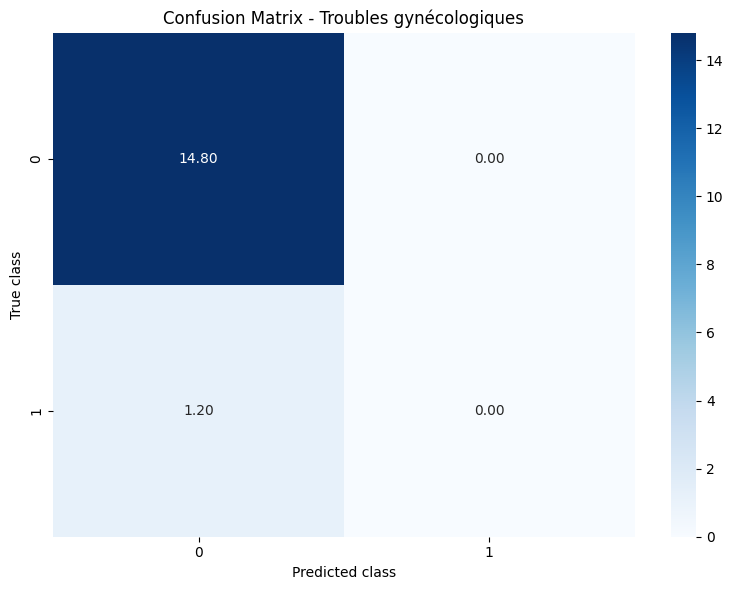


Analyse des features importantes pour Troubles gynécologiques


C:\Users\MSI\AppData\Local\Temp\ipykernel_7300\3255484608.py:113: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


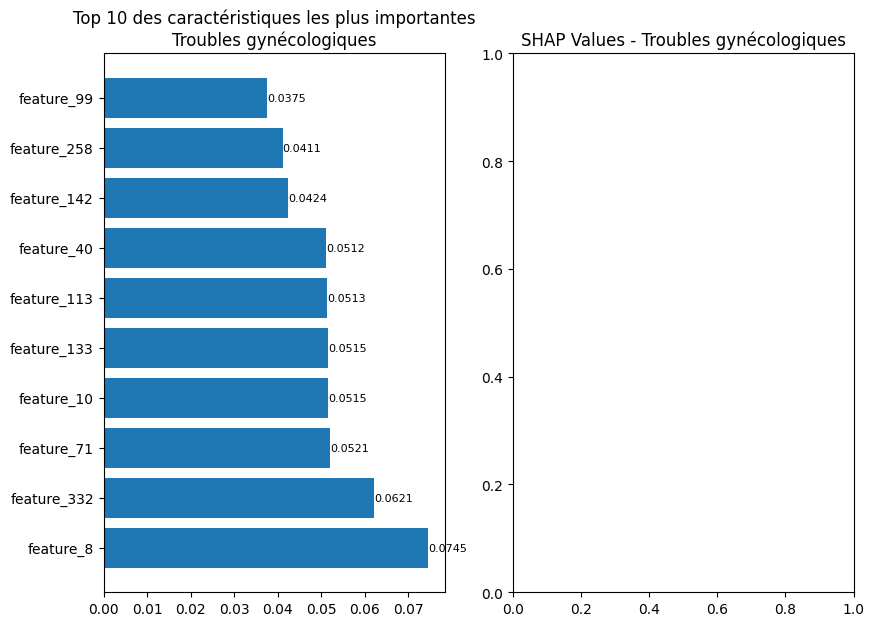

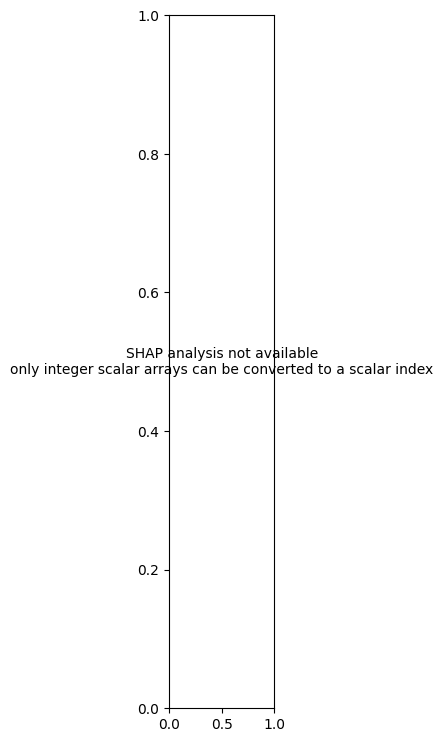


Résultats pour Troubles cardio-respiratoires

Métriques globales:
           Métrique   Valeur
   F1-score (macro) 0.406212
F1-score (weighted) 0.422576
             G-mean 0.290538


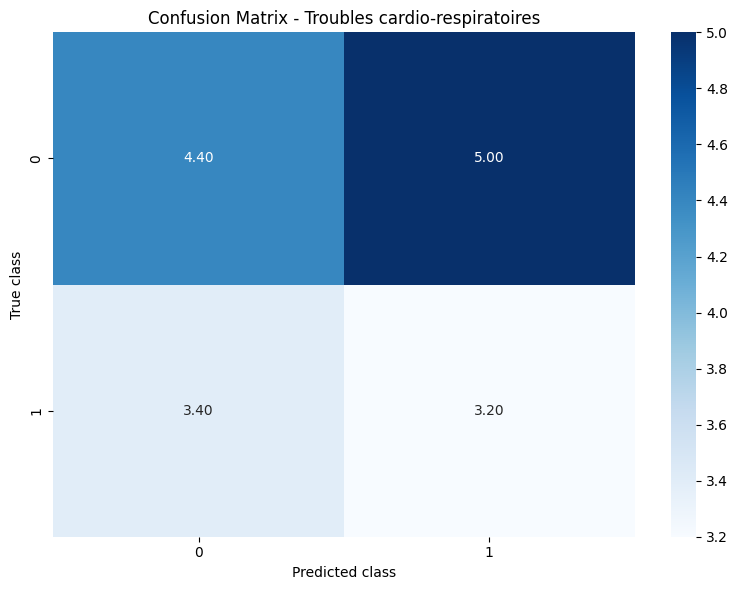


Analyse des features importantes pour Troubles cardio-respiratoires


C:\Users\MSI\AppData\Local\Temp\ipykernel_7300\3255484608.py:113: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


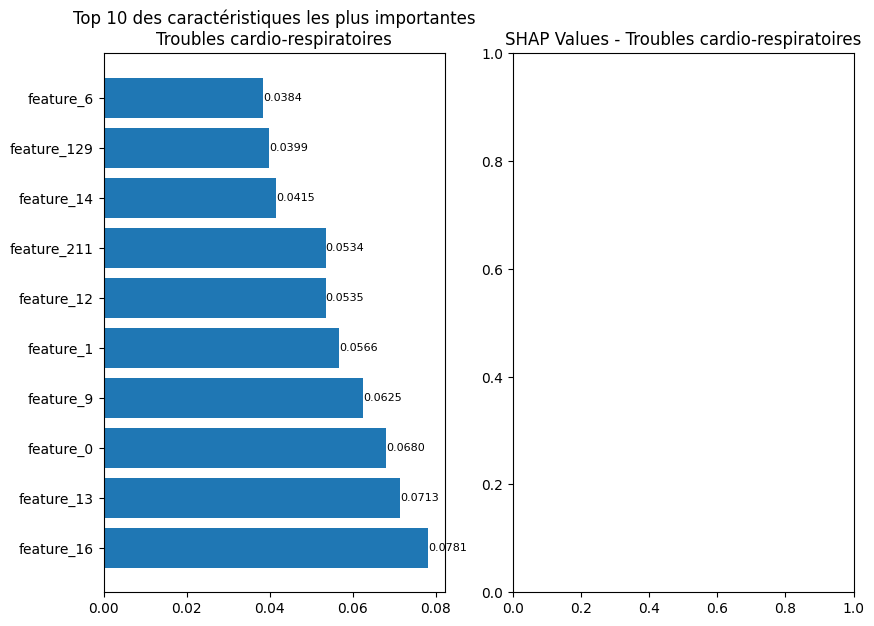

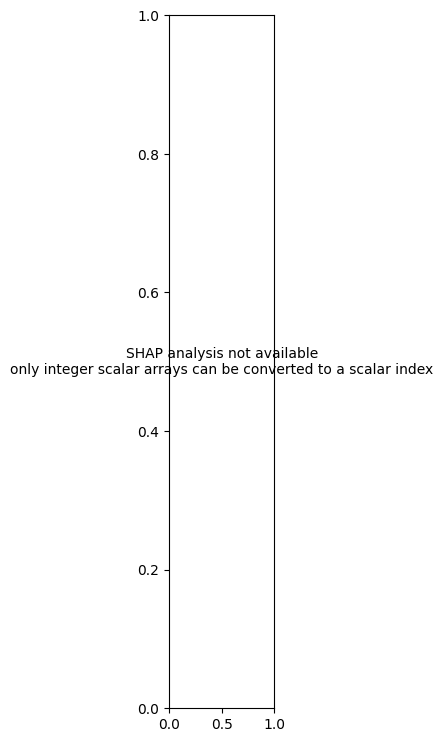


Résultats pour Troubles cognitifs

Métriques globales:
           Métrique   Valeur
   F1-score (macro) 0.452470
F1-score (weighted) 0.652118
             G-mean 0.135401


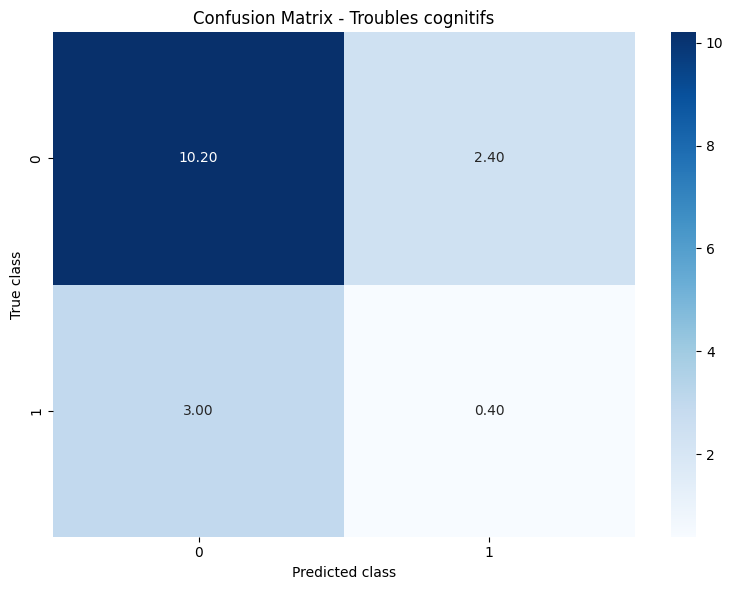


Analyse des features importantes pour Troubles cognitifs


C:\Users\MSI\AppData\Local\Temp\ipykernel_7300\3255484608.py:113: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


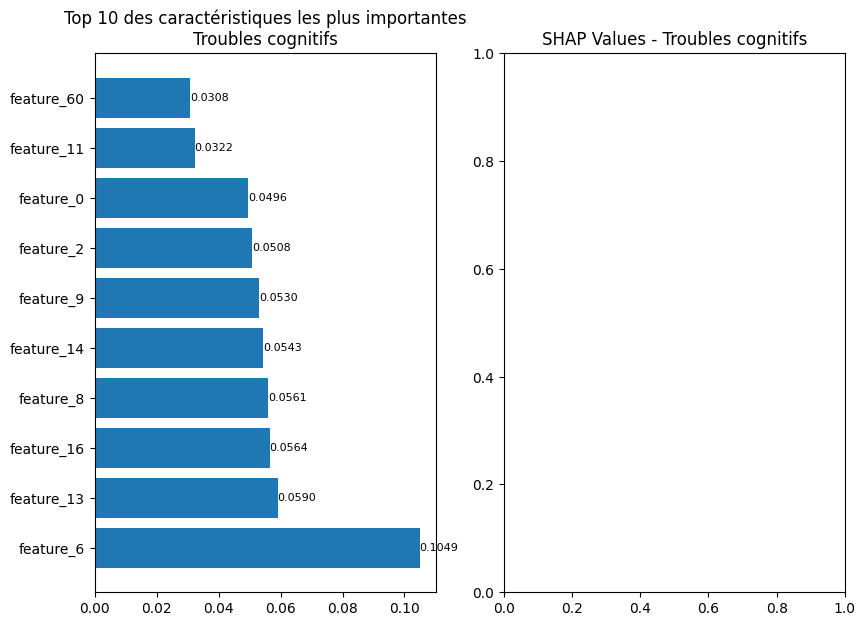

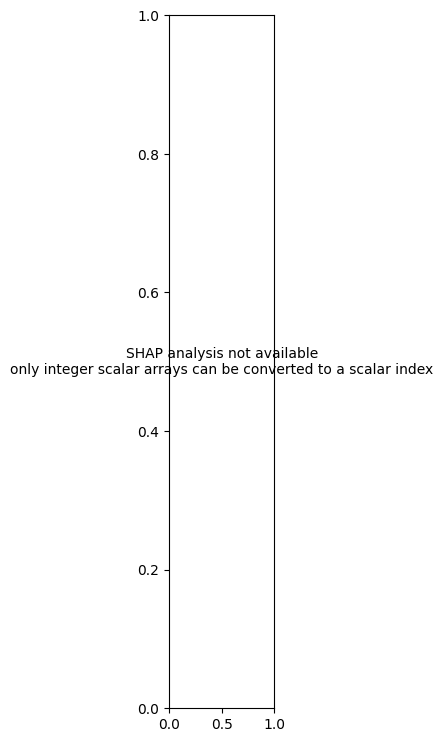


Résultats pour Troubles neurologiques

Métriques globales:
           Métrique   Valeur
   F1-score (macro) 0.396362
F1-score (weighted) 0.411443
             G-mean 0.265237


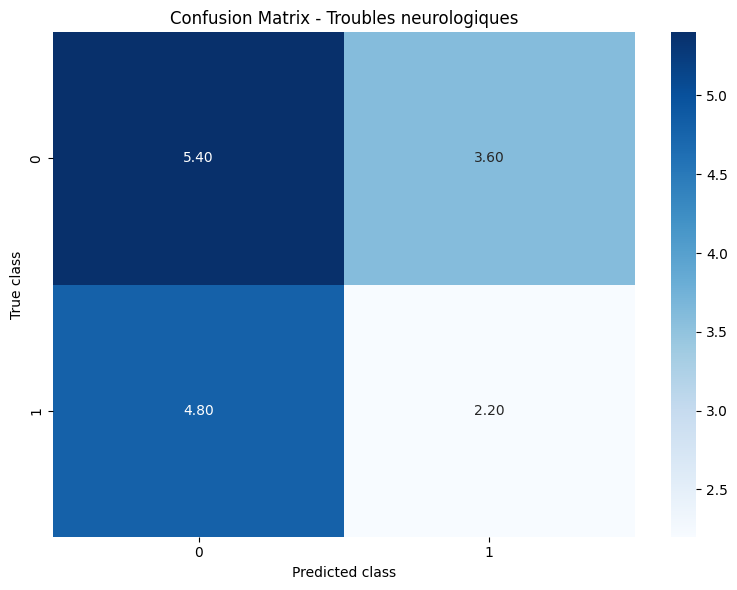


Analyse des features importantes pour Troubles neurologiques


C:\Users\MSI\AppData\Local\Temp\ipykernel_7300\3255484608.py:113: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


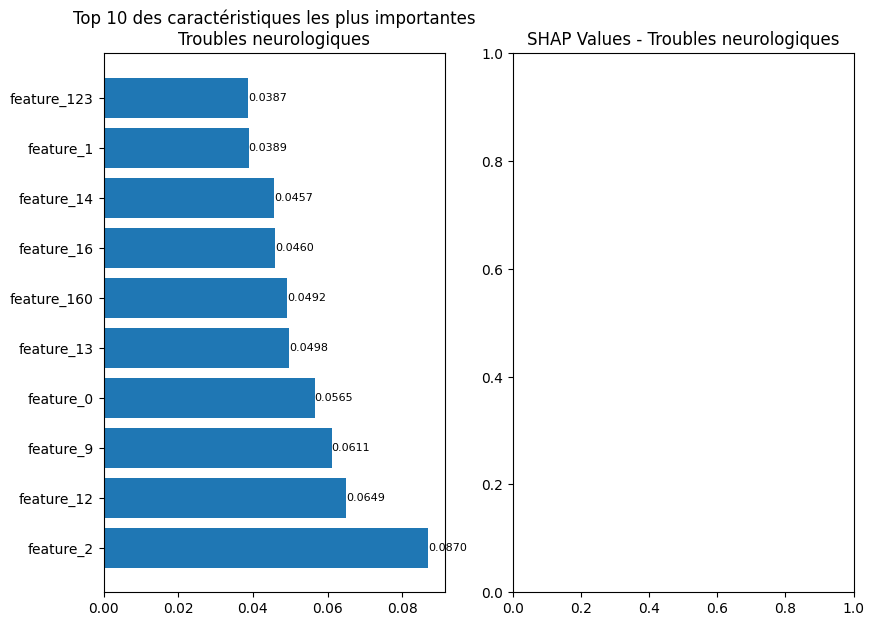

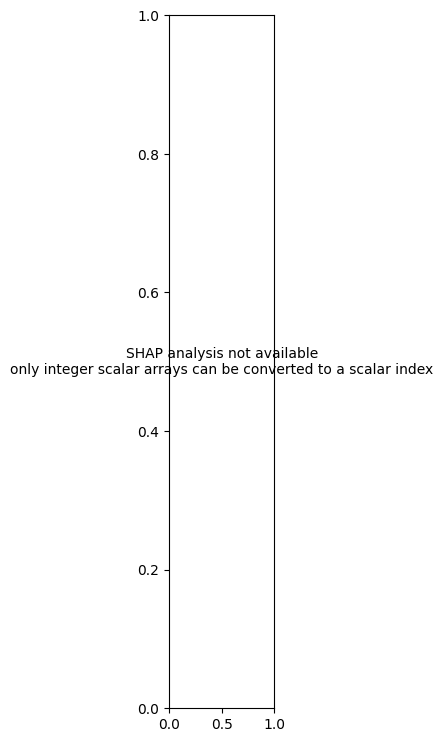


Résultats pour Troubles cutanés/phanères

Métriques globales:
           Métrique   Valeur
   F1-score (macro) 0.572063
F1-score (weighted) 0.731984
             G-mean 0.405317


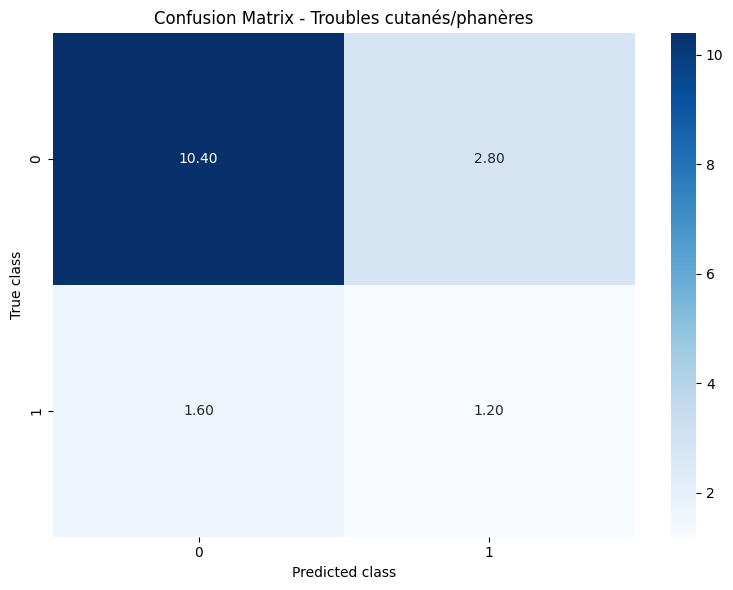


Analyse des features importantes pour Troubles cutanés/phanères


C:\Users\MSI\AppData\Local\Temp\ipykernel_7300\3255484608.py:113: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


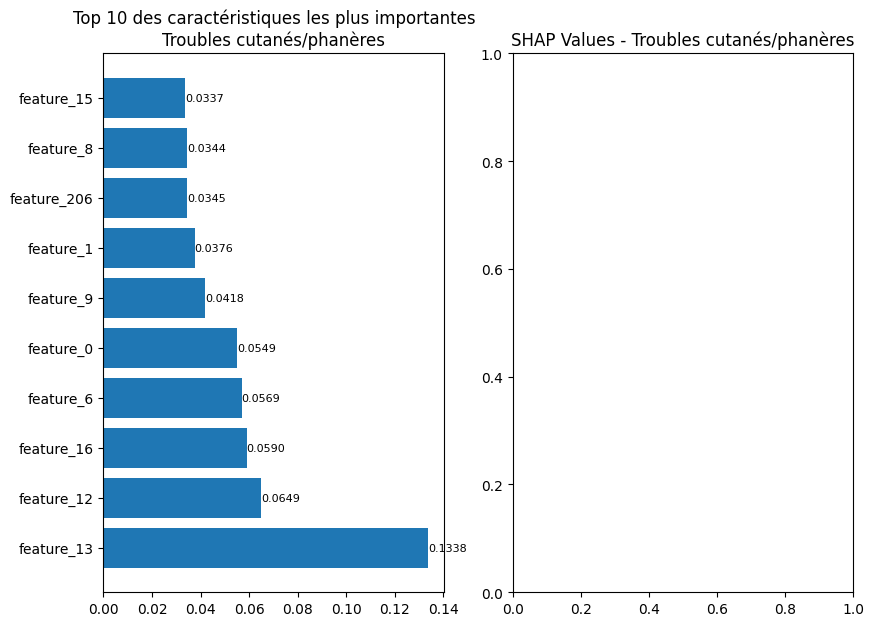

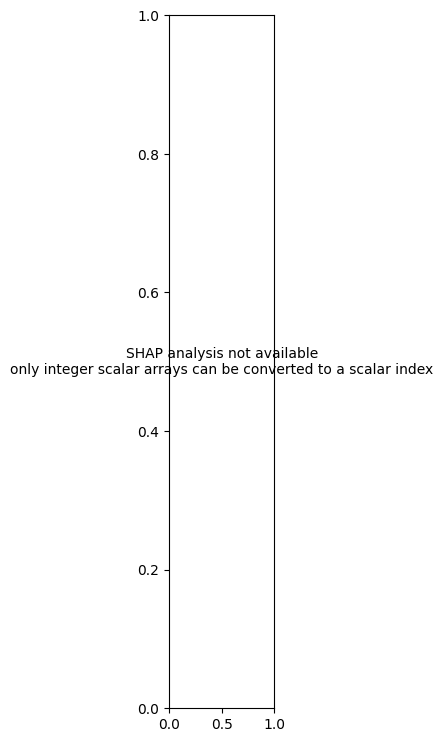

In [91]:
print_average_results(
    results=results,
    models=models,
    X=X,
    feature_names=feature_names,
    feature_selector=feature_selector
)